In [7]:
import os
import json
import re
import warnings
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

from xgboost import XGBRegressor
import category_encoders as ce

import shap
import lime
import lime.lime_tabular

warnings.filterwarnings('ignore')

In [82]:
ACAD_PATH = "academic_records.csv"
ADM_PATH = "admission.csv"
TEST_PATH = "test.csv"

# Validation semester
VAL_SEMESTER = '20232'  # HK2 2023-2024

# Output directory
OUTPUT_DIR = './outputs'

# 1. DATA PROCESS

## 1.1 Load Data

In [9]:
# Load academic records data
df_acad = pd.read_csv(ACAD_PATH)
print(f"Loaded academic records: {df_acad.shape}")

# Load admission data
df_adm = pd.read_csv(ADM_PATH)
print(f"Loaded admission data: {df_adm.shape}")

# Load test data
df_test_raw = pd.read_csv(TEST_PATH)
print(f"Loaded test data: {df_test_raw.shape}")

Loaded academic records: (105726, 6)
Loaded admission data: (30217, 6)
Loaded test data: (16502, 3)


## 1.2 Explore Data

In [10]:
print("ACADEMIC DATA")
print(f"\nShape: {df_acad.shape}")
print(f"\nColumns:\n{df_acad.columns.tolist()}")
print(f"\nFirst few rows:")
display(df_acad.head())

ACADEMIC DATA

Shape: (105726, 6)

Columns:
['MA_SO_SV', 'HOC_KY', 'CPA', 'GPA', 'TC_DANGKY', 'TC_HOANTHANH']

First few rows:


MA_SO_SV         HOC_KY   CPA   GPA  TC_DANGKY  TC_HOANTHANH
0  f022ed8d1ac1  HK2 2020-2021  2.19  2.02         18            18
1  f022ed8d1ac1  HK1 2022-2023  0.95  2.12         14             7
2  f022ed8d1ac1  HK1 2023-2024  0.81  1.89         29            16
3  f022ed8d1ac1  HK2 2022-2023  1.37  1.93         26            23
4  f022ed8d1ac1  HK2 2023-2024  1.71  1.91         16            13

In [11]:
print("ADMISSION DATA")
print(f"\nShape: {df_adm.shape}")
print(f"\nColumns:\n{df_adm.columns.tolist()}")
print(f"\nFirst few rows:")
display(df_adm.head())


ADMISSION DATA

Shape: (30217, 6)

Columns:
['MA_SO_SV', 'NAM_TUYENSINH', 'PTXT', 'TOHOP_XT', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']

First few rows:


MA_SO_SV  NAM_TUYENSINH PTXT TOHOP_XT  DIEM_TRUNGTUYEN  DIEM_CHUAN
0  0570116c3448           2018    5      A00            15.86       15.10
1  921cfe1e9ca9           2018    5      A01            15.98       14.98
2  8aeb1516c333           2018    5      A01            17.05       15.18
3  94ff3745a70e           2018    5      A00            18.67       14.78
4  5c5900eb2b53           2018    5      D07            16.67       15.06

In [12]:
print("TEST DATA")
print(f"\nShape: {df_test_raw.shape}")
print(f"\nColumns:\n{df_test_raw.columns.tolist()}")
print(f"\nFirst few rows:")
display(df_test_raw.head())


TEST DATA

Shape: (16502, 3)

Columns:
['MA_SO_SV', 'HOC_KY', 'TC_DANGKY']

First few rows:


MA_SO_SV         HOC_KY  TC_DANGKY
0  481436e2064d  HK1 2024-2025          3
1  6c8a97d22131  HK1 2024-2025          3
2  e87f62beabbb  HK1 2024-2025         13
3  438aff5ef524  HK1 2024-2025          1
4  ad172a9b0722  HK1 2024-2025         17

## 1.3 Data Quality Check


In [13]:
print("DATA QUALITY CHECK")

print("\n1. Missing values:")
print(df_acad.isnull().sum())

print("\n2. Numeric columns statistics:")
display(df_acad.describe())

print("\n3. Unique values:")
print(f"   Students: {df_acad['MA_SO_SV'].nunique()}")
print(f"   Semesters: {df_acad['HOC_KY'].nunique()}")

DATA QUALITY CHECK

1. Missing values:
MA_SO_SV        0
HOC_KY          0
CPA             0
GPA             0
TC_DANGKY       0
TC_HOANTHANH    0
dtype: int64

2. Numeric columns statistics:


CPA            GPA      TC_DANGKY   TC_HOANTHANH
count  105726.000000  105726.000000  105726.000000  105726.000000
mean        1.962662       2.290328      19.438492      15.609916
std         0.899984       0.479314       5.584857       6.610703
min         0.000000       0.000000       1.000000       0.000000
25%         1.360000       1.980000      17.000000      12.000000
50%         2.000000       2.250000      20.000000      16.000000
75%         2.600000       2.570000      22.000000      20.000000
max         4.080000       4.080000      71.000000      65.000000


3. Unique values:
   Students: 20381
   Semesters: 8


## 1.4 Visualize Before Cleaning

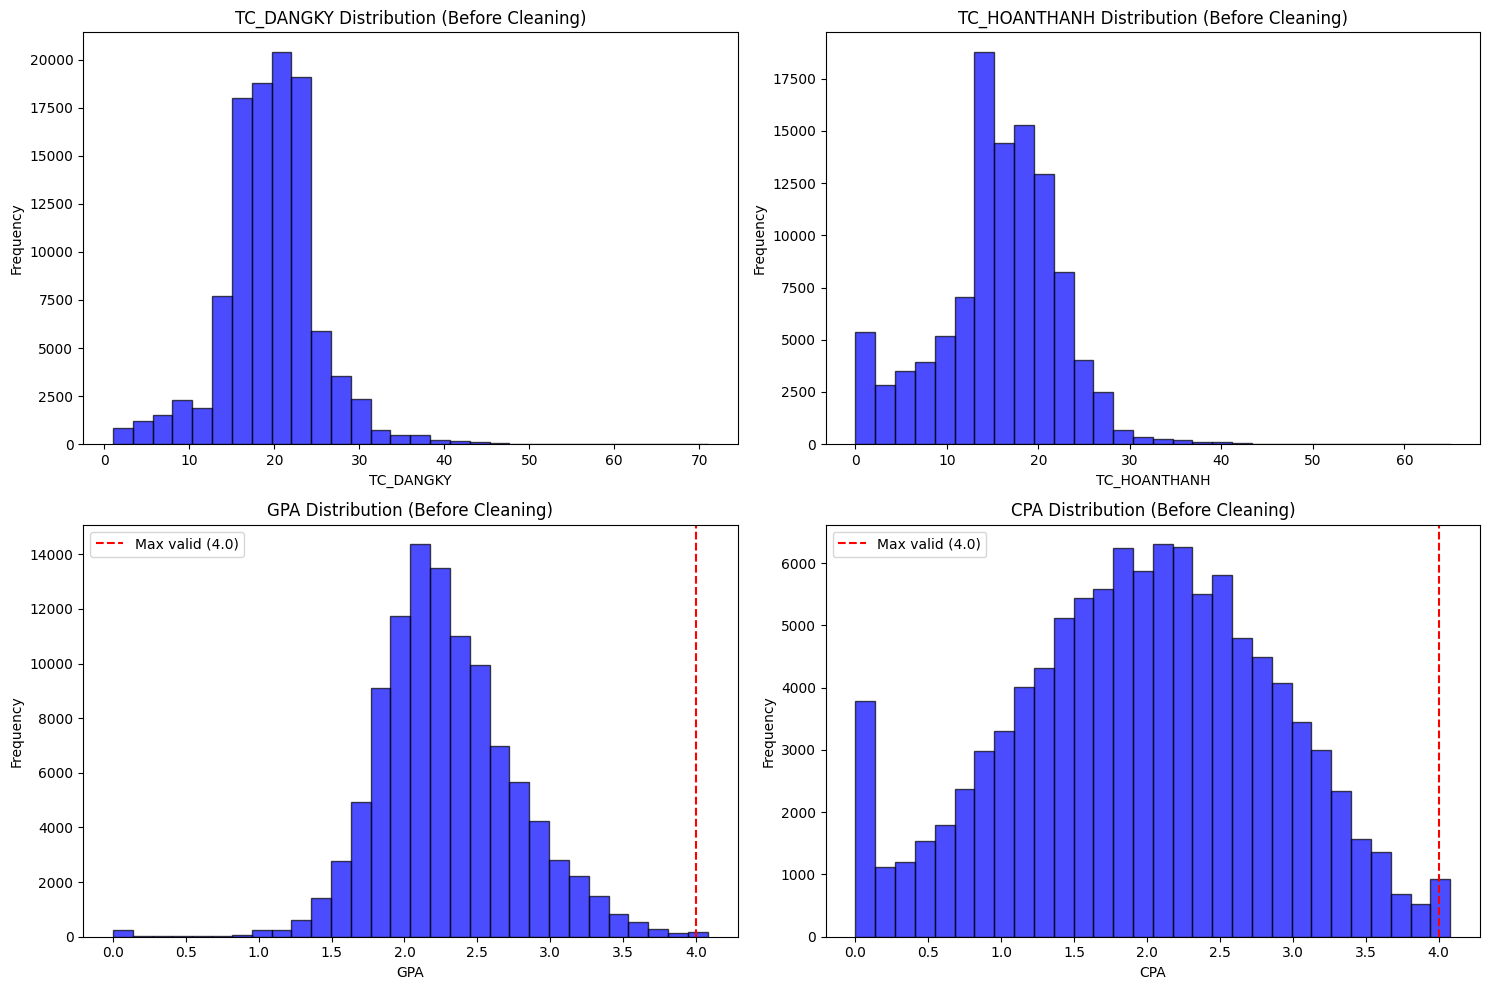

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# TC_DANGKY
axes[0, 0].hist(df_acad['TC_DANGKY'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('TC_DANGKY Distribution (Before Cleaning)')
axes[0, 0].set_xlabel('TC_DANGKY')
axes[0, 0].set_ylabel('Frequency')

# TC_HOANTHANH
axes[0, 1].hist(df_acad['TC_HOANTHANH'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('TC_HOANTHANH Distribution (Before Cleaning)')
axes[0, 1].set_xlabel('TC_HOANTHANH')
axes[0, 1].set_ylabel('Frequency')

# GPA
axes[1, 0].hist(df_acad['GPA'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('GPA Distribution (Before Cleaning)')
axes[1, 0].set_xlabel('GPA')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(x=4, color='red', linestyle='--', label='Max valid (4.0)')
axes[1, 0].legend()

# CPA
axes[1, 1].hist(df_acad['CPA'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('CPA Distribution (Before Cleaning)')
axes[1, 1].set_xlabel('CPA')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(x=4, color='red', linestyle='--', label='Max valid (4.0)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

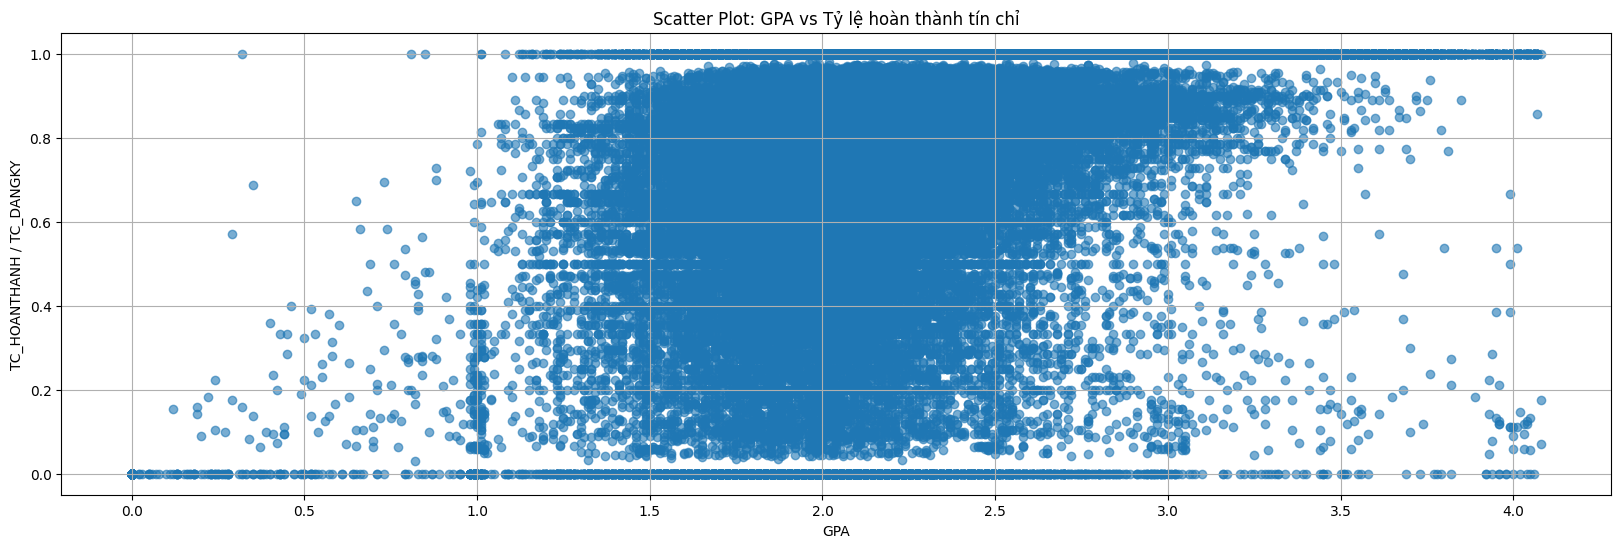

In [15]:
# Cột tỷ lệ hoàn thành tín chỉ
df_acad["TY_LE_HOANTHANH"] = df_acad["TC_HOANTHANH"] / df_acad["TC_DANGKY"]

plt.figure(figsize=(20, 6))

plt.scatter(
    df_acad["GPA"],
    df_acad["TY_LE_HOANTHANH"],
    alpha=0.6
)

plt.xlabel("GPA")
plt.ylabel("TC_HOANTHANH / TC_DANGKY")
plt.title("Scatter Plot: GPA vs Tỷ lệ hoàn thành tín chỉ")

plt.grid(True)
plt.show()

## 1.5 Clean Academic Data

***Xử lý TC_DANGKY outliers***

In [16]:
df = df_acad.copy()

Q1 = df["TC_DANGKY"].quantile(0.25)
Q3 = df["TC_DANGKY"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = int(Q3 + 1.5 * IQR)

before = df["TC_DANGKY"].max()
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

df["TC_DANGKY"] = df["TC_DANGKY"].apply(lambda x: min(x, upper_bound))
df["TC_DANGKY"] = df["TC_DANGKY"].clip(upper=upper_bound).astype(int)

print(f"Max TC_DANGKY: {before} → {df['TC_DANGKY'].max()}")

Lower bound: 9.5
Upper bound: 29
Max TC_DANGKY: 71 → 29


***Xử lý TC_HOANTHANH outliers***

In [17]:
# Xu li Tin chi hoan thanh theo Ratio cua tin chi dang ki
df["TC_RATIO"] = (
    df["TC_HOANTHANH"] / df["TC_DANGKY"]
).fillna(0).clip(upper=1.0)

df["TC_HOANTHANH"] = (df["TC_DANGKY"] * df["TC_RATIO"]).round(0).astype(int)
print(f"TC_HOANTHANH range: [{df['TC_HOANTHANH'].min()}, {df['TC_HOANTHANH'].max()}]")

TC_HOANTHANH range: [0, 29]


***Xử lý GPA***

In [18]:
zero_tc_mask = df["TC_HOANTHANH"] == 0
df.loc[zero_tc_mask, "GPA"] = 0
print(f"Set GPA=0 for {zero_tc_mask.sum()} records with TC_HOANTHANH=0")

Set GPA=0 for 3317 records with TC_HOANTHANH=0


In [19]:
#Nghien cuu phuong phap su dung
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Loc GPA hop le
clean_df = df[df["GPA"] <= 4].copy()

features = ["TC_HOANTHANH", "TC_DANGKY"]
X = clean_df[features]
y = clean_df["GPA"]

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X,
    y,
    clean_df["MA_SO_SV"],
    test_size=0.2,
    random_state=42
)

# ===== MEAN (Mean GPA theo sinh vien) =====
mean_map = clean_df.groupby("MA_SO_SV")["GPA"].mean()
pred_mean = id_test.map(mean_map)

# Neu SV moi chua co GPA truoc do
pred_mean.fillna(clean_df["GPA"].mean(), inplace=True)

# ===== RANDOM FOREST =====
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# ===== SO SANH =====
rmse_mean = np.sqrt(mean_squared_error(y_test, pred_mean))
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))

print("RMSE Mean per student:", rmse_mean)
print("RMSE Random Forest:", rmse_rf)

RMSE Mean per student: 0.3079974026199589
RMSE Random Forest: 0.3828436743714755


In [20]:
# Xu li GPA - MEAN
noise_mask = (df["GPA"] > 4) & (~zero_tc_mask)
if noise_mask.sum() > 0:
    valid_mask = df["GPA"] <= 4
    mean_gpa_per_student = df[valid_mask].groupby("MA_SO_SV")["GPA"].mean()
    mapped_values = df.loc[noise_mask, "MA_SO_SV"].map(mean_gpa_per_student)
    df.loc[noise_mask, "GPA"] = mapped_values.fillna(4.0)
    print(f"Fixed {noise_mask.sum()} GPA values > 4")

Fixed 80 GPA values > 4


***Xử lý CPA***

In [21]:
#CPA- Random Forest
noise_mask = df["CPA"] > 4

if noise_mask.sum() > 0:
    clean_df = df[df["CPA"] <= 4].copy()
    features = ["GPA", "TC_DANGKY", "TC_HOANTHANH"]
    
    X_train = clean_df[features].fillna(clean_df[features].mean())
    y_train = clean_df["CPA"]
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    X_noise = df.loc[noise_mask, features].fillna(clean_df[features].mean())
    df.loc[noise_mask, "CPA"] = rf_model.predict(X_noise)
    print(f"   Fixed {noise_mask.sum()} CPA values > 4")

df_acad_clean = df
print("\nData cleaning completed!")

   Fixed 498 CPA values > 4

Data cleaning completed!


## 1.6 Visualize After Cleaning

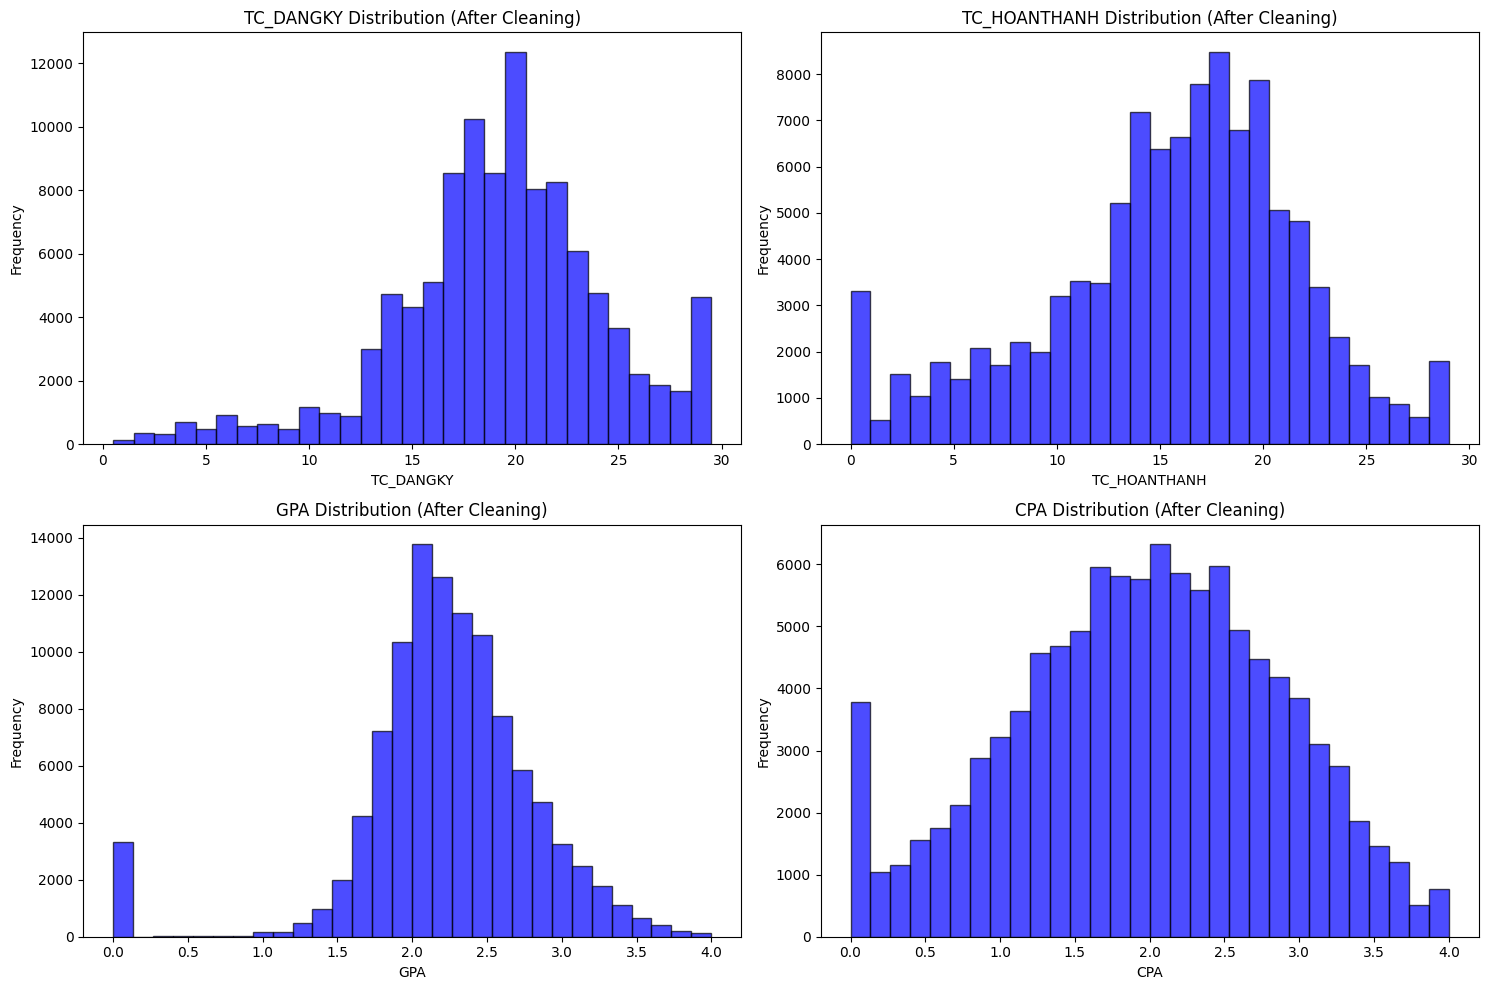

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# TC_DANGKY
min_tc = df_acad_clean["TC_DANGKY"].min()
max_tc = df_acad_clean["TC_DANGKY"].max()
axes[0, 0].hist(df_acad_clean['TC_DANGKY'], color='blue', bins=np.arange(min_tc, max_tc + 2) - 0.5, edgecolor='black',  alpha=0.7) 
axes[0, 0].set_title('TC_DANGKY Distribution (After Cleaning)')
axes[0, 0].set_xlabel('TC_DANGKY')
axes[0, 0].set_ylabel('Frequency')


# TC_HOANTHANH
axes[0, 1].hist(df_acad_clean['TC_HOANTHANH'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('TC_HOANTHANH Distribution (After Cleaning)')
axes[0, 1].set_xlabel('TC_HOANTHANH')
axes[0, 1].set_ylabel('Frequency')

# GPA
axes[1, 0].hist(df_acad_clean['GPA'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('GPA Distribution (After Cleaning)')
axes[1, 0].set_xlabel('GPA')
axes[1, 0].set_ylabel('Frequency')

# CPA
axes[1, 1].hist(df_acad_clean['CPA'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('CPA Distribution (After Cleaning)')
axes[1, 1].set_xlabel('CPA')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 1.7 Merge with Admission Data

In [23]:
df_merged = df_acad_clean.merge(df_adm, on="MA_SO_SV", how="left")
print(f"Merged shape: {df_merged.shape}")

# Tính DIEM_LECH
df_merged["DIEM_LECH"] = df_merged["DIEM_TRUNGTUYEN"] - df_merged["DIEM_CHUAN"]

print(f"\nNew columns from admission:")
print([col for col in df_merged.columns if col not in df_acad_clean.columns])


Merged shape: (105726, 13)

New columns from admission:
['NAM_TUYENSINH', 'PTXT', 'TOHOP_XT', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'DIEM_LECH']


## 1.8 Analyze Relationships

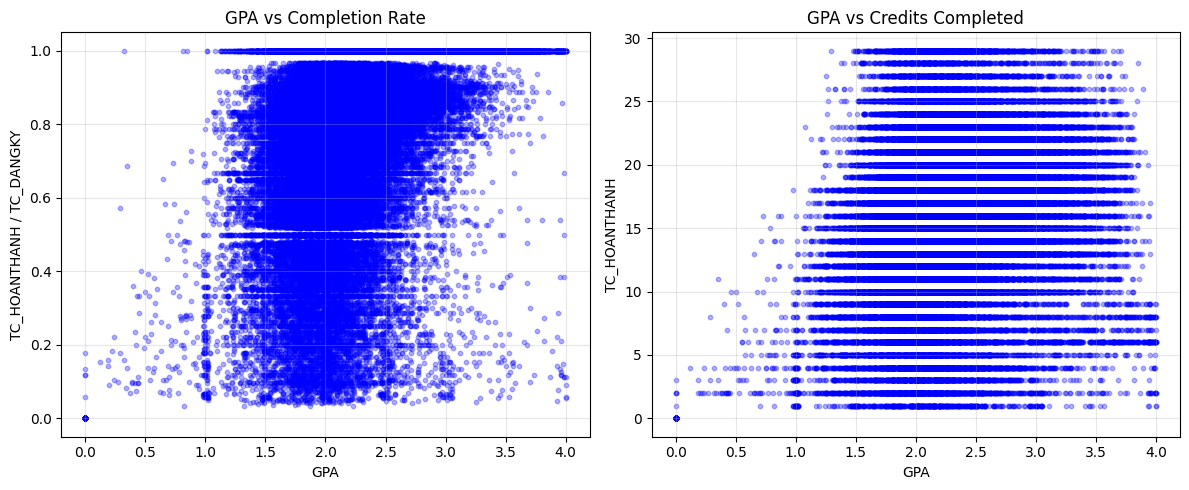

In [24]:
# GPA vs TC_HOANTHANH ratio
df_merged['TC_RATIO'] = df_merged['TC_HOANTHANH'] / df_merged['TC_DANGKY']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df_merged['GPA'], df_merged['TC_RATIO'], color='blue', alpha=0.3, s=10)
plt.xlabel('GPA')
plt.ylabel('TC_HOANTHANH / TC_DANGKY')
plt.title('GPA vs Completion Rate')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(df_merged['GPA'], df_merged['TC_HOANTHANH'], color='blue', alpha=0.3, s=10)
plt.xlabel('GPA')
plt.ylabel('TC_HOANTHANH')
plt.title('GPA vs Credits Completed')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 2. FEATURE ENGINEERING

## 2.1 Helper Functions

In [25]:
def convert_semester_format(semester_str):
    """
    Convert semester format: 'HK1 2024-2025' -> '20241'
    """
    if isinstance(semester_str, (int, float)):
        return str(int(semester_str))
    
    semester_str = str(semester_str).strip()
    
    # Nếu đã đúng format (5 chữ số)
    if semester_str.isdigit() and len(semester_str) == 5:
        return semester_str
    
    # Parse format 'HK1 2024-2025'
    match = re.match(r'HK(\d)\s+(\d{4})-(\d{4})', semester_str)
    if match:
        hk_num = match.group(1)
        year = match.group(2)
        return f"{year}{hk_num}"
    
    return semester_str


def calculate_history_features(history, current_tc_dangky):
    """
    Tính features từ lịch sử các kỳ đã học
    
    Parameters:
    -----------
    history: DataFrame - Lịch sử các kỳ đã học (sorted by semester)
    current_tc_dangky: int - Tín chỉ đăng ký kỳ hiện tại
    
    Returns:
    --------
    dict: Dictionary chứa các features
    """
    if len(history) == 0:
        return None
    
    features = {}
    Ti = len(history)
    
    # I. GPA FEATURES
    features['GPA_mean'] = history['GPA'].mean()
    features['GPA_last'] = history['GPA'].iloc[-1]
    features['GPA_min'] = history['GPA'].min()
    features['GPA_max'] = history['GPA'].max()
    
    if Ti > 1:
        t = np.arange(1, Ti + 1)
        slope, _ = np.polyfit(t, history['GPA'].values, 1)
        features['GPA_trend'] = slope
        features['GPA_std'] = history['GPA'].std()
    else:
        features['GPA_trend'] = 0
        features['GPA_std'] = 0
    
    # II. CPA FEATURES
    features['CPA_last'] = history['CPA'].iloc[-1]
    
    # III. TC_HOANTHANH FEATURES
    features['TC_HT_mean'] = history['TC_HOANTHANH'].mean()
    features['TC_HT_last'] = history['TC_HOANTHANH'].iloc[-1]
    features['TC_HT_std'] = history['TC_HOANTHANH'].std() if Ti > 1 else 0
    features['TC_TICHLU'] = history['TC_HOANTHANH'].sum()
    
    # TC_RATIO (completion rate)
    history_ratio = history['TC_RATIO'].clip(0, 1)
    features['TC_HT_ratio_mean'] = history_ratio.mean()
    
    # IV. SEMESTER COUNT & FAIL FEATURES
    features['num_semesters'] = Ti
    
    failed = (history['TC_HOANTHANH'] == 0) | (history['TC_RATIO'] < 0.5)
    features['num_failed_semesters'] = failed.sum()
    features['fail_rate'] = features['num_failed_semesters'] / Ti if Ti > 0 else 0
    
    # Consecutive fails
    consecutive = 0
    for j in range(Ti - 1, -1, -1):
        if failed.iloc[j]:
            consecutive += 1
        else:
            break
    features['consecutive_fails'] = consecutive
    
    # V. TC_DANGKY FEATURES
    features['TC_DANGKY_mean'] = history['TC_DANGKY'].mean()
    features['TC_DANGKY_last'] = history['TC_DANGKY'].iloc[-1]
    features['TC_DANGKY_std'] = history['TC_DANGKY'].std() if Ti > 1 else 0
    
    # Current semester features
    features['TC_DANGKY_current'] = current_tc_dangky
    
    # Load ratio
    tc_ht_mean_safe = features['TC_HT_mean'] if features['TC_HT_mean'] > 0 else 1
    features['TC_load_ratio'] = current_tc_dangky / tc_ht_mean_safe
    
    # TC change
    features['TC_change'] = current_tc_dangky - features['TC_DANGKY_last']
    
    # Interaction
    features['TC_GPA_interaction'] = current_tc_dangky * features['GPA_last']
    
    # Flags
    features['overload_risk'] = int(features['TC_load_ratio'] > 1.2)
    features['is_increasing_load'] = int(features['TC_change'] > 0)
    
    return features

## 2.2 Prepare Train & Validation Data

In [26]:
print("FEATURE ENGINEERING - TRAIN & VALIDATION")
df = df_merged.copy()

FEATURE ENGINEERING - TRAIN & VALIDATION


***Convert semester format***

In [27]:
df['HOC_KY_STR'] = df['HOC_KY'].apply(convert_semester_format)
df['HOC_KY_INT'] = df['HOC_KY_STR'].astype(int)

***Sort by student and semester***

In [28]:
df = df.sort_values(['MA_SO_SV', 'HOC_KY_INT']).reset_index(drop=True)
print(f"Total records: {len(df):,}")
print(f"Semesters: {sorted(df['HOC_KY_STR'].unique())}")

Total records: 105,726
Semesters: ['20201', '20202', '20211', '20212', '20221', '20222', '20231', '20232']


***Create semester number per student***

In [29]:
df['KY_SO'] = df.groupby('MA_SO_SV').cumcount() + 1

***Calculate expanding features for each semester***

In [30]:
print("\nComputing expanding window features")

all_features = []
students = df['MA_SO_SV'].unique()

for idx, student_id in enumerate(students):
    if (idx + 1) % 1000 == 0:
        print(f"   Processed {idx + 1:,}/{len(students):,} students...")
    
    df_student = df[df['MA_SO_SV'] == student_id].copy()
    
    # Tính features cho từng kỳ
    for i in range(len(df_student)):
        current = df_student.iloc[i]
        
        if i == 0:
            # Kỳ đầu tiên: không có history
            feat = {
                'MA_SO_SV': student_id,
                'HOC_KY_STR': current['HOC_KY_STR'],
                'HOC_KY_INT': current['HOC_KY_INT'],
                'KY_SO': current['KY_SO'],
                'TC_DANGKY_current': current['TC_DANGKY'],
                'TC_HOANTHANH': current['TC_HOANTHANH'],
                
                # No history features - set to default
                'num_semesters': 0,
                'GPA_mean': 0,
                'GPA_last': 0,
                'GPA_min': 0,
                'GPA_max': 0,
                'GPA_trend': 0,
                'GPA_std': 0,
                'CPA_last': 0,
                'TC_HT_mean': 0,
                'TC_HT_last': 0,
                'TC_HT_std': 0,
                'TC_TICHLU': 0,
                'TC_HT_ratio_mean': 0,
                'num_failed_semesters': 0,
                'fail_rate': 0,
                'consecutive_fails': 0,
                'TC_DANGKY_mean': 0,
                'TC_DANGKY_last': 0,
                'TC_DANGKY_std': 0,
                'TC_load_ratio': 1.0,
                'TC_change': 0,
                'TC_GPA_interaction': 0,
                'overload_risk': 0,
                'is_increasing_load': 0,
            }
            
            # Add admission data
            for col in ['NAM_TUYENSINH', 'PTXT', 'TOHOP_XT', 
                       'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'DIEM_LECH']:
                if col in current:
                    feat[col] = current[col]
            
            all_features.append(feat)
            
        else:
            # Có history
            history = df_student.iloc[:i].copy()
            
            feat = calculate_history_features(
                history=history,
                current_tc_dangky=current['TC_DANGKY']
            )
            
            if feat:
                # Add metadata
                feat['MA_SO_SV'] = student_id
                feat['HOC_KY_STR'] = current['HOC_KY_STR']
                feat['HOC_KY_INT'] = current['HOC_KY_INT']
                feat['KY_SO'] = current['KY_SO']
                feat['TC_HOANTHANH'] = current['TC_HOANTHANH']
                
                # Add admission data
                for col in ['NAM_TUYENSINH', 'PTXT', 'TOHOP_XT',
                           'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'DIEM_LECH']:
                    if col in current:
                        feat[col] = current[col]
                
                all_features.append(feat)

df_features = pd.DataFrame(all_features)
print(f"\nCreated {len(df_features):,} feature records")


Computing expanding window features
   Processed 1,000/20,381 students...
   Processed 2,000/20,381 students...
   Processed 3,000/20,381 students...
   Processed 4,000/20,381 students...
   Processed 5,000/20,381 students...
   Processed 6,000/20,381 students...
   Processed 7,000/20,381 students...
   Processed 8,000/20,381 students...
   Processed 9,000/20,381 students...
   Processed 10,000/20,381 students...
   Processed 11,000/20,381 students...
   Processed 12,000/20,381 students...
   Processed 13,000/20,381 students...
   Processed 14,000/20,381 students...
   Processed 15,000/20,381 students...
   Processed 16,000/20,381 students...
   Processed 17,000/20,381 students...
   Processed 18,000/20,381 students...
   Processed 19,000/20,381 students...
   Processed 20,000/20,381 students...

Created 105,726 feature records


***Split train/val***

In [31]:
print(f"\nSplitting train/val (val_semester={VAL_SEMESTER})")
val_semester_int = int(VAL_SEMESTER)

df_train = df_features[df_features['HOC_KY_INT'] < val_semester_int].copy()
df_val = df_features[df_features['HOC_KY_INT'] == val_semester_int].copy()

print(f"   Train: {len(df_train):,} records")
print(f"   Val:   {len(df_val):,} records")
print(f"   Total features: {len(df_features.columns)} columns")


Splitting train/val (val_semester=20232)
   Train: 90,582 records
   Val:   15,144 records
   Total features: 36 columns


## 2.3 Explore Created Features

In [32]:
print("TRAIN DATA FEATURES")

print(f"\nShape: {df_train.shape}")
print(f"\nSample features:")
display(df_train.head(10))

# Check students without history
no_history = df_train[df_train['num_semesters'] == 0]
print(f"\nStudents without history in TRAIN: {len(no_history)} ({len(no_history)/len(df_train)*100:.1f}%)")

no_history_val = df_val[df_val['num_semesters'] == 0]
print(f"Students without history in VAL: {len(no_history_val)} ({len(no_history_val)/len(df_val)*100:.1f}%)")

TRAIN DATA FEATURES

Shape: (90582, 36)

Sample features:


MA_SO_SV HOC_KY_STR  HOC_KY_INT  KY_SO  TC_DANGKY_current  \
0   00003e092652      20231       20231      1                 18   
2   000e15519006      20211       20211      1                  9   
3   000e15519006      20212       20212      2                 19   
4   000e15519006      20221       20221      3                 21   
5   000e15519006      20222       20222      4                 18   
6   000e15519006      20231       20231      5                 20   
8   000ea6e12003      20231       20231      1                 17   
10  00109b845a3d      20231       20231      1                 14   
12  0013bfc00f46      20201       20201      1                 16   
13  0013bfc00f46      20202       20202      2                 23   

    TC_HOANTHANH  num_semesters  GPA_mean  GPA_last  GPA_min  ...  TC_change  \
0             15              0  0.000000      0.00     0.00  ...          0   
2              9              0  0.000000      0.00     0.00  ...          0   
3             19              1  3.850000      3.85     3.85  ...         10   
4             21              2  3.485000      3.12     3.12  ...          2   
5             18              3  3.316667      2.98     2.98  ...         -3   
6             14              4  3.217500      2.92     2.92  ...          2   
8             10              0  0.000000      0.00     0.00  ...          0   
10             2              0  0.000000      0.00     0.00  ...          0   
12            11              0  0.000000      0.00     0.00  ...          0   
13            23              1  1.780000      1.78     1.78  ...          7   

    TC_GPA_interaction  overload_risk  is_increasing_load  NAM_TUYENSINH  \
0                 0.00              0                   0           2023   
2                 0.00              0                   0           2021   
3                73.15              1                   1           2021   
4                65.52              1                   1           2021   
5                53.64              0                   0           2021   
6                58.40              0                   1           2021   
8                 0.00              0                   0           2023   
10                0.00              0                   0           2023   
12                0.00              0                   0           2020   
13               40.94              1                   1           2020   

    PTXT  TOHOP_XT  DIEM_TRUNGTUYEN  DIEM_CHUAN  DIEM_LECH  
0    100       A00            21.32       20.25       1.07  
2      1       D07            23.84       22.43       1.41  
3      1       D07            23.84       22.43       1.41  
4      1       D07            23.84       22.43       1.41  
5      1       D07            23.84       22.43       1.41  
6      1       D07            23.84       22.43       1.41  
8    100       D01            25.14       24.08       1.06  
10   100       V00            20.09       18.98       1.11  
12     1       A00            24.53       24.28       0.25  
13     1       A00            24.53       24.28       0.25  

[10 rows x 36 columns]


Students without history in TRAIN: 20381 (22.5%)
Students without history in VAL: 0 (0.0%)


## 2.4 Prepare Test Data

In [33]:
print("FEATURE ENGINEERING - TEST DATA")
df_test = df_test_raw.copy()

FEATURE ENGINEERING - TEST DATA


***Convert semester format***

In [34]:
print("\nConverting semester format")
df_test['HOC_KY_STR'] = df_test['HOC_KY'].apply(convert_semester_format)
df_test['HOC_KY_INT'] = df_test['HOC_KY_STR'].astype(int)
print(f"   Test semester: {df_test['HOC_KY_STR'].unique()}")


Converting semester format
   Test semester: ['20241']


***Prepare history***

In [35]:
df_history = df_merged.copy()
df_history['HOC_KY_STR'] = df_history['HOC_KY'].apply(convert_semester_format)
df_history['HOC_KY_INT'] = df_history['HOC_KY_STR'].astype(int)
df_history = df_history.sort_values(['MA_SO_SV', 'HOC_KY_INT'])

***Calculate features***

In [36]:
print("\nComputing features from history...")

test_features = []

for idx, row in df_test.iterrows():
    if (idx + 1) % 500 == 0:
        print(f"   Processed {idx + 1:,}/{len(df_test):,} test records")
    
    student_id = row['MA_SO_SV']
    target_semester_int = row['HOC_KY_INT']
    tc_dangky = row['TC_DANGKY']
    
    # Lấy lịch sử các kỳ trước
    history = df_history[
        (df_history['MA_SO_SV'] == student_id) & 
        (df_history['HOC_KY_INT'] < target_semester_int)
    ].copy()
    
    # Tính số kỳ đã học
    ky_so = len(history) + 1
    
    if len(history) == 0:
        # Sinh viên mới - chỉ có admission data
        feat = {
            'MA_SO_SV': student_id,
            'HOC_KY_STR': row['HOC_KY_STR'],
            'HOC_KY_INT': row['HOC_KY_INT'],
            'KY_SO': ky_so,
            'TC_DANGKY_current': tc_dangky,
            
            # No history
            'num_semesters': 0,
            'GPA_mean': 0,
            'GPA_last': 0,
            'GPA_min': 0,
            'GPA_max': 0,
            'GPA_trend': 0,
            'GPA_std': 0,
            'CPA_last': 0,
            'TC_HT_mean': 0,
            'TC_HT_last': 0,
            'TC_HT_std': 0,
            'TC_TICHLU': 0,
            'TC_HT_ratio_mean': 0,
            'num_failed_semesters': 0,
            'fail_rate': 0,
            'consecutive_fails': 0,
            'TC_DANGKY_mean': 0,
            'TC_DANGKY_last': 0,
            'TC_DANGKY_std': 0,
            'TC_load_ratio': 1.0,
            'TC_change': 0,
            'TC_GPA_interaction': 0,
            'overload_risk': 0,
            'is_increasing_load': 0,
        }
    else:
        # Có history
        feat = calculate_history_features(
            history=history,
            current_tc_dangky=tc_dangky
        )
        
        if feat:
            feat['MA_SO_SV'] = student_id
            feat['HOC_KY_STR'] = row['HOC_KY_STR']
            feat['HOC_KY_INT'] = row['HOC_KY_INT']
            feat['KY_SO'] = ky_so
    
    test_features.append(feat)

df_test_features = pd.DataFrame(test_features)


Computing features from history...
   Processed 500/16,502 test records
   Processed 1,000/16,502 test records
   Processed 1,500/16,502 test records
   Processed 2,000/16,502 test records
   Processed 2,500/16,502 test records
   Processed 3,000/16,502 test records
   Processed 3,500/16,502 test records
   Processed 4,000/16,502 test records
   Processed 4,500/16,502 test records
   Processed 5,000/16,502 test records
   Processed 5,500/16,502 test records
   Processed 6,000/16,502 test records
   Processed 6,500/16,502 test records
   Processed 7,000/16,502 test records
   Processed 7,500/16,502 test records
   Processed 8,000/16,502 test records
   Processed 8,500/16,502 test records
   Processed 9,000/16,502 test records
   Processed 9,500/16,502 test records
   Processed 10,000/16,502 test records
   Processed 10,500/16,502 test records
   Processed 11,000/16,502 test records
   Processed 11,500/16,502 test records
   Processed 12,000/16,502 test records
   Processed 12,500/16,50

***Merge với admission data***

In [37]:
df_test_features = df_test_features.merge(
    df_adm[['MA_SO_SV', 'NAM_TUYENSINH', 'PTXT', 'TOHOP_XT',
           'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']],
    on='MA_SO_SV',
    how='left'
)

***Tinh DIEM_LECH***

In [38]:
df_test_features['DIEM_LECH'] = (
    df_test_features['DIEM_TRUNGTUYEN'] - df_test_features['DIEM_CHUAN']
)

In [39]:
print(f"\nCreated {len(df_test_features):,} test records")
print(f"   Students without history: {(df_test_features['num_semesters'] == 0).sum()}")
print(f"   Total features: {len(df_test_features.columns)} columns")


Created 16,502 test records
   Students without history: 4328
   Total features: 35 columns


# 3. ENCODING & FEATURE SELECTION

## 3.1 Analyze PTXT and TOHOP_XT

In [40]:
print("CATEGORICAL FEATURES ANALYSIS")

print("\n1. PTXT (Phương thức xét tuyển):")
print(df_train['PTXT'].value_counts())
print(f"   Unique values: {df_train['PTXT'].nunique()}")

print("\n2. TOHOP_XT (Tổ hợp xét tuyển):")
print(df_train['TOHOP_XT'].value_counts().head(10))
print(f"   Unique values: {df_train['TOHOP_XT'].nunique()}")


CATEGORICAL FEATURES ANALYSIS

1. PTXT (Phương thức xét tuyển):
PTXT
1      75991
100    14038
409      339
500       55
402       52
3         52
5         32
200       23
Name: count, dtype: int64
   Unique values: 8

2. TOHOP_XT (Tổ hợp xét tuyển):
TOHOP_XT
A00    56629
A01    16149
V00     8437
D07     3576
V02     3006
V01     1072
D01      761
B00      353
X01      160
V06      149
Name: count, dtype: int64
   Unique values: 18


## 3.2 Target Encoding

In [41]:
print("ENCODING CATEGORICAL FEATURES")

print("\nTarget Encoding for PTXT and TOHOP_XT...")

ptxt_encoder = ce.TargetEncoder(cols=['PTXT'], smoothing=1.0)
tohop_encoder = ce.TargetEncoder(cols=['TOHOP_XT'], smoothing=1.0)

ENCODING CATEGORICAL FEATURES

Target Encoding for PTXT and TOHOP_XT...


In [42]:
# Fit on train
df_train_enc = df_train.copy()
df_train_enc['PTXT_TE'] = ptxt_encoder.fit_transform(
    df_train[['PTXT']], df_train['TC_HOANTHANH']
)['PTXT']
df_train_enc['TOHOP_TE'] = tohop_encoder.fit_transform(
    df_train[['TOHOP_XT']], df_train['TC_HOANTHANH']
)['TOHOP_XT']

# Transform val
df_val_enc = df_val.copy()
df_val_enc['PTXT_TE'] = ptxt_encoder.transform(df_val[['PTXT']])['PTXT']
df_val_enc['TOHOP_TE'] = tohop_encoder.transform(df_val[['TOHOP_XT']])['TOHOP_XT']

# Transform test
df_test_enc = df_test_features.copy()
df_test_enc['PTXT_TE'] = ptxt_encoder.transform(df_test_features[['PTXT']])['PTXT']
df_test_enc['TOHOP_TE'] = tohop_encoder.transform(df_test_features[['TOHOP_XT']])['TOHOP_XT']

print(f"   PTXT encoded: {df_train['PTXT'].nunique()} categories")
print(f"   TOHOP_XT encoded: {df_train['TOHOP_XT'].nunique()} categories")

   PTXT encoded: 8 categories
   TOHOP_XT encoded: 18 categories


## 3.3 Visualize Encoded Features

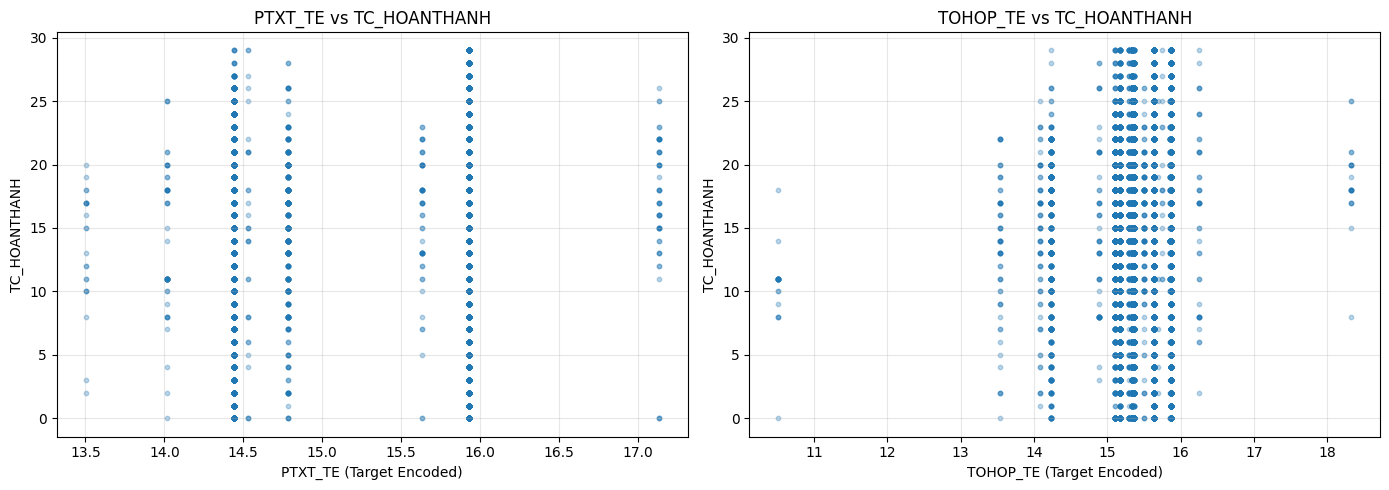

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PTXT_TE
axes[0].scatter(df_train_enc['PTXT_TE'], df_train_enc['TC_HOANTHANH'], 
                alpha=0.3, s=10)
axes[0].set_xlabel('PTXT_TE (Target Encoded)')
axes[0].set_ylabel('TC_HOANTHANH')
axes[0].set_title('PTXT_TE vs TC_HOANTHANH')
axes[0].grid(True, alpha=0.3)

# TOHOP_TE
axes[1].scatter(df_train_enc['TOHOP_TE'], df_train_enc['TC_HOANTHANH'], 
                alpha=0.3, s=10)
axes[1].set_xlabel('TOHOP_TE (Target Encoded)')
axes[1].set_ylabel('TC_HOANTHANH')
axes[1].set_title('TOHOP_TE vs TC_HOANTHANH')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [44]:
# Check correlation
print(f"\nCorrelation with TC_HOANTHANH:")
print(f"  PTXT_TE:  {df_train_enc[['PTXT_TE', 'TC_HOANTHANH']].corr().iloc[0,1]:.4f}")
print(f"  TOHOP_TE: {df_train_enc[['TOHOP_TE', 'TC_HOANTHANH']].corr().iloc[0,1]:.4f}")


Correlation with TC_HOANTHANH:
  PTXT_TE:  0.0863
  TOHOP_TE: 0.0477


## 3.4 Feature Selection

In [48]:
print("FEATURE SELECTION")

mandatory_features = [
    'TC_DANGKY_current',
    'num_semesters',
    'NAM_TUYENSINH',
    'PTXT_TE',
    'TOHOP_TE',
    'DIEM_TRUNGTUYEN',
    'DIEM_CHUAN',
    'DIEM_LECH',
    'KY_SO',
]

exclude_cols = [
    'MA_SO_SV', 'TC_HOANTHANH', 'HOC_KY', 'HOC_KY_INT', 'HOC_KY_STR',
    'PTXT', 'TOHOP_XT'
]

numeric_cols = [
    c for c in df_train_enc.select_dtypes(include=np.number).columns 
    if c not in exclude_cols
]

FEATURE SELECTION


In [50]:
# Tính correlation matrix
target_col = 'TC_HOANTHANH'
corr_threshold = 0.05
multicollinearity_threshold = 0.9

corr_matrix = df_train_enc[numeric_cols + [target_col]].corr()
target_corr = abs(corr_matrix[target_col]).sort_values(ascending=False)

In [51]:
# Bước 1: Lọc theo correlation với target
selected = target_corr[target_corr > corr_threshold].index.tolist()
if target_col in selected:
    selected.remove(target_col)


In [52]:
# Thêm mandatory features
for feat in mandatory_features:
    if feat in numeric_cols and feat not in selected:
        selected.append(feat)
        print(f"   Added mandatory: {feat} (corr={target_corr.get(feat, 0):.4f})")

print(f"\nAfter correlation filter: {len(selected)} features")


   Added mandatory: num_semesters (corr=0.0255)
   Added mandatory: TOHOP_TE (corr=0.0477)
   Added mandatory: DIEM_LECH (corr=0.0225)
   Added mandatory: KY_SO (corr=0.0255)

After correlation filter: 30 features


In [53]:
# Tính correlation matrix
target_col = 'TC_HOANTHANH'
corr_threshold = 0.05
multicollinearity_threshold = 0.9

corr_matrix = df_train_enc[numeric_cols + [target_col]].corr()
target_corr = abs(corr_matrix[target_col]).sort_values(ascending=False)

In [54]:
# Bước 2: Loại bỏ multicollinearity
to_remove = set()

for i in range(len(selected)):
    if selected[i] in to_remove or selected[i] in mandatory_features:
        continue
    
    for j in range(i+1, len(selected)):
        if selected[j] in to_remove:
            continue
        
        corr_val = abs(corr_matrix.loc[selected[i], selected[j]])
        
        if corr_val > multicollinearity_threshold:
            if selected[j] in mandatory_features:
                to_remove.add(selected[i])
            elif selected[i] in mandatory_features:
                to_remove.add(selected[j])
            elif abs(target_corr[selected[i]]) >= abs(target_corr[selected[j]]):
                to_remove.add(selected[j])
            else:
                to_remove.add(selected[i])

selected_features = [f for f in selected if f not in to_remove]

print(f"After multicollinearity removal: {len(selected_features)} features")
print(f"Removed: {len(to_remove)} features")


After multicollinearity removal: 23 features
Removed: 7 features



Plotting Feature vs Target Correlation


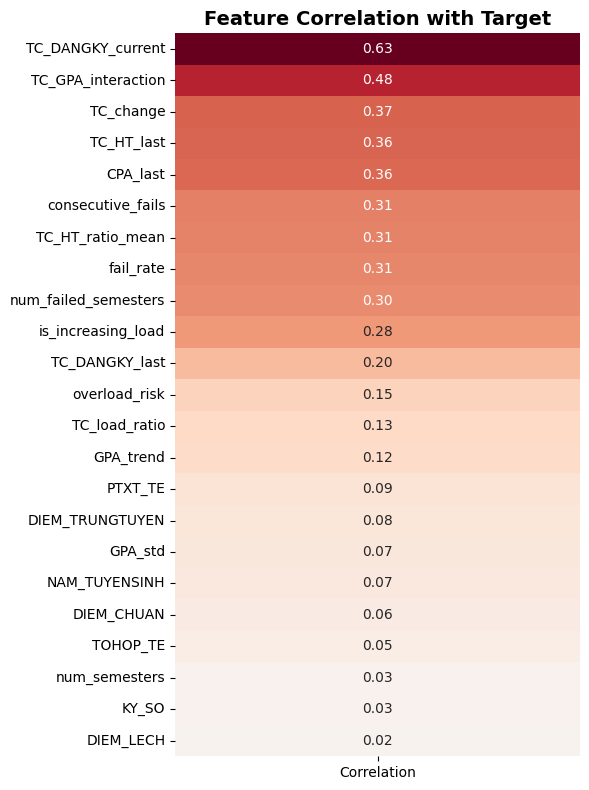

In [59]:
print("\nPlotting Feature vs Target Correlation")

target_corr_df = (
    target_corr[selected_features]
    .sort_values(ascending=False)
    .to_frame(name='Correlation')
)

plt.figure(figsize=(6, max(8, len(target_corr_df) * 0.3)))
sns.heatmap(
    target_corr_df,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    cbar=False
)
plt.title('Feature Correlation with Target', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



Plotting Feature Correlation Heatmap


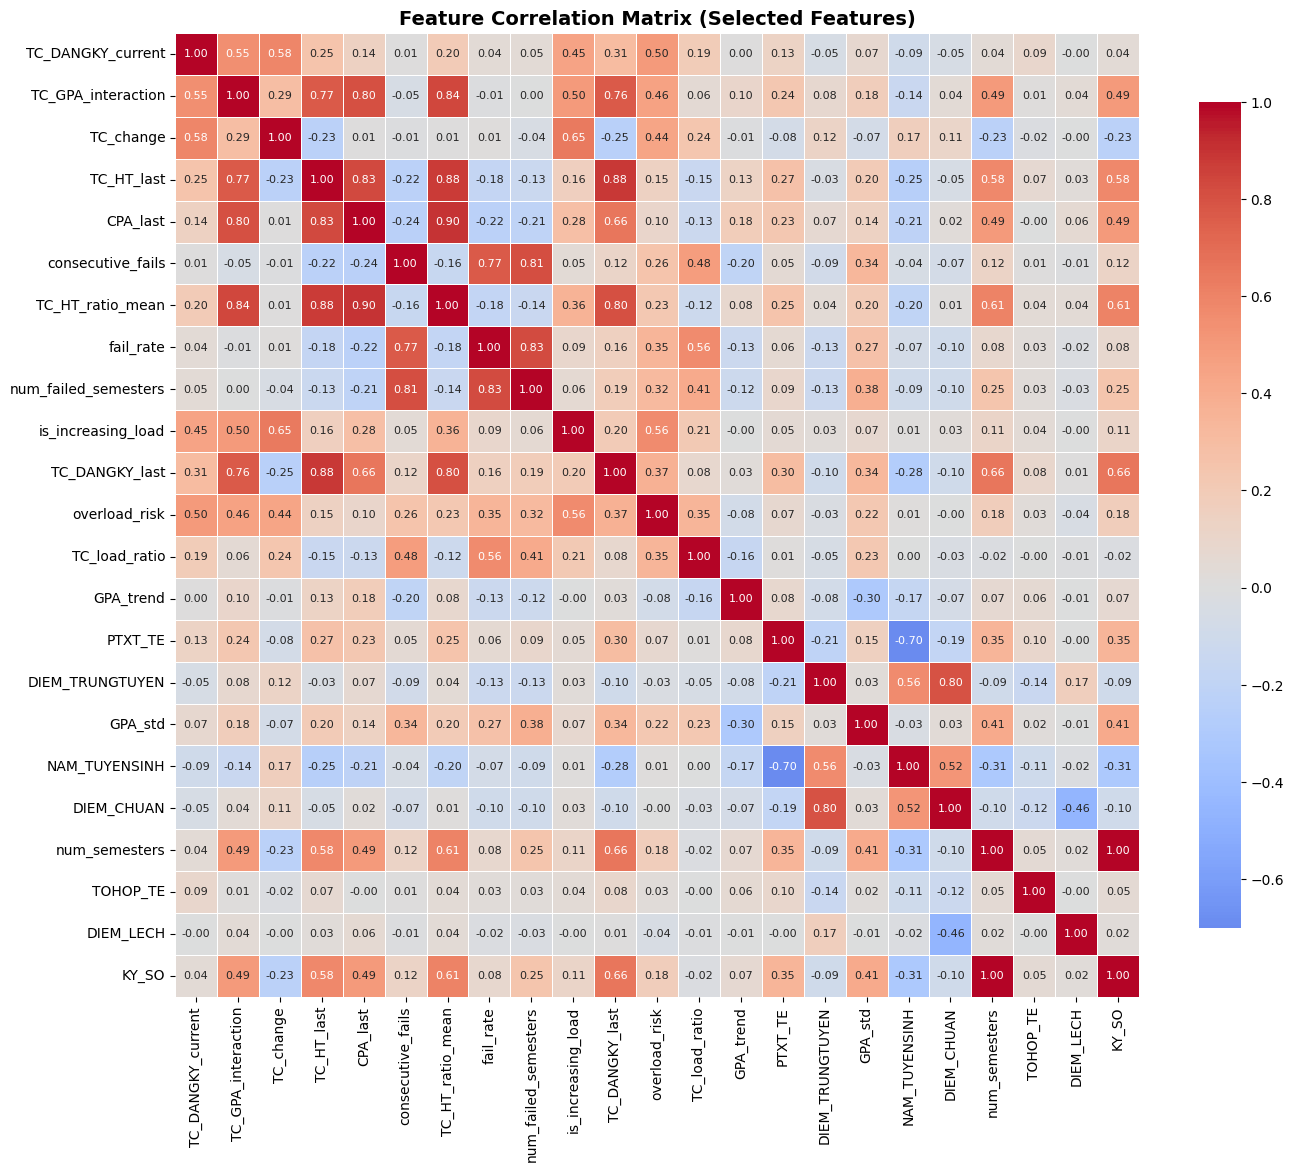

In [57]:
print("\nPlotting Feature Correlation Heatmap")

corr_selected = df_train_enc[selected_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_selected,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True,
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.8}
)
plt.title('Feature Correlation Matrix (Selected Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.5 Prepare Data for Modeling

In [60]:
print("PREPARING DATA FOR MODELING")

# Prepare train
X_train = df_train_enc[selected_features].copy()
y_train = df_train_enc['TC_HOANTHANH'].copy()

# Prepare val
X_val = df_val_enc[selected_features].copy()
y_val = df_val_enc['TC_HOANTHANH'].copy()

# Prepare test
X_test = df_test_enc[selected_features].copy()

print(f"\nData prepared:")
print(f"   Train: {X_train.shape}")
print(f"   Val:   {X_val.shape}")
print(f"   Test:  {X_test.shape}")

PREPARING DATA FOR MODELING

Data prepared:
   Train: (90582, 23)
   Val:   (15144, 23)
   Test:  (16502, 23)


In [61]:
# Fill NaN with 0
train_nan = X_train.isnull().sum().sum()
val_nan = X_val.isnull().sum().sum()
test_nan = X_test.isnull().sum().sum()

if train_nan > 0:
    print(f"\nTrain has {train_nan} NaN - filling with 0")
    X_train = X_train.fillna(0)

if val_nan > 0:
    print(f"Val has {val_nan} NaN - filling with 0")
    X_val = X_val.fillna(0)

if test_nan > 0:
    print(f"Test has {test_nan} NaN - filling with 0")
    X_test = X_test.fillna(0)

# 4. MODEL TUNING & TRAINING

## 4.1 Define Parameter Grid for Tuning

In [62]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import time

print("=" * 80)
print("HYPERPARAMETER TUNING")
print("=" * 80)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

# Smaller grid for faster tuning (recommended)
param_grid_small = {
    'n_estimators': [150, 200, 250],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

print("\nParameter Grid (Small - Recommended for speed):")
for param, values in param_grid_small.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid_small.values()])
print(f"\n Total combinations to test: {total_combinations}")

HYPERPARAMETER TUNING

Parameter Grid (Small - Recommended for speed):
  n_estimators: [150, 200, 250]
  max_depth: [5, 6, 7]
  learning_rate: [0.03, 0.05, 0.07]
  subsample: [0.8]
  colsample_bytree: [0.8]

 Total combinations to test: 27


## 4.2 Perform Grid Search with Cross-Validation

In [63]:
print("\n" + "=" * 80)
print("STARTING GRID SEARCH")
print("=" * 80)

# Base model
base_model = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid_small,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Use RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit grid search
start_time = time.time()
print(f"\nStarting training at {time.strftime('%H:%M:%S')}")
print(f"Training on {len(X_train):,} samples with 3-fold CV...")

grid_search.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

elapsed_time = time.time() - start_time
print(f"\nGrid search completed in {elapsed_time/60:.2f} minutes")


STARTING GRID SEARCH

Starting training at 15:39:10
Training on 90,582 samples with 3-fold CV...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/khanhtty/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/khanhtty/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain fea

[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=150, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=150, subsample=0.8; total time=   8.1s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=150, subsample=0.8; total time=   9.0s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=200, subsample=0.8; total time=   9.7s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=200, subsample=0.8; total time=   9.6s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=250, subsample=0.8; total time=   9.0s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=250, subsample=0.8; total time=   8.7s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=200, subsample=0.8; total time=  11.0s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=6, n_estima

## 4.3 Analyze Tuning Results


In [64]:
print("\n" + "=" * 80)
print("TUNING RESULTS")
print("=" * 80)

# Best parameters
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score (RMSE): {np.sqrt(-grid_search.best_score_):.4f}")

# Create results dataframe
cv_results = pd.DataFrame(grid_search.cv_results_)

# Sort by test score
cv_results_sorted = cv_results.sort_values('rank_test_score')

# Display top 10 configurations
print("\nTop 10 Configurations:")
display_cols = ['rank_test_score', 'mean_test_score', 'std_test_score', 
                'mean_train_score', 'std_train_score', 
                'param_n_estimators', 'param_max_depth', 'param_learning_rate']

top_10 = cv_results_sorted[display_cols].head(10).copy()
top_10['mean_test_rmse'] = np.sqrt(-top_10['mean_test_score'])
top_10['mean_train_rmse'] = np.sqrt(-top_10['mean_train_score'])

print(top_10[['rank_test_score', 'mean_test_rmse', 'mean_train_rmse', 
              'param_n_estimators', 'param_max_depth', 'param_learning_rate']])


TUNING RESULTS

Best Parameters:
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 7
  n_estimators: 250
  subsample: 0.8

Best CV Score (RMSE): 3.6938

Top 10 Configurations:
    rank_test_score  mean_test_rmse  mean_train_rmse param_n_estimators  \
17                1        3.693828         3.228907                250   
8                 2        3.693839         3.369802                250   
25                3        3.694179         3.186935                200   
16                4        3.695322         3.296868                200   
24                5        3.695915         3.278054                150   
26                6        3.696577         3.100706                250   
23                7        3.700133         3.327039                250   
7                 8        3.700820         3.422009                200   
15                9        3.702426         3.374748                150   
22               10        3.702820         3.390060            

## 4.4 Visualize Tuning Results

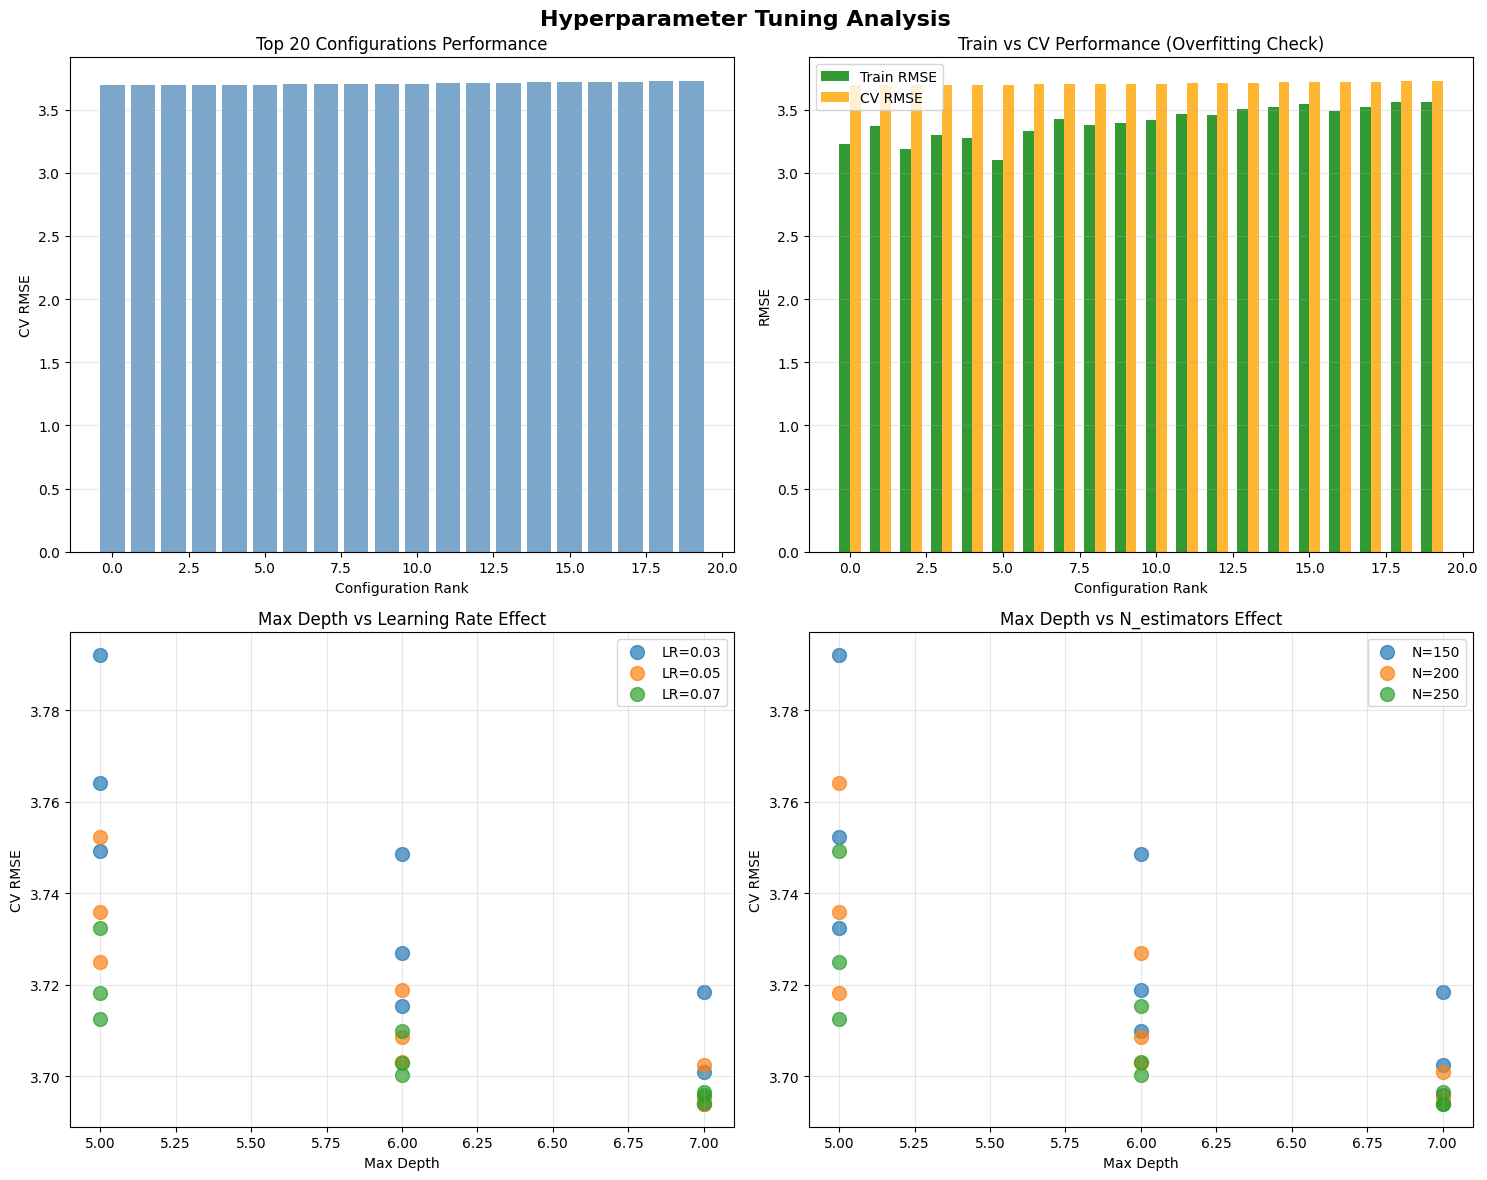

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Hyperparameter Tuning Analysis', fontsize=16, fontweight='bold')

# 1. CV Score vs Parameters
ax1 = axes[0, 0]
top_20 = cv_results_sorted.head(20)
x_pos = np.arange(len(top_20))
ax1.bar(x_pos, np.sqrt(-top_20['mean_test_score']), alpha=0.7, color='steelblue')
ax1.set_xlabel('Configuration Rank')
ax1.set_ylabel('CV RMSE')
ax1.set_title('Top 20 Configurations Performance')
ax1.grid(axis='y', alpha=0.3)

# 2. Train vs Validation Score (Overfitting Check)
ax2 = axes[0, 1]
train_rmse = np.sqrt(-cv_results_sorted.head(20)['mean_train_score'])
test_rmse = np.sqrt(-cv_results_sorted.head(20)['mean_test_score'])
x_pos = np.arange(len(train_rmse))
width = 0.35
ax2.bar(x_pos - width/2, train_rmse, width, label='Train RMSE', alpha=0.8, color='green')
ax2.bar(x_pos + width/2, test_rmse, width, label='CV RMSE', alpha=0.8, color='orange')
ax2.set_xlabel('Configuration Rank')
ax2.set_ylabel('RMSE')
ax2.set_title('Train vs CV Performance (Overfitting Check)')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Learning Rate Effect
ax3 = axes[1, 0]
for lr in cv_results['param_learning_rate'].unique():
    subset = cv_results[cv_results['param_learning_rate'] == lr]
    ax3.scatter(subset['param_max_depth'], 
               np.sqrt(-subset['mean_test_score']), 
               label=f'LR={lr}', s=100, alpha=0.7)
ax3.set_xlabel('Max Depth')
ax3.set_ylabel('CV RMSE')
ax3.set_title('Max Depth vs Learning Rate Effect')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. N_estimators Effect
ax4 = axes[1, 1]
for n_est in cv_results['param_n_estimators'].unique():
    subset = cv_results[cv_results['param_n_estimators'] == n_est]
    ax4.scatter(subset['param_max_depth'], 
               np.sqrt(-subset['mean_test_score']), 
               label=f'N={n_est}', s=100, alpha=0.7)
ax4.set_xlabel('Max Depth')
ax4.set_ylabel('CV RMSE')
ax4.set_title('Max Depth vs N_estimators Effect')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.5 Model Stability Analysis (Cross-Validation)


MODEL STABILITY ANALYSIS

5-Fold Cross-Validation Results:

Test RMSE:  3.6793 ± 0.0211
Train RMSE: 3.2729 ± 0.0088

Test MAE:   2.5413 ± 0.0073
Train MAE:  2.2892 ± 0.0068

Test R²:    0.6610 ± 0.0078
Train R²:   0.7319 ± 0.0018

Stability Check:
Model is STABLE (std=0.0211 < 0.5)

Overfitting Check:
  Train-Test Gap: -0.4064
No significant overfitting


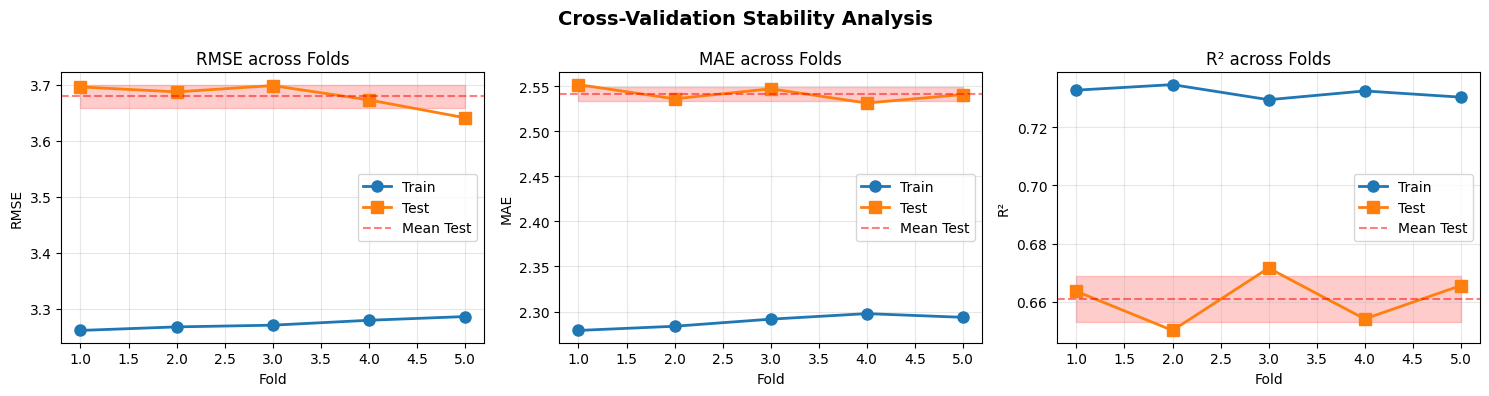

In [66]:
print("\n" + "=" * 80)
print("MODEL STABILITY ANALYSIS")
print("=" * 80)

# Get best model
best_model = grid_search.best_estimator_

# Perform detailed cross-validation
from sklearn.model_selection import cross_validate

cv_scores = cross_validate(
    best_model,
    X_train,
    y_train,
    cv=5,  # 5-fold CV for stability check
    scoring={
        'neg_mse': 'neg_mean_squared_error',
        'neg_mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    },
    return_train_score=True,
    n_jobs=-1
)
# Calculate RMSE and MAE
cv_test_rmse = np.sqrt(-cv_scores['test_neg_mse'])
cv_train_rmse = np.sqrt(-cv_scores['train_neg_mse'])
cv_test_mae = -cv_scores['test_neg_mae']
cv_train_mae = -cv_scores['train_neg_mae']
cv_test_r2 = cv_scores['test_r2']
cv_train_r2 = cv_scores['train_r2']

print("\n5-Fold Cross-Validation Results:")
print(f"\nTest RMSE:  {cv_test_rmse.mean():.4f} ± {cv_test_rmse.std():.4f}")
print(f"Train RMSE: {cv_train_rmse.mean():.4f} ± {cv_train_rmse.std():.4f}")
print(f"\nTest MAE:   {cv_test_mae.mean():.4f} ± {cv_test_mae.std():.4f}")
print(f"Train MAE:  {cv_train_mae.mean():.4f} ± {cv_train_mae.std():.4f}")
print(f"\nTest R²:    {cv_test_r2.mean():.4f} ± {cv_test_r2.std():.4f}")
print(f"Train R²:   {cv_train_r2.mean():.4f} ± {cv_train_r2.std():.4f}")

# Stability check
print("\nStability Check:")
if cv_test_rmse.std() < 0.5:
    print(f"Model is STABLE (std={cv_test_rmse.std():.4f} < 0.5)")
else:
    print(f"Model has HIGH VARIANCE (std={cv_test_rmse.std():.4f} >= 0.5)")


# Overfitting check
overfit_gap = cv_train_rmse.mean() - cv_test_rmse.mean()
print(f"\nOverfitting Check:")
print(f"  Train-Test Gap: {overfit_gap:.4f}")
if abs(overfit_gap) < 1.0:
    print(f"No significant overfitting")
elif overfit_gap < 0:
    print(f"Test performs better than train (unusual)")
else:
    print(f"Possible overfitting detected")

# Visualize CV scores
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Cross-Validation Stability Analysis', fontsize=14, fontweight='bold')

# RMSE
ax1 = axes[0]
ax1.plot(range(1, 6), cv_train_rmse, 'o-', label='Train', linewidth=2, markersize=8)
ax1.plot(range(1, 6), cv_test_rmse, 's-', label='Test', linewidth=2, markersize=8)
ax1.axhline(cv_test_rmse.mean(), color='red', linestyle='--', alpha=0.5, label='Mean Test')
ax1.fill_between(range(1, 6), 
                 cv_test_rmse.mean() - cv_test_rmse.std(),
                 cv_test_rmse.mean() + cv_test_rmse.std(),
                 alpha=0.2, color='red')
ax1.set_xlabel('Fold')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE across Folds')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE
ax2 = axes[1]
ax2.plot(range(1, 6), cv_train_mae, 'o-', label='Train', linewidth=2, markersize=8)
ax2.plot(range(1, 6), cv_test_mae, 's-', label='Test', linewidth=2, markersize=8)
ax2.axhline(cv_test_mae.mean(), color='red', linestyle='--', alpha=0.5, label='Mean Test')
ax2.fill_between(range(1, 6), 
                 cv_test_mae.mean() - cv_test_mae.std(),
                 cv_test_mae.mean() + cv_test_mae.std(),
                 alpha=0.2, color='red')
ax2.set_xlabel('Fold')
ax2.set_ylabel('MAE')
ax2.set_title('MAE across Folds')
ax2.legend()
ax2.grid(True, alpha=0.3)

# R²
ax3 = axes[2]
ax3.plot(range(1, 6), cv_train_r2, 'o-', label='Train', linewidth=2, markersize=8)
ax3.plot(range(1, 6), cv_test_r2, 's-', label='Test', linewidth=2, markersize=8)
ax3.axhline(cv_test_r2.mean(), color='red', linestyle='--', alpha=0.5, label='Mean Test')
ax3.fill_between(range(1, 6), 
                 cv_test_r2.mean() - cv_test_r2.std(),
                 cv_test_r2.mean() + cv_test_r2.std(),
                 alpha=0.2, color='red')
ax3.set_xlabel('Fold')
ax3.set_ylabel('R²')
ax3.set_title('R² across Folds')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.6 Train Final Model with Best Parameters


In [67]:
print("\n" + "=" * 80)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("=" * 80)

# Get best parameters
best_params = grid_search.best_params_.copy()
best_params['random_state'] = 42
best_params['n_jobs'] = -1

print(f"\nFinal Parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# Train final model
model = XGBRegressor(**best_params)

print(f"\nTraining on {len(X_train):,} samples...")
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

print("Training completed!")


TRAINING FINAL MODEL WITH BEST PARAMETERS

Final Parameters:
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 7
  n_estimators: 250
  subsample: 0.8
  random_state: 42
  n_jobs: -1

Training on 90,582 samples...


Training completed!


# 5. EVALUATION & SUBMISSION

## 5.1 Evaluate Model

In [68]:
print("=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

# Predict
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

# Calculate metrics
def calc_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Accuracy within threshold
    acc_1 = np.mean(np.abs(y_true - y_pred) <= 1) * 100
    acc_2 = np.mean(np.abs(y_true - y_pred) <= 2) * 100
    
    print(f"\n{name}:")
    print(f"  MAE:   {mae:.3f}")
    print(f"  RMSE:  {rmse:.3f}")
    print(f"  R²:    {r2:.3f}")
    print(f"  Acc (±1 credit): {acc_1:.1f}%")
    print(f"  Acc (±2 credits): {acc_2:.1f}%")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'acc_1': acc_1,
        'acc_2': acc_2
    }

metrics_train = calc_metrics(y_train, y_pred_train, "TRAIN")
metrics_val = calc_metrics(y_val, y_pred_val, "VALIDATION")

# Check overfitting
print(f"\nOverfitting Check:")
diff = metrics_val['rmse'] - metrics_train['rmse']
print(f"  RMSE difference: {diff:.3f}")
if diff > 2.0:
    print(f"Possible overfitting")
elif diff < 0:
    print(f"Unusual pattern")
else:
    print(f"Model looks good!")

# Compare with CV results
print(f"\nComparison with Cross-Validation:")
print(f"  CV RMSE:         {cv_test_rmse.mean():.3f} ± {cv_test_rmse.std():.3f}")
print(f"  Validation RMSE: {metrics_val['rmse']:.3f}")
if abs(metrics_val['rmse'] - cv_test_rmse.mean()) < cv_test_rmse.std():
    print(f"  Consistent with CV results")
else:
    print(f"  Differs from CV results")



MODEL EVALUATION



TRAIN:
  MAE:   2.318
  RMSE:  3.317
  R²:    0.725
  Acc (±1 credit): 34.0%
  Acc (±2 credits): 58.1%

VALIDATION:
  MAE:   2.649
  RMSE:  3.804
  R²:    0.694
  Acc (±1 credit): 32.6%
  Acc (±2 credits): 53.8%

Overfitting Check:
  RMSE difference: 0.487
Model looks good!

Comparison with Cross-Validation:
  CV RMSE:         3.679 ± 0.021
  Validation RMSE: 3.804
  Differs from CV results


## 5.2 Comprehensive Results

In [83]:
print("\n" + "="*80)
print("SAVING COMPREHENSIVE RESULTS FOR REPORT")
print("="*80)

# Create output directories
RESULTS_DIR = './outputs'
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(f'{RESULTS_DIR}/plots', exist_ok=True)
os.makedirs(f'{RESULTS_DIR}/metrics', exist_ok=True)
os.makedirs(f'{RESULTS_DIR}/explainability', exist_ok=True)



SAVING COMPREHENSIVE RESULTS FOR REPORT


***SAVE ALL METRICS***

In [87]:
print("\nSaving Metrics...")

def save_all_metrics(y_true, y_pred, name, folder):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE
    mask = y_true != 0
    mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100 if mask.any() else 0
    
    # Accuracy
    acc_1 = np.mean(np.abs(y_true - y_pred) <= 1) * 100
    acc_2 = np.mean(np.abs(y_true - y_pred) <= 2) * 100
    acc_3 = np.mean(np.abs(y_true - y_pred) <= 3) * 100
    
    metrics = {
        'dataset': name,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'MAE': float(mae),
        'MSE': float(mse),
        'RMSE': float(rmse),
        'R2': float(r2),
        'MAPE': float(mape),
        'Accuracy_within_1': float(acc_1),
        'Accuracy_within_2': float(acc_2),
        'Accuracy_within_3': float(acc_3),
        'n_samples': int(len(y_true)),
    }
    
    # Save JSON & CSV
    with open(f'{folder}/metrics_{name}.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    pd.DataFrame([metrics]).to_csv(f'{RESULTS_DIR}/metrics/metrics_{name}.csv', index=False)
    
    print(f"   Saved metrics_{name}.json and .csv")
    return metrics

# SỬA THÀNH:
metrics_train = save_all_metrics(y_train, y_pred_train, 'train', f'{RESULTS_DIR}/metrics')
metrics_val = save_all_metrics(y_val, y_pred_val, 'validation', f'{RESULTS_DIR}/metrics')


Saving Metrics...
   Saved metrics_train.json and .csv
   Saved metrics_validation.json and .csv


***FEATURE IMPORTANCE (XGBoost built-in)***


 Saving Feature Importance...


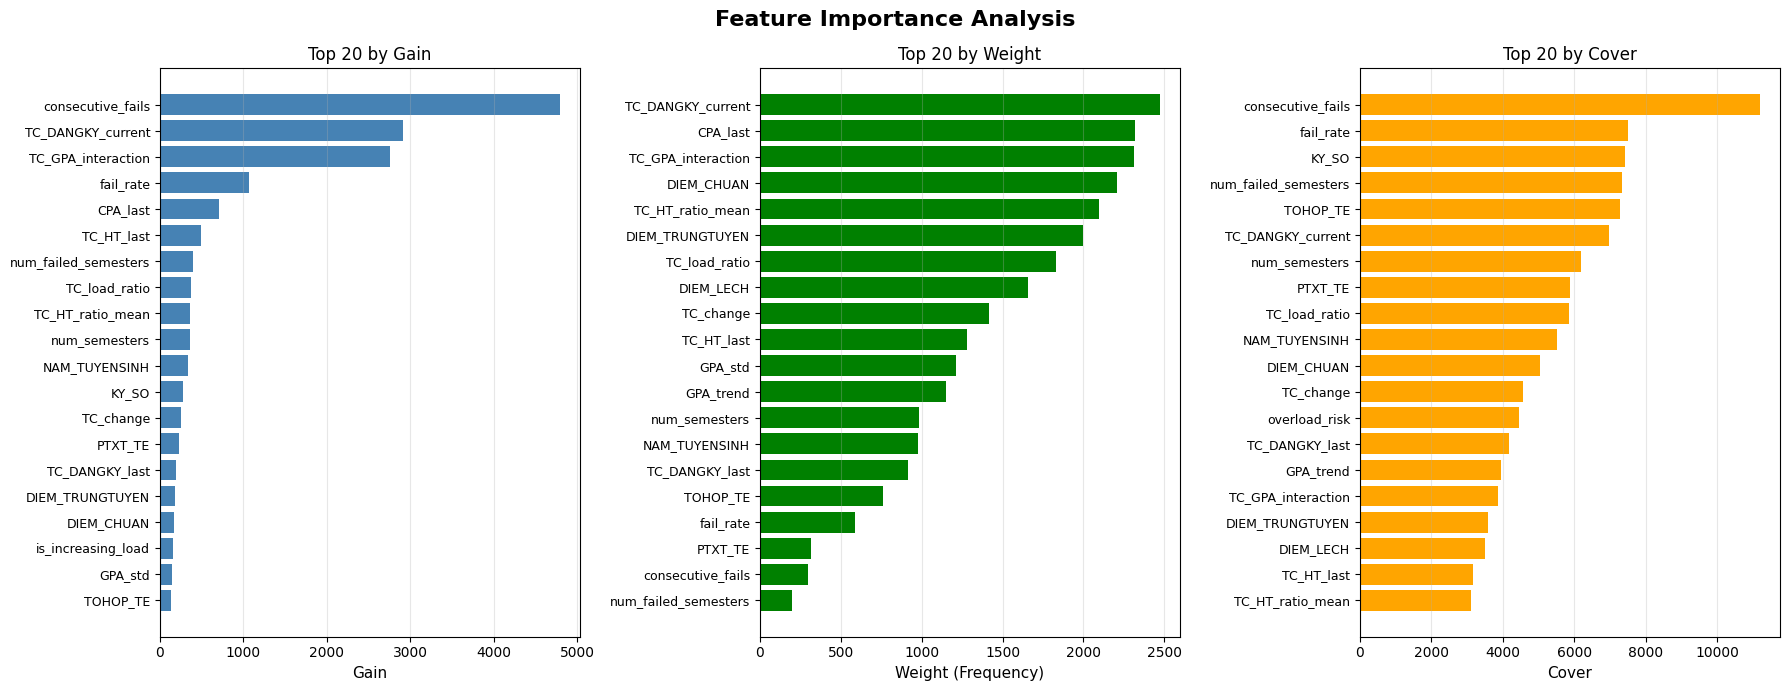

   Saved feature_importance.csv and .png


In [89]:
print("\n Saving Feature Importance...")

importance_gain = model.get_booster().get_score(importance_type='gain')
importance_weight = model.get_booster().get_score(importance_type='weight')
importance_cover = model.get_booster().get_score(importance_type='cover')

importance_df = pd.DataFrame({
    'feature': list(importance_gain.keys()),
    'gain': list(importance_gain.values()),
    'weight': [importance_weight.get(k, 0) for k in importance_gain.keys()],
    'cover': [importance_cover.get(k, 0) for k in importance_gain.keys()],
}).sort_values('gain', ascending=False)


importance_df.to_csv(f'{RESULTS_DIR}/metrics/feature_importance.csv', index=False)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 7))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

top_n = min(20, len(importance_df))

# Gain
top_gain = importance_df.nlargest(top_n, 'gain')
axes[0].barh(range(top_n), top_gain['gain'].values, color='steelblue')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_gain['feature'].values, fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel('Gain', fontsize=11)
axes[0].set_title('Top 20 by Gain', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Weight
top_weight = importance_df.nlargest(top_n, 'weight')
axes[1].barh(range(top_n), top_weight['weight'].values, color='green')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(top_weight['feature'].values, fontsize=9)
axes[1].invert_yaxis()
axes[1].set_xlabel('Weight (Frequency)', fontsize=11)
axes[1].set_title('Top 20 by Weight', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

# Cover
top_cover = importance_df.nlargest(top_n, 'cover')
axes[2].barh(range(top_n), top_cover['cover'].values, color='orange')
axes[2].set_yticks(range(top_n))
axes[2].set_yticklabels(top_cover['feature'].values, fontsize=9)
axes[2].invert_yaxis()
axes[2].set_xlabel('Cover', fontsize=11)
axes[2].set_title('Top 20 by Cover', fontsize=12)
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/plots/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("   Saved feature_importance.csv and .png")

SHAP VALUES

In [91]:
plt.savefig(f'{RESULTS_DIR}/plots/shap_summary_bar.png', dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>


Calculating SHAP Values (Kernel SHAP)...


  0%|          | 0/200 [00:00<?, ?it/s]

   Saved shap_values.csv


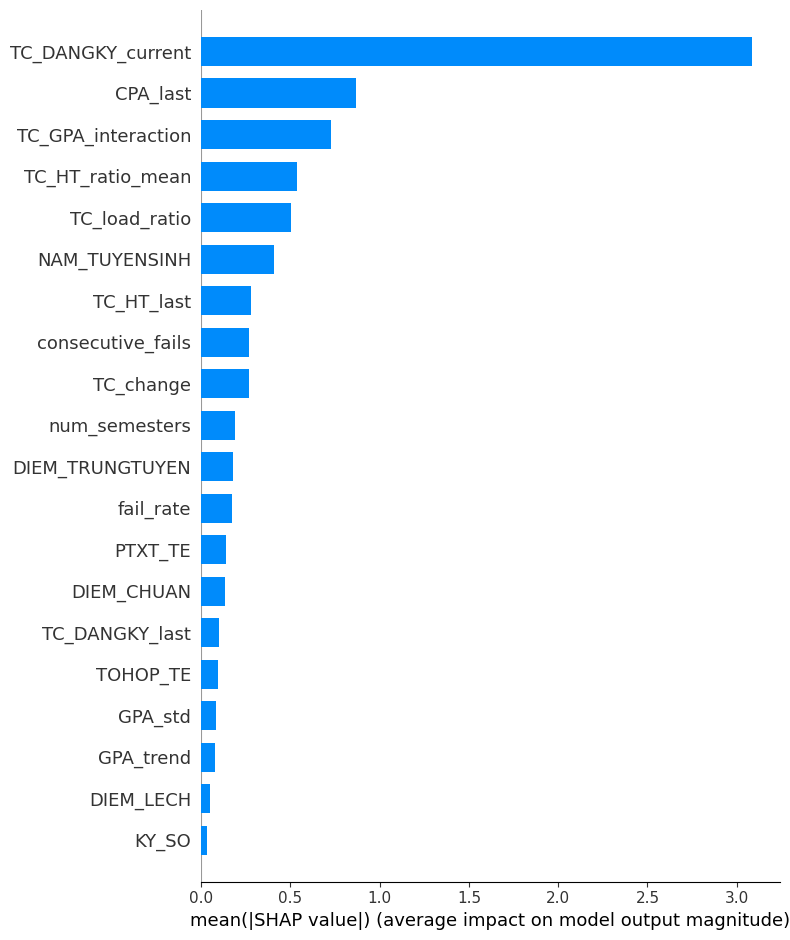

    Saved shap_summary_bar.png


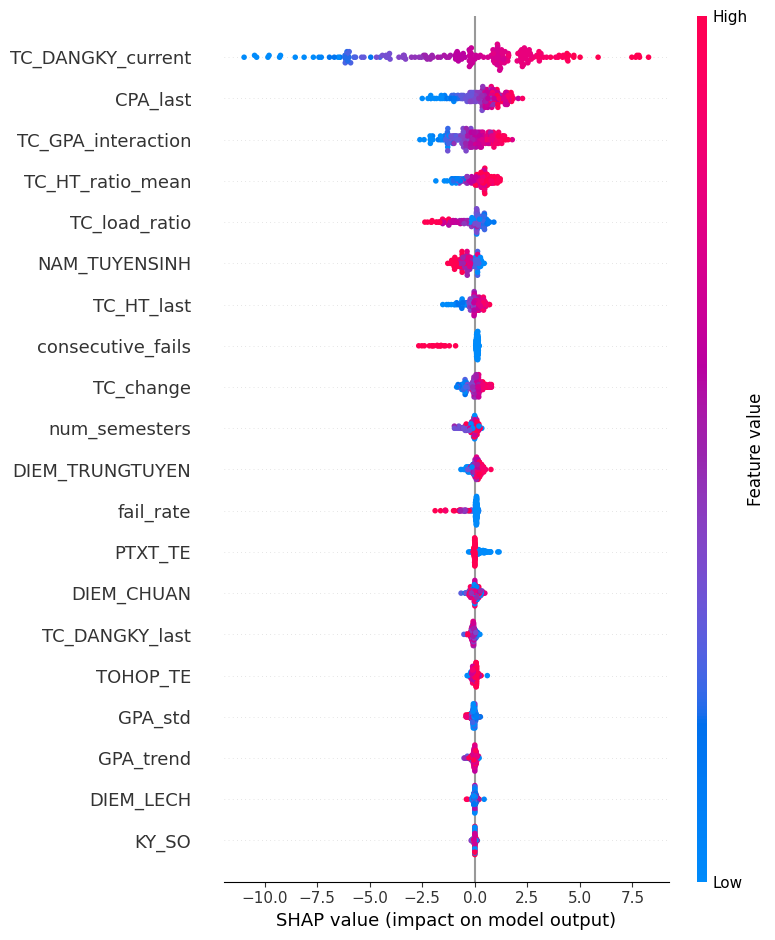

    Saved shap_summary_beeswarm.png


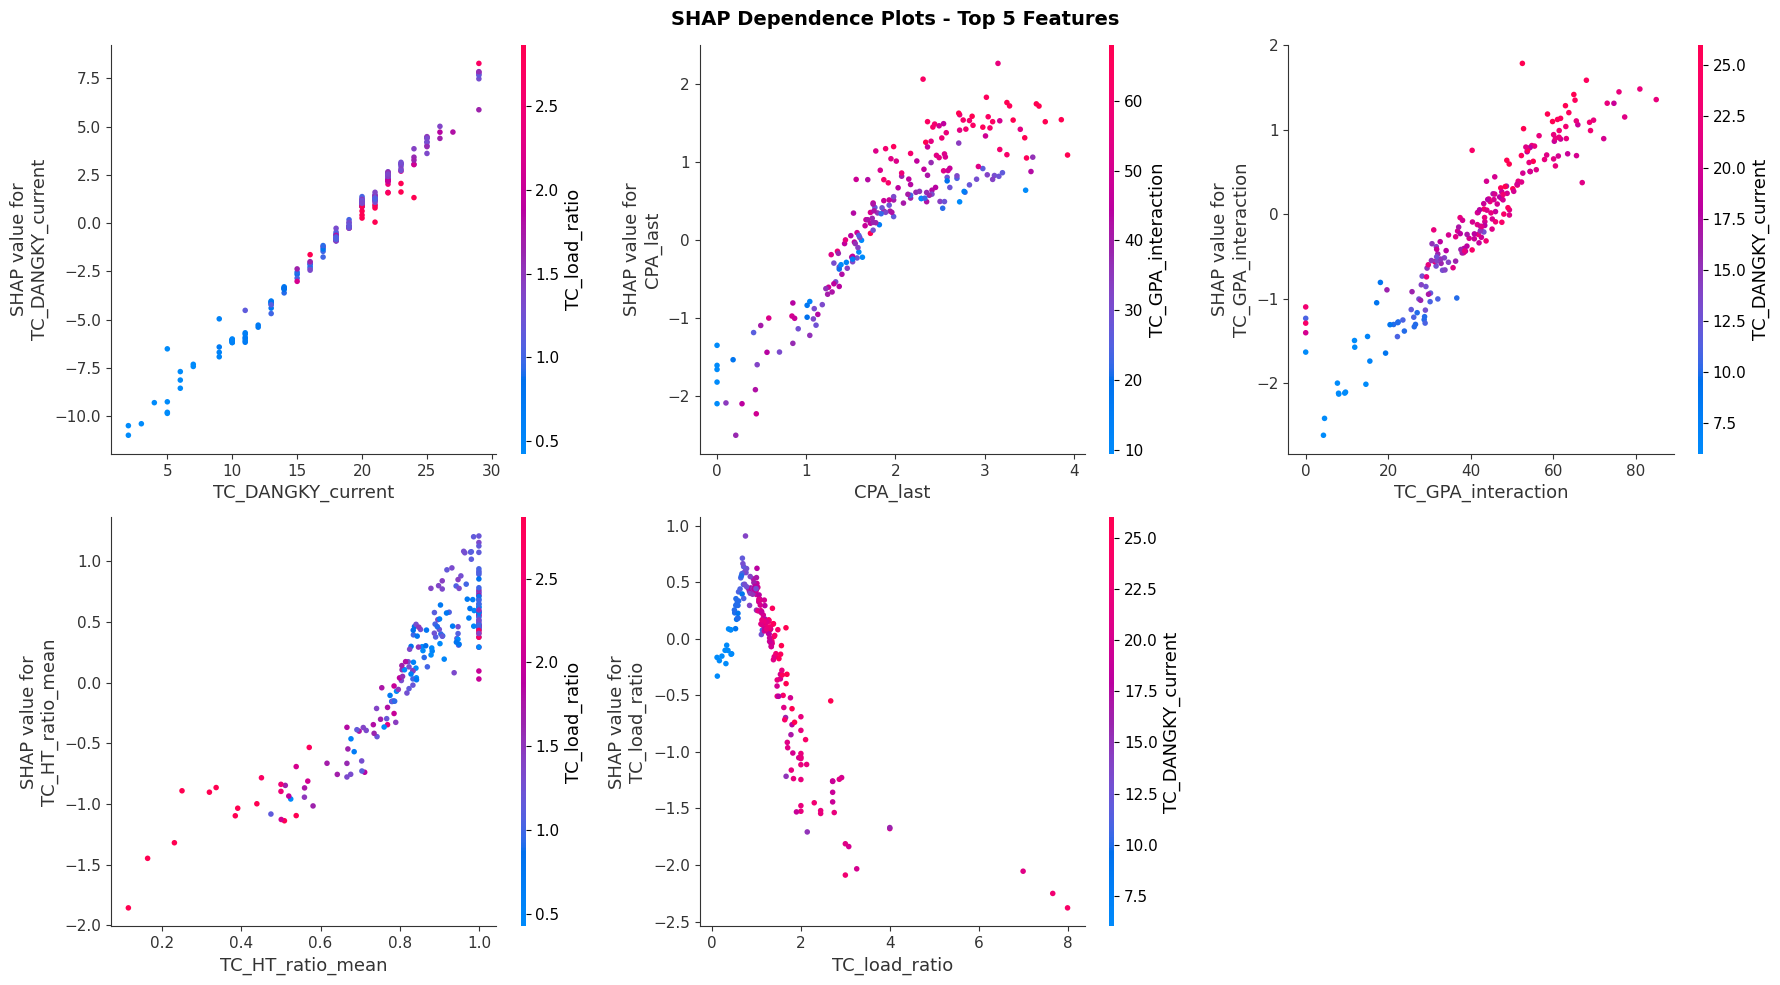

    Saved shap_dependence_plots.png
    Saved shap_feature_importance.csv


In [72]:
print("\nCalculating SHAP Values (Kernel SHAP)...")

# Wrapper predict (BẮT BUỘC)

def model_predict(X):
    if isinstance(X, pd.DataFrame):
        return model.predict(X)
    else:
        return model.predict(pd.DataFrame(X, columns=selected_features))


# Background & SHAP sample

background = shap.sample(
    X_train,
    min(100, len(X_train)),
    random_state=42
)

shap_sample_size = min(200, len(X_val))
shap_idx = np.random.choice(len(X_val), shap_sample_size, replace=False)
X_shap = X_val.iloc[shap_idx]


# Kernel SHAP
explainer = shap.KernelExplainer(
    model_predict,
    background
)

shap_values = explainer.shap_values(X_shap)

# Regression safeguard
if isinstance(shap_values, list):
    shap_values = shap_values[0]

shap_df = pd.DataFrame(shap_values, columns=selected_features)
shap_df.to_csv(f'{RESULTS_DIR}/explainability/shap_values.csv', index=False)
print("   Saved shap_values.csv")


# SHAP SUMMARY PLOTS


# Bar plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    show=False
)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/plots/shap_summary_bar.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("    Saved shap_summary_bar.png")
# Beeswarm plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_shap,
    show=False
)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/plots/shap_summary_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("    Saved shap_summary_beeswarm.png")


# SHAP DEPENDENCE PLOTS (Top 5)
shap_importance = np.abs(shap_values).mean(axis=0)
top_5_idx = np.argsort(shap_importance)[-5:][::-1]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(
    'SHAP Dependence Plots - Top 5 Features',
    fontsize=14,
    fontweight='bold'
)
for i, idx in enumerate(top_5_idx):
    row, col = i // 3, i % 3
    feature_name = X_shap.columns[idx]

    shap.dependence_plot(
        feature_name,
        shap_values,
        X_shap,
        ax=axes[row, col],
        show=False
    )

axes[1, 2].axis('off')
plt.tight_layout()
plt.show()
plt.savefig(f'{RESULTS_DIR}/plots/shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.close()
print("    Saved shap_dependence_plots.png")


# MEAN SHAP FEATURE IMPORTANCE
mean_shap_df = (
    pd.DataFrame({
        'feature': X_shap.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    })
    .sort_values('mean_abs_shap', ascending=False)
)

mean_shap_df.to_csv(
    f'{RESULTS_DIR}/metrics/shap_feature_importance.csv',
    index=False
)
print("    Saved shap_feature_importance.csv")

***LIME EXPLANATIONS***


 Generating LIME Explanations...


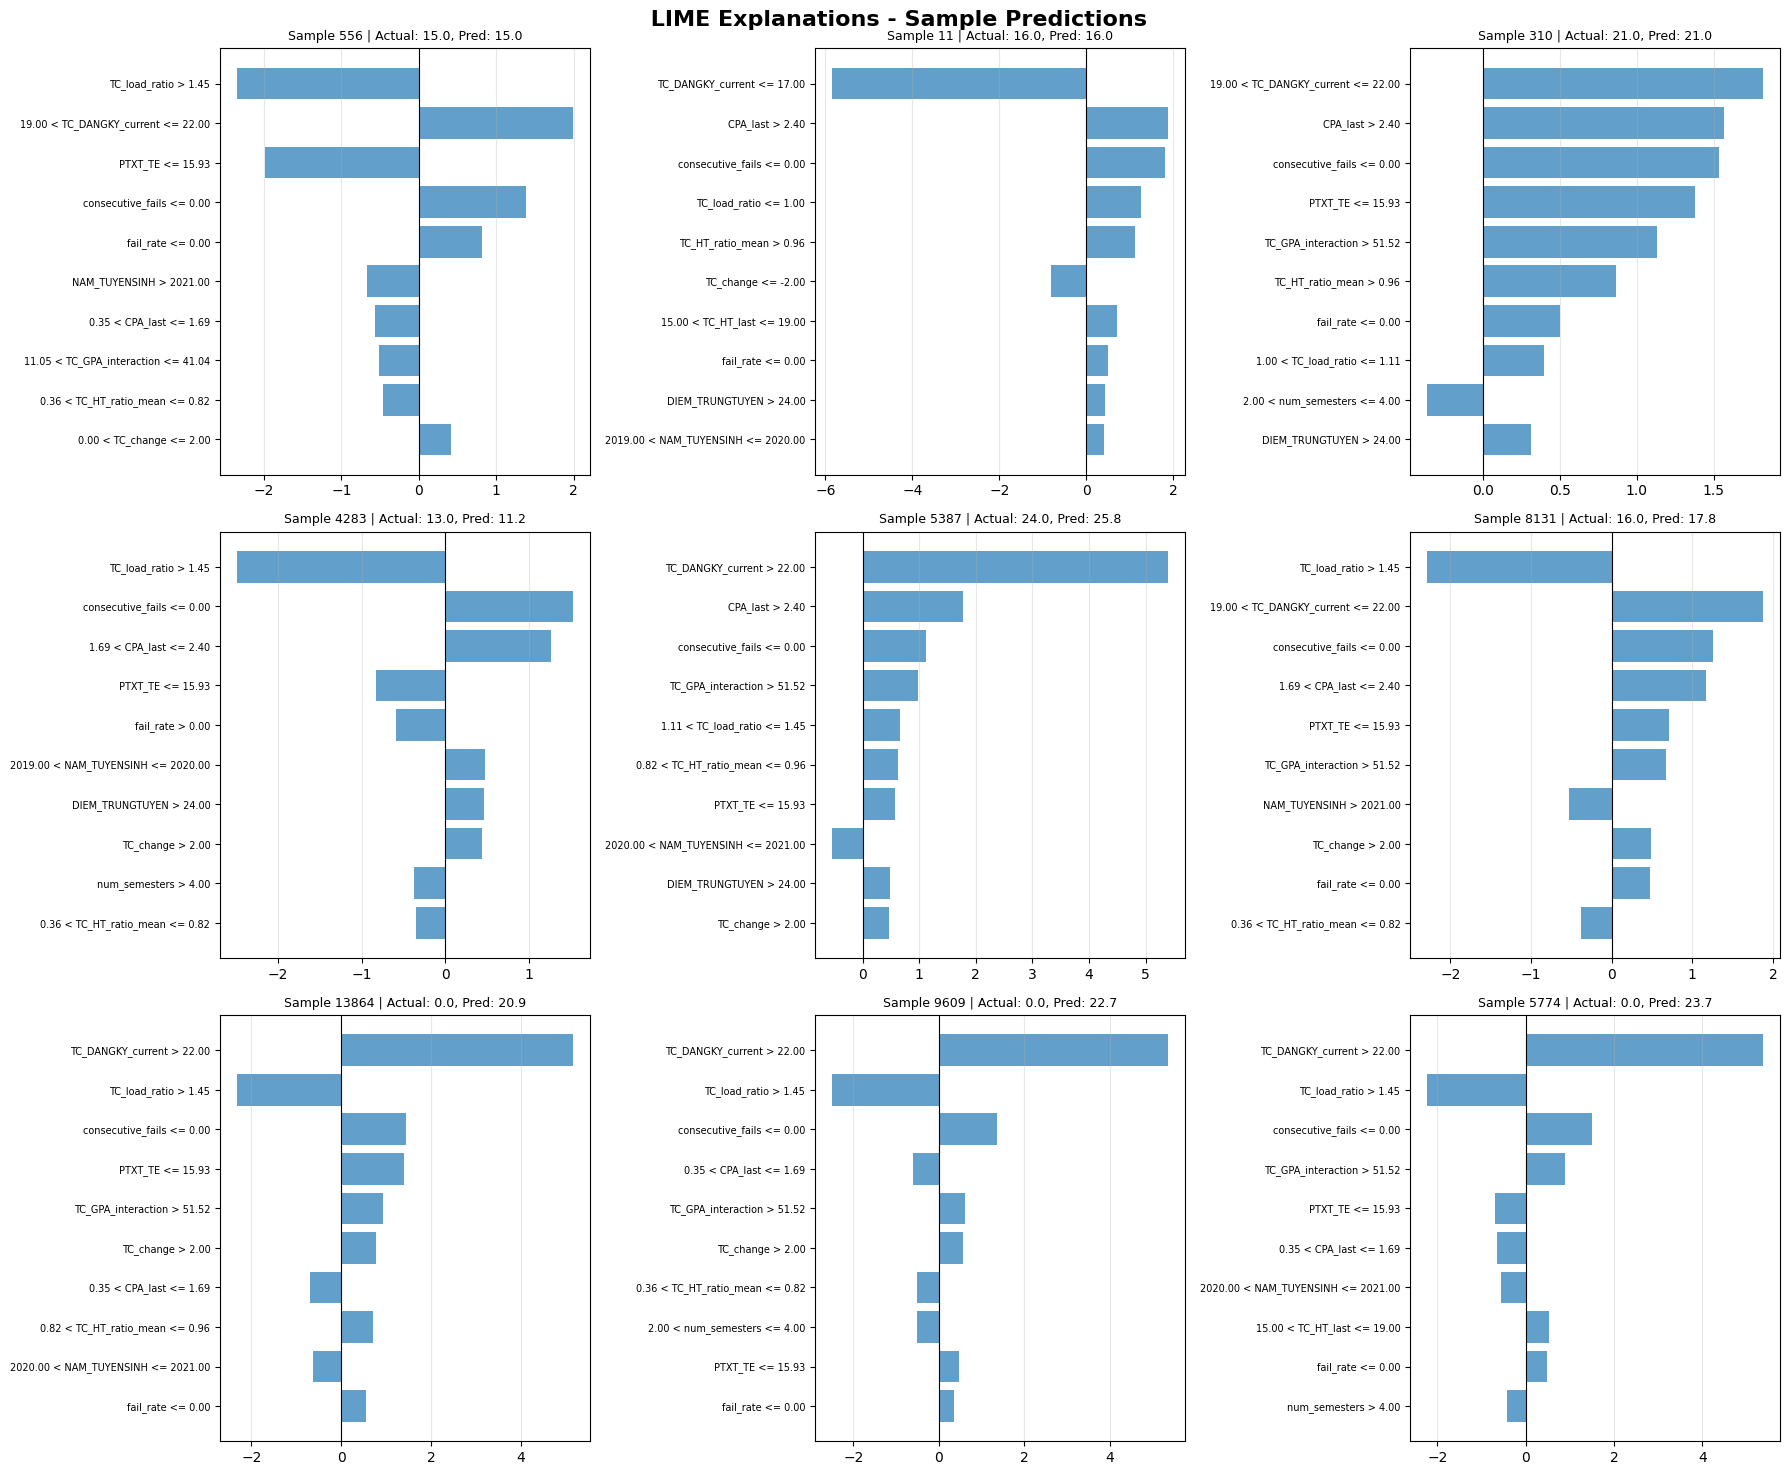

    Saved lime_explanations.json and .png


In [94]:
print("\n Generating LIME Explanations...")

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode='regression',
    verbose=False
)

# Select 9 diverse samples
val_preds = model.predict(X_val)
errors = np.abs(val_preds - y_val)

best_idx = np.argsort(errors)[:3] # 3 best 
median_idx = np.argsort(np.abs(errors - np.median(errors)))[:3] # 3 median 
worst_idx = np.argsort(errors)[-3:] # 3 worst 

sample_indices = np.concatenate([best_idx, median_idx, worst_idx])

lime_results = []
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle(' LIME Explanations - Sample Predictions', fontsize=16, fontweight='bold')

for i, idx in enumerate(sample_indices):
    row, col = i // 3, i % 3
    ax = axes[row, col]

    exp = lime_explainer.explain_instance(
        data_row=X_val.iloc[idx].values,
        predict_fn=lambda x: model.predict(x),
        num_features=10
    )

    pred = val_preds[idx]
    actual = y_val.iloc[idx]

    exp_list = exp.as_list()
    lime_results.append({
        'sample_id': int(idx),
        'actual': float(actual),
        'predicted': float(pred),
        'error': float(actual - pred),
        'explanation': exp_list
    })

    features = [f[0] for f in exp_list]
    values = [f[1] for f in exp_list]
    colors = ['green' if v > 0 else 'red' for v in values]

    ax.barh(range(len(features)), values, alpha=0.7)
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features, fontsize=7)
    ax.invert_yaxis()
    ax.set_title(f'Sample {idx} | Actual: {actual:.1f}, Pred: {pred:.1f}', fontsize=9)
    ax.axvline(x=0, color='black', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/plots/lime_explanations.png', dpi=300, bbox_inches='tight')
plt.show()

with open(f'{RESULTS_DIR}/explainability/lime_explanations.json', 'w', encoding='utf-8') as f:
    json.dump(lime_results, f, indent=2, ensure_ascii=False)

print("    Saved lime_explanations.json and .png")

***PREDICTION ANALYSIS PLOTS***

In [ ]:
!pip install shap lime category_encoders

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
     |████████████████████████████████| 82 kB 120 kB/s eta 0:00:011
     |████████████████████████████████| 10.9 MB 332 kB/s eta 0:00:01    |████████████████████████████▉   | 9.8 MB 357 kB/s eta 0:00:04     |███████████████████████████████▍| 10.6 MB 335 kB/s eta 0:00:01     |███████████████████████████████▌| 10.7 MB 335 kB/s eta 0:00:01
     |████████████████████████████████| 233 kB 218 kB/s eta 0:00:01


In [ ]:
import os
import json
import re
import warnings
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

from xgboost import XGBRegressor
import category_encoders as ce

import shap
import lime
import lime.lime_tabular

warnings.filterwarnings('ignore')

In [ ]:
ACAD_PATH = "academic_records.csv"
ADM_PATH = "admission.csv"
TEST_PATH = "test.csv"

# Validation semester
VAL_SEMESTER = '20232'  # HK2 2023-2024

# Output directory
OUTPUT_DIR = './outputs'

# 1. DATA PROCESS

## 1.1 Load Data

In [ ]:
# Load academic records data
df_acad = pd.read_csv(ACAD_PATH)
print(f"Loaded academic records: {df_acad.shape}")

# Load admission data
df_adm = pd.read_csv(ADM_PATH)
print(f"Loaded admission data: {df_adm.shape}")

# Load test data
df_test_raw = pd.read_csv(TEST_PATH)
print(f"Loaded test data: {df_test_raw.shape}")

Loaded academic records: (105726, 6)
Loaded admission data: (30217, 6)
Loaded test data: (16502, 3)


## 1.2 Explore Data

In [ ]:
print("ACADEMIC DATA")
print(f"\nShape: {df_acad.shape}")
print(f"\nColumns:\n{df_acad.columns.tolist()}")
print(f"\nFirst few rows:")
display(df_acad.head())

ACADEMIC DATA

Shape: (105726, 6)

Columns:
['MA_SO_SV', 'HOC_KY', 'CPA', 'GPA', 'TC_DANGKY', 'TC_HOANTHANH']

First few rows:


MA_SO_SV         HOC_KY   CPA   GPA  TC_DANGKY  TC_HOANTHANH
0  f022ed8d1ac1  HK2 2020-2021  2.19  2.02         18            18
1  f022ed8d1ac1  HK1 2022-2023  0.95  2.12         14             7
2  f022ed8d1ac1  HK1 2023-2024  0.81  1.89         29            16
3  f022ed8d1ac1  HK2 2022-2023  1.37  1.93         26            23
4  f022ed8d1ac1  HK2 2023-2024  1.71  1.91         16            13

In [ ]:
print("ADMISSION DATA")
print(f"\nShape: {df_adm.shape}")
print(f"\nColumns:\n{df_adm.columns.tolist()}")
print(f"\nFirst few rows:")
display(df_adm.head())


ADMISSION DATA

Shape: (30217, 6)

Columns:
['MA_SO_SV', 'NAM_TUYENSINH', 'PTXT', 'TOHOP_XT', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']

First few rows:


MA_SO_SV  NAM_TUYENSINH PTXT TOHOP_XT  DIEM_TRUNGTUYEN  DIEM_CHUAN
0  0570116c3448           2018    5      A00            15.86       15.10
1  921cfe1e9ca9           2018    5      A01            15.98       14.98
2  8aeb1516c333           2018    5      A01            17.05       15.18
3  94ff3745a70e           2018    5      A00            18.67       14.78
4  5c5900eb2b53           2018    5      D07            16.67       15.06

In [ ]:
print("TEST DATA")
print(f"\nShape: {df_test_raw.shape}")
print(f"\nColumns:\n{df_test_raw.columns.tolist()}")
print(f"\nFirst few rows:")
display(df_test_raw.head())


TEST DATA

Shape: (16502, 3)

Columns:
['MA_SO_SV', 'HOC_KY', 'TC_DANGKY']

First few rows:


MA_SO_SV         HOC_KY  TC_DANGKY
0  481436e2064d  HK1 2024-2025          3
1  6c8a97d22131  HK1 2024-2025          3
2  e87f62beabbb  HK1 2024-2025         13
3  438aff5ef524  HK1 2024-2025          1
4  ad172a9b0722  HK1 2024-2025         17

## 1.3 Data Quality Check


In [ ]:
print("DATA QUALITY CHECK")

print("\n1. Missing values:")
print(df_acad.isnull().sum())

print("\n2. Numeric columns statistics:")
display(df_acad.describe())

print("\n3. Unique values:")
print(f"   Students: {df_acad['MA_SO_SV'].nunique()}")
print(f"   Semesters: {df_acad['HOC_KY'].nunique()}")

DATA QUALITY CHECK

1. Missing values:
MA_SO_SV        0
HOC_KY          0
CPA             0
GPA             0
TC_DANGKY       0
TC_HOANTHANH    0
dtype: int64

2. Numeric columns statistics:


CPA            GPA      TC_DANGKY   TC_HOANTHANH
count  105726.000000  105726.000000  105726.000000  105726.000000
mean        1.962662       2.290328      19.438492      15.609916
std         0.899984       0.479314       5.584857       6.610703
min         0.000000       0.000000       1.000000       0.000000
25%         1.360000       1.980000      17.000000      12.000000
50%         2.000000       2.250000      20.000000      16.000000
75%         2.600000       2.570000      22.000000      20.000000
max         4.080000       4.080000      71.000000      65.000000


3. Unique values:
   Students: 20381
   Semesters: 8


## 1.4 Visualize Before Cleaning

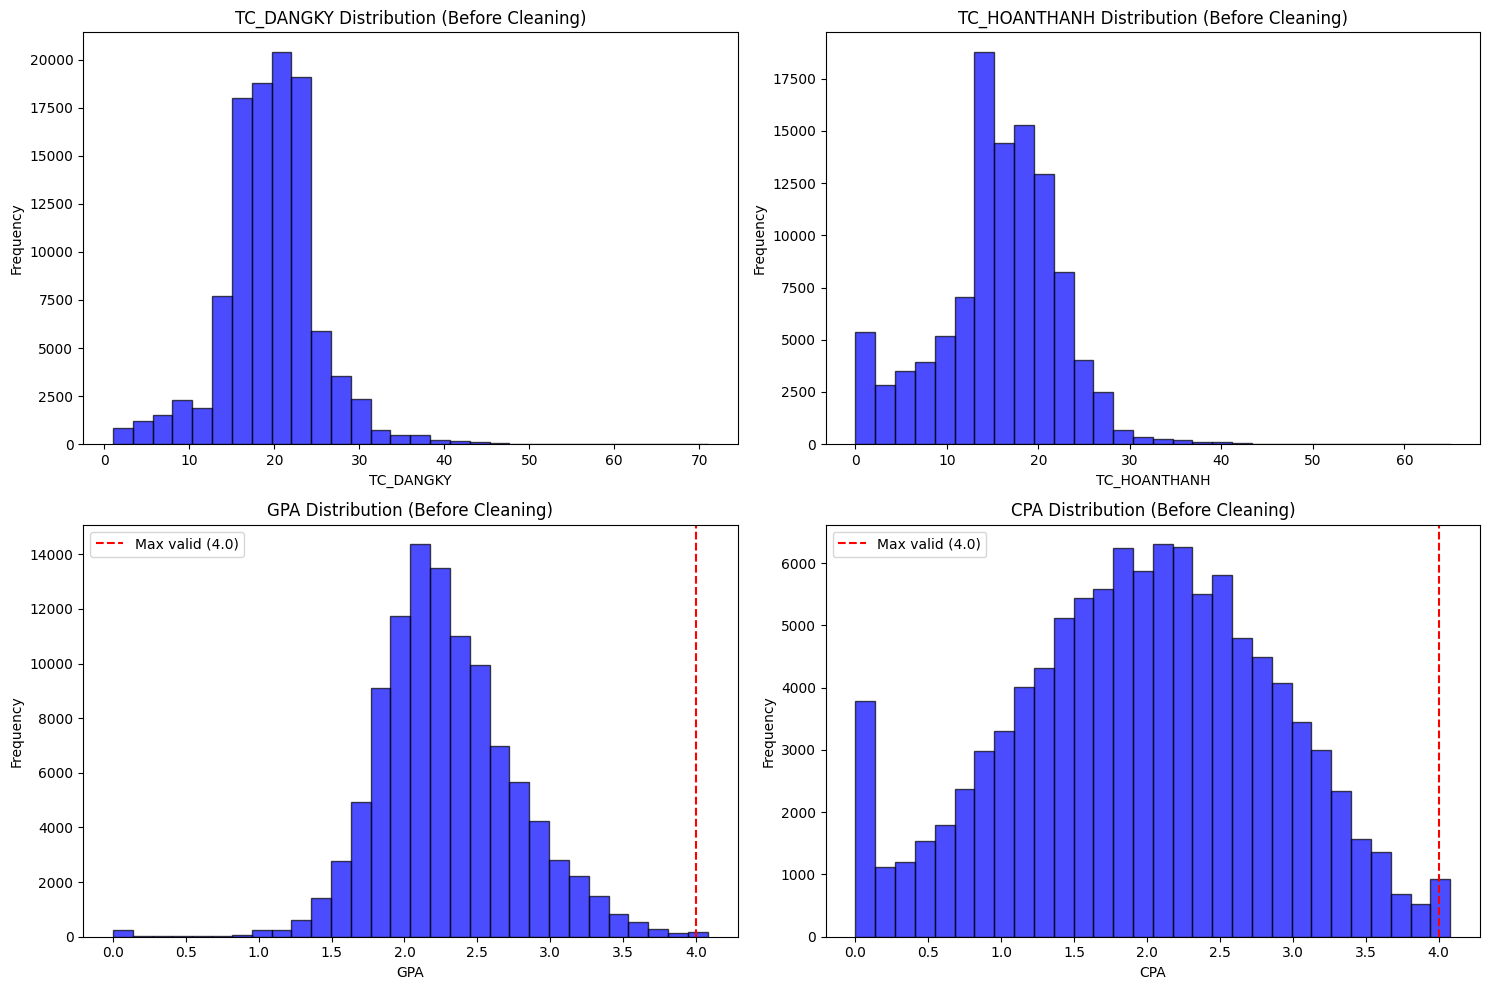

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# TC_DANGKY
axes[0, 0].hist(df_acad['TC_DANGKY'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('TC_DANGKY Distribution (Before Cleaning)')
axes[0, 0].set_xlabel('TC_DANGKY')
axes[0, 0].set_ylabel('Frequency')

# TC_HOANTHANH
axes[0, 1].hist(df_acad['TC_HOANTHANH'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('TC_HOANTHANH Distribution (Before Cleaning)')
axes[0, 1].set_xlabel('TC_HOANTHANH')
axes[0, 1].set_ylabel('Frequency')

# GPA
axes[1, 0].hist(df_acad['GPA'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('GPA Distribution (Before Cleaning)')
axes[1, 0].set_xlabel('GPA')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(x=4, color='red', linestyle='--', label='Max valid (4.0)')
axes[1, 0].legend()

# CPA
axes[1, 1].hist(df_acad['CPA'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('CPA Distribution (Before Cleaning)')
axes[1, 1].set_xlabel('CPA')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(x=4, color='red', linestyle='--', label='Max valid (4.0)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

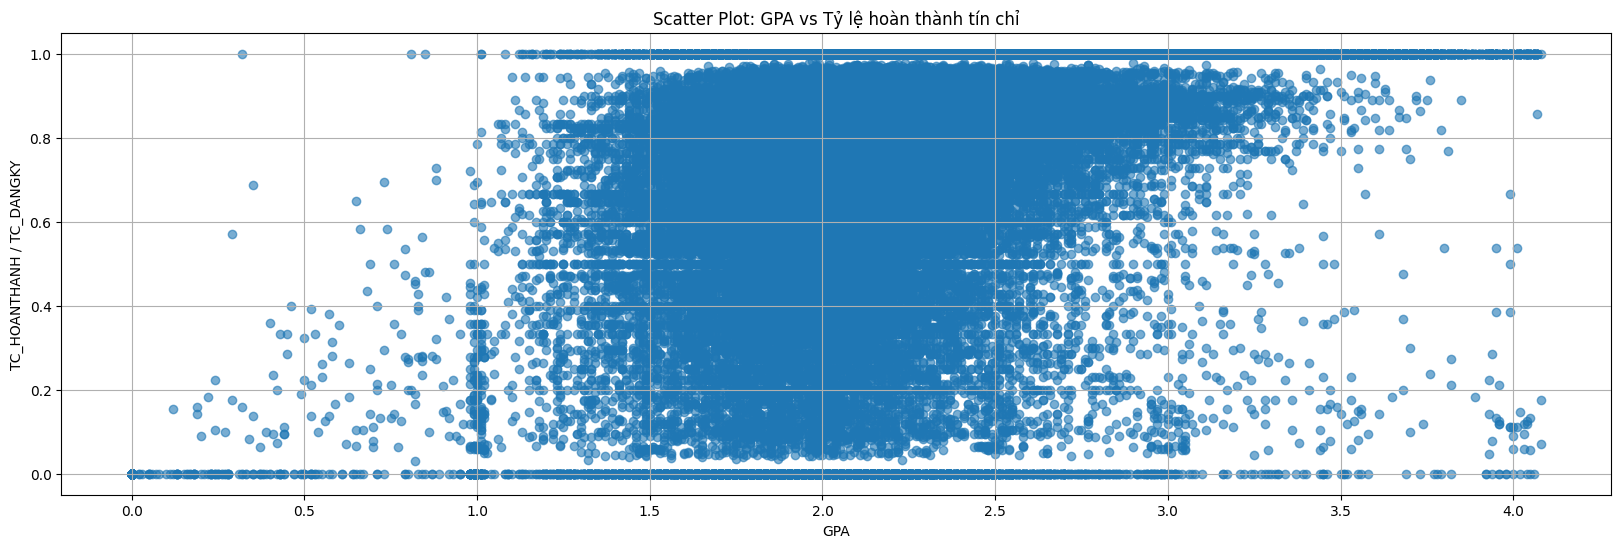

In [ ]:
# Cột tỷ lệ hoàn thành tín chỉ
df_acad["TY_LE_HOANTHANH"] = df_acad["TC_HOANTHANH"] / df_acad["TC_DANGKY"]

plt.figure(figsize=(20, 6))

plt.scatter(
    df_acad["GPA"],
    df_acad["TY_LE_HOANTHANH"],
    alpha=0.6
)

plt.xlabel("GPA")
plt.ylabel("TC_HOANTHANH / TC_DANGKY")
plt.title("Scatter Plot: GPA vs Tỷ lệ hoàn thành tín chỉ")

plt.grid(True)
plt.show()

## 1.5 Clean Academic Data

***Xử lý TC_DANGKY outliers***

In [ ]:
df = df_acad.copy()

Q1 = df["TC_DANGKY"].quantile(0.25)
Q3 = df["TC_DANGKY"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = int(Q3 + 1.5 * IQR)

before = df["TC_DANGKY"].max()
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

df["TC_DANGKY"] = df["TC_DANGKY"].apply(lambda x: min(x, upper_bound))
df["TC_DANGKY"] = df["TC_DANGKY"].clip(upper=upper_bound).astype(int)

print(f"Max TC_DANGKY: {before} → {df['TC_DANGKY'].max()}")

Lower bound: 9.5
Upper bound: 29
Max TC_DANGKY: 71 → 29


***Xử lý TC_HOANTHANH outliers***

In [ ]:
# Xu li Tin chi hoan thanh theo Ratio cua tin chi dang ki
df["TC_RATIO"] = (
    df["TC_HOANTHANH"] / df["TC_DANGKY"]
).fillna(0).clip(upper=1.0)

df["TC_HOANTHANH"] = (df["TC_DANGKY"] * df["TC_RATIO"]).round(0).astype(int)
print(f"TC_HOANTHANH range: [{df['TC_HOANTHANH'].min()}, {df['TC_HOANTHANH'].max()}]")

TC_HOANTHANH range: [0, 29]


***Xử lý GPA***

In [ ]:
zero_tc_mask = df["TC_HOANTHANH"] == 0
df.loc[zero_tc_mask, "GPA"] = 0
print(f"Set GPA=0 for {zero_tc_mask.sum()} records with TC_HOANTHANH=0")

Set GPA=0 for 3317 records with TC_HOANTHANH=0


In [ ]:
#Nghien cuu phuong phap su dung
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Loc GPA hop le
clean_df = df[df["GPA"] <= 4].copy()

features = ["TC_HOANTHANH", "TC_DANGKY"]
X = clean_df[features]
y = clean_df["GPA"]

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X,
    y,
    clean_df["MA_SO_SV"],
    test_size=0.2,
    random_state=42
)

# ===== MEAN (Mean GPA theo sinh vien) =====
mean_map = clean_df.groupby("MA_SO_SV")["GPA"].mean()
pred_mean = id_test.map(mean_map)

# Neu SV moi chua co GPA truoc do
pred_mean.fillna(clean_df["GPA"].mean(), inplace=True)

# ===== RANDOM FOREST =====
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# ===== SO SANH =====
rmse_mean = np.sqrt(mean_squared_error(y_test, pred_mean))
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))

print("RMSE Mean per student:", rmse_mean)
print("RMSE Random Forest:", rmse_rf)

RMSE Mean per student: 0.3079974026199589
RMSE Random Forest: 0.3828436743714755


In [ ]:
# Xu li GPA - MEAN
noise_mask = (df["GPA"] > 4) & (~zero_tc_mask)
if noise_mask.sum() > 0:
    valid_mask = df["GPA"] <= 4
    mean_gpa_per_student = df[valid_mask].groupby("MA_SO_SV")["GPA"].mean()
    mapped_values = df.loc[noise_mask, "MA_SO_SV"].map(mean_gpa_per_student)
    df.loc[noise_mask, "GPA"] = mapped_values.fillna(4.0)
    print(f"Fixed {noise_mask.sum()} GPA values > 4")

Fixed 80 GPA values > 4


***Xử lý CPA***

In [ ]:
#CPA- Random Forest
noise_mask = df["CPA"] > 4

if noise_mask.sum() > 0:
    clean_df = df[df["CPA"] <= 4].copy()
    features = ["GPA", "TC_DANGKY", "TC_HOANTHANH"]
    
    X_train = clean_df[features].fillna(clean_df[features].mean())
    y_train = clean_df["CPA"]
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    X_noise = df.loc[noise_mask, features].fillna(clean_df[features].mean())
    df.loc[noise_mask, "CPA"] = rf_model.predict(X_noise)
    print(f"   Fixed {noise_mask.sum()} CPA values > 4")

df_acad_clean = df
print("\nData cleaning completed!")

   Fixed 498 CPA values > 4

Data cleaning completed!


## 1.6 Visualize After Cleaning

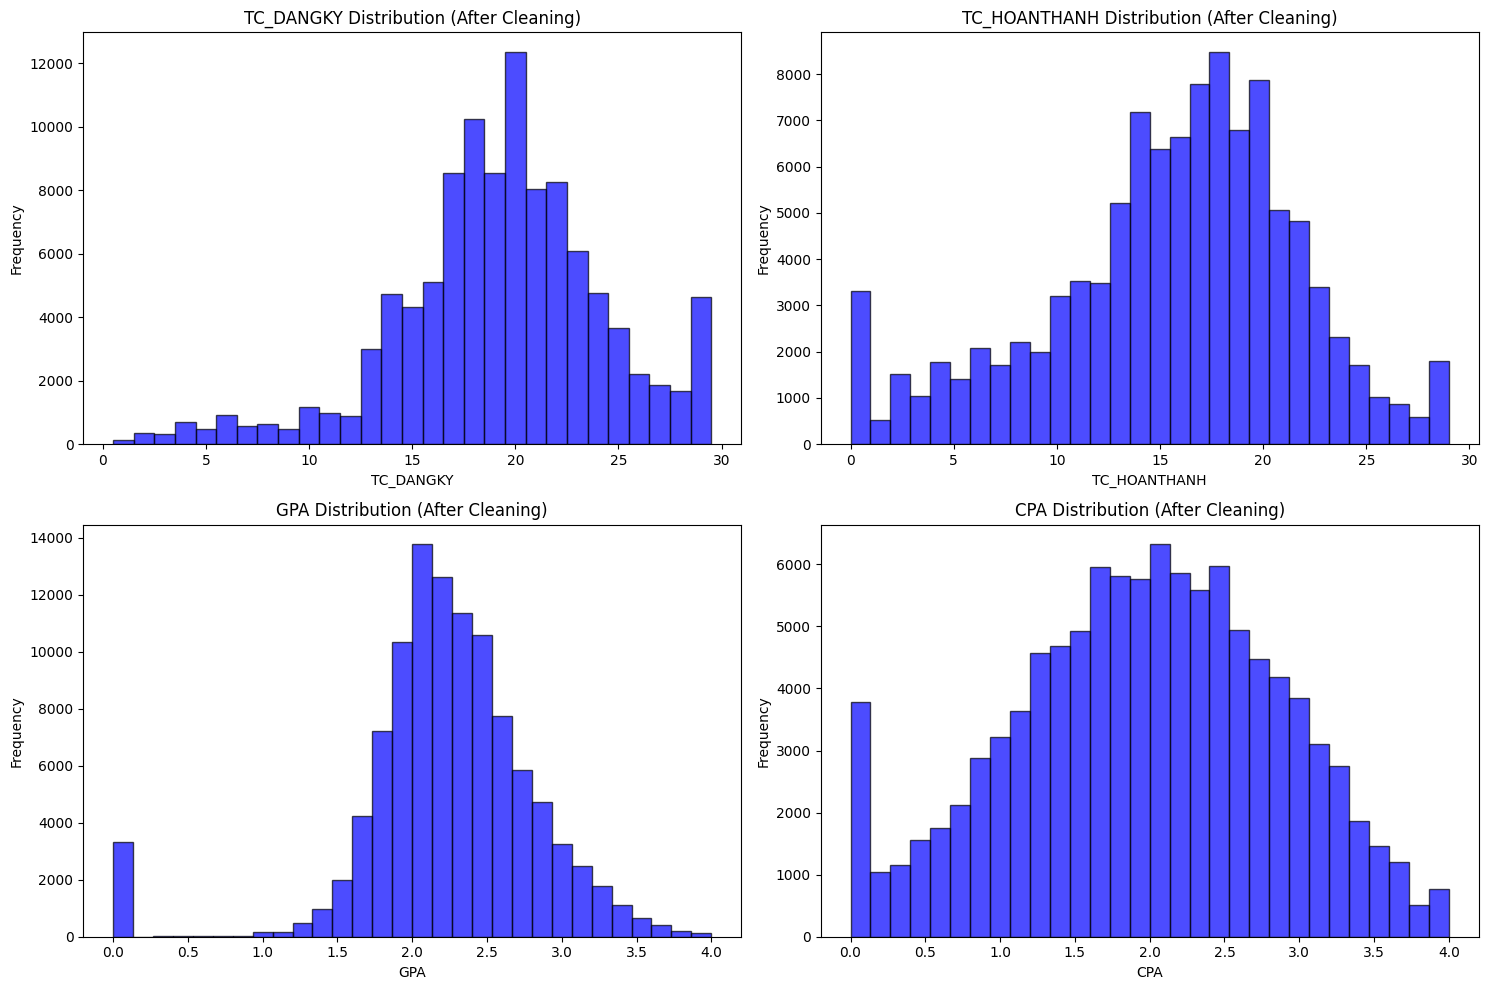

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# TC_DANGKY
min_tc = df_acad_clean["TC_DANGKY"].min()
max_tc = df_acad_clean["TC_DANGKY"].max()
axes[0, 0].hist(df_acad_clean['TC_DANGKY'], color='blue', bins=np.arange(min_tc, max_tc + 2) - 0.5, edgecolor='black',  alpha=0.7) 
axes[0, 0].set_title('TC_DANGKY Distribution (After Cleaning)')
axes[0, 0].set_xlabel('TC_DANGKY')
axes[0, 0].set_ylabel('Frequency')


# TC_HOANTHANH
axes[0, 1].hist(df_acad_clean['TC_HOANTHANH'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('TC_HOANTHANH Distribution (After Cleaning)')
axes[0, 1].set_xlabel('TC_HOANTHANH')
axes[0, 1].set_ylabel('Frequency')

# GPA
axes[1, 0].hist(df_acad_clean['GPA'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('GPA Distribution (After Cleaning)')
axes[1, 0].set_xlabel('GPA')
axes[1, 0].set_ylabel('Frequency')

# CPA
axes[1, 1].hist(df_acad_clean['CPA'], color='blue', bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('CPA Distribution (After Cleaning)')
axes[1, 1].set_xlabel('CPA')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 1.7 Merge with Admission Data

In [ ]:
df_merged = df_acad_clean.merge(df_adm, on="MA_SO_SV", how="left")
print(f"Merged shape: {df_merged.shape}")

# Tính DIEM_LECH
df_merged["DIEM_LECH"] = df_merged["DIEM_TRUNGTUYEN"] - df_merged["DIEM_CHUAN"]

print(f"\nNew columns from admission:")
print([col for col in df_merged.columns if col not in df_acad_clean.columns])


Merged shape: (105726, 13)

New columns from admission:
['NAM_TUYENSINH', 'PTXT', 'TOHOP_XT', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'DIEM_LECH']


## 1.8 Analyze Relationships

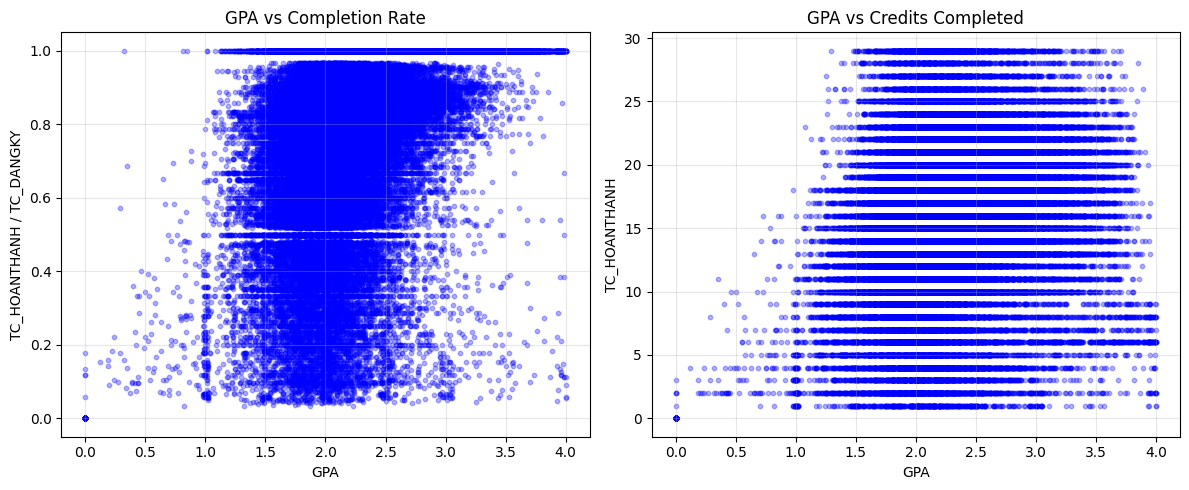

In [ ]:
# GPA vs TC_HOANTHANH ratio
df_merged['TC_RATIO'] = df_merged['TC_HOANTHANH'] / df_merged['TC_DANGKY']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df_merged['GPA'], df_merged['TC_RATIO'], color='blue', alpha=0.3, s=10)
plt.xlabel('GPA')
plt.ylabel('TC_HOANTHANH / TC_DANGKY')
plt.title('GPA vs Completion Rate')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(df_merged['GPA'], df_merged['TC_HOANTHANH'], color='blue', alpha=0.3, s=10)
plt.xlabel('GPA')
plt.ylabel('TC_HOANTHANH')
plt.title('GPA vs Credits Completed')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 2. FEATURE ENGINEERING

## 2.1 Helper Functions

In [ ]:
def convert_semester_format(semester_str):
    """
    Convert semester format: 'HK1 2024-2025' -> '20241'
    """
    if isinstance(semester_str, (int, float)):
        return str(int(semester_str))
    
    semester_str = str(semester_str).strip()
    
    # Nếu đã đúng format (5 chữ số)
    if semester_str.isdigit() and len(semester_str) == 5:
        return semester_str
    
    # Parse format 'HK1 2024-2025'
    match = re.match(r'HK(\d)\s+(\d{4})-(\d{4})', semester_str)
    if match:
        hk_num = match.group(1)
        year = match.group(2)
        return f"{year}{hk_num}"
    
    return semester_str


def calculate_history_features(history, current_tc_dangky):
    """
    Tính features từ lịch sử các kỳ đã học
    
    Parameters:
    -----------
    history: DataFrame - Lịch sử các kỳ đã học (sorted by semester)
    current_tc_dangky: int - Tín chỉ đăng ký kỳ hiện tại
    
    Returns:
    --------
    dict: Dictionary chứa các features
    """
    if len(history) == 0:
        return None
    
    features = {}
    Ti = len(history)
    
    # I. GPA FEATURES
    features['GPA_mean'] = history['GPA'].mean()
    features['GPA_last'] = history['GPA'].iloc[-1]
    features['GPA_min'] = history['GPA'].min()
    features['GPA_max'] = history['GPA'].max()
    
    if Ti > 1:
        t = np.arange(1, Ti + 1)
        slope, _ = np.polyfit(t, history['GPA'].values, 1)
        features['GPA_trend'] = slope
        features['GPA_std'] = history['GPA'].std()
    else:
        features['GPA_trend'] = 0
        features['GPA_std'] = 0
    
    # II. CPA FEATURES
    features['CPA_last'] = history['CPA'].iloc[-1]
    
    # III. TC_HOANTHANH FEATURES
    features['TC_HT_mean'] = history['TC_HOANTHANH'].mean()
    features['TC_HT_last'] = history['TC_HOANTHANH'].iloc[-1]
    features['TC_HT_std'] = history['TC_HOANTHANH'].std() if Ti > 1 else 0
    features['TC_TICHLU'] = history['TC_HOANTHANH'].sum()
    
    # TC_RATIO (completion rate)
    history_ratio = history['TC_RATIO'].clip(0, 1)
    features['TC_HT_ratio_mean'] = history_ratio.mean()
    
    # IV. SEMESTER COUNT & FAIL FEATURES
    features['num_semesters'] = Ti
    
    failed = (history['TC_HOANTHANH'] == 0) | (history['TC_RATIO'] < 0.5)
    features['num_failed_semesters'] = failed.sum()
    features['fail_rate'] = features['num_failed_semesters'] / Ti if Ti > 0 else 0
    
    # Consecutive fails
    consecutive = 0
    for j in range(Ti - 1, -1, -1):
        if failed.iloc[j]:
            consecutive += 1
        else:
            break
    features['consecutive_fails'] = consecutive
    
    # V. TC_DANGKY FEATURES
    features['TC_DANGKY_mean'] = history['TC_DANGKY'].mean()
    features['TC_DANGKY_last'] = history['TC_DANGKY'].iloc[-1]
    features['TC_DANGKY_std'] = history['TC_DANGKY'].std() if Ti > 1 else 0
    
    # Current semester features
    features['TC_DANGKY_current'] = current_tc_dangky
    
    # Load ratio
    tc_ht_mean_safe = features['TC_HT_mean'] if features['TC_HT_mean'] > 0 else 1
    features['TC_load_ratio'] = current_tc_dangky / tc_ht_mean_safe
    
    # TC change
    features['TC_change'] = current_tc_dangky - features['TC_DANGKY_last']
    
    # Interaction
    features['TC_GPA_interaction'] = current_tc_dangky * features['GPA_last']
    
    # Flags
    features['overload_risk'] = int(features['TC_load_ratio'] > 1.2)
    features['is_increasing_load'] = int(features['TC_change'] > 0)
    
    return features

## 2.2 Prepare Train & Validation Data

In [ ]:
print("FEATURE ENGINEERING - TRAIN & VALIDATION")
df = df_merged.copy()

FEATURE ENGINEERING - TRAIN & VALIDATION


***Convert semester format***

In [ ]:
df['HOC_KY_STR'] = df['HOC_KY'].apply(convert_semester_format)
df['HOC_KY_INT'] = df['HOC_KY_STR'].astype(int)

***Sort by student and semester***

In [ ]:
df = df.sort_values(['MA_SO_SV', 'HOC_KY_INT']).reset_index(drop=True)
print(f"Total records: {len(df):,}")
print(f"Semesters: {sorted(df['HOC_KY_STR'].unique())}")

Total records: 105,726
Semesters: ['20201', '20202', '20211', '20212', '20221', '20222', '20231', '20232']


***Create semester number per student***

In [ ]:
df['KY_SO'] = df.groupby('MA_SO_SV').cumcount() + 1

***Calculate expanding features for each semester***

In [ ]:
print("\nComputing expanding window features")

all_features = []
students = df['MA_SO_SV'].unique()

for idx, student_id in enumerate(students):
    if (idx + 1) % 1000 == 0:
        print(f"   Processed {idx + 1:,}/{len(students):,} students...")
    
    df_student = df[df['MA_SO_SV'] == student_id].copy()
    
    # Tính features cho từng kỳ
    for i in range(len(df_student)):
        current = df_student.iloc[i]
        
        if i == 0:
            # Kỳ đầu tiên: không có history
            feat = {
                'MA_SO_SV': student_id,
                'HOC_KY_STR': current['HOC_KY_STR'],
                'HOC_KY_INT': current['HOC_KY_INT'],
                'KY_SO': current['KY_SO'],
                'TC_DANGKY_current': current['TC_DANGKY'],
                'TC_HOANTHANH': current['TC_HOANTHANH'],
                
                # No history features - set to default
                'num_semesters': 0,
                'GPA_mean': 0,
                'GPA_last': 0,
                'GPA_min': 0,
                'GPA_max': 0,
                'GPA_trend': 0,
                'GPA_std': 0,
                'CPA_last': 0,
                'TC_HT_mean': 0,
                'TC_HT_last': 0,
                'TC_HT_std': 0,
                'TC_TICHLU': 0,
                'TC_HT_ratio_mean': 0,
                'num_failed_semesters': 0,
                'fail_rate': 0,
                'consecutive_fails': 0,
                'TC_DANGKY_mean': 0,
                'TC_DANGKY_last': 0,
                'TC_DANGKY_std': 0,
                'TC_load_ratio': 1.0,
                'TC_change': 0,
                'TC_GPA_interaction': 0,
                'overload_risk': 0,
                'is_increasing_load': 0,
            }
            
            # Add admission data
            for col in ['NAM_TUYENSINH', 'PTXT', 'TOHOP_XT', 
                       'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'DIEM_LECH']:
                if col in current:
                    feat[col] = current[col]
            
            all_features.append(feat)
            
        else:
            # Có history
            history = df_student.iloc[:i].copy()
            
            feat = calculate_history_features(
                history=history,
                current_tc_dangky=current['TC_DANGKY']
            )
            
            if feat:
                # Add metadata
                feat['MA_SO_SV'] = student_id
                feat['HOC_KY_STR'] = current['HOC_KY_STR']
                feat['HOC_KY_INT'] = current['HOC_KY_INT']
                feat['KY_SO'] = current['KY_SO']
                feat['TC_HOANTHANH'] = current['TC_HOANTHANH']
                
                # Add admission data
                for col in ['NAM_TUYENSINH', 'PTXT', 'TOHOP_XT',
                           'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'DIEM_LECH']:
                    if col in current:
                        feat[col] = current[col]
                
                all_features.append(feat)

df_features = pd.DataFrame(all_features)
print(f"\nCreated {len(df_features):,} feature records")


Computing expanding window features
   Processed 1,000/20,381 students...
   Processed 2,000/20,381 students...
   Processed 3,000/20,381 students...
   Processed 4,000/20,381 students...
   Processed 5,000/20,381 students...
   Processed 6,000/20,381 students...
   Processed 7,000/20,381 students...
   Processed 8,000/20,381 students...
   Processed 9,000/20,381 students...
   Processed 10,000/20,381 students...
   Processed 11,000/20,381 students...
   Processed 12,000/20,381 students...
   Processed 13,000/20,381 students...
   Processed 14,000/20,381 students...
   Processed 15,000/20,381 students...
   Processed 16,000/20,381 students...
   Processed 17,000/20,381 students...
   Processed 18,000/20,381 students...
   Processed 19,000/20,381 students...
   Processed 20,000/20,381 students...

Created 105,726 feature records


***Split train/val***

In [ ]:
print(f"\nSplitting train/val (val_semester={VAL_SEMESTER})")
val_semester_int = int(VAL_SEMESTER)

df_train = df_features[df_features['HOC_KY_INT'] < val_semester_int].copy()
df_val = df_features[df_features['HOC_KY_INT'] == val_semester_int].copy()

print(f"   Train: {len(df_train):,} records")
print(f"   Val:   {len(df_val):,} records")
print(f"   Total features: {len(df_features.columns)} columns")


Splitting train/val (val_semester=20232)
   Train: 90,582 records
   Val:   15,144 records
   Total features: 36 columns


## 2.3 Explore Created Features

In [ ]:
print("TRAIN DATA FEATURES")

print(f"\nShape: {df_train.shape}")
print(f"\nSample features:")
display(df_train.head(10))

# Check students without history
no_history = df_train[df_train['num_semesters'] == 0]
print(f"\nStudents without history in TRAIN: {len(no_history)} ({len(no_history)/len(df_train)*100:.1f}%)")

no_history_val = df_val[df_val['num_semesters'] == 0]
print(f"Students without history in VAL: {len(no_history_val)} ({len(no_history_val)/len(df_val)*100:.1f}%)")

TRAIN DATA FEATURES

Shape: (90582, 36)

Sample features:


MA_SO_SV HOC_KY_STR  HOC_KY_INT  KY_SO  TC_DANGKY_current  \
0   00003e092652      20231       20231      1                 18   
2   000e15519006      20211       20211      1                  9   
3   000e15519006      20212       20212      2                 19   
4   000e15519006      20221       20221      3                 21   
5   000e15519006      20222       20222      4                 18   
6   000e15519006      20231       20231      5                 20   
8   000ea6e12003      20231       20231      1                 17   
10  00109b845a3d      20231       20231      1                 14   
12  0013bfc00f46      20201       20201      1                 16   
13  0013bfc00f46      20202       20202      2                 23   

    TC_HOANTHANH  num_semesters  GPA_mean  GPA_last  GPA_min  ...  TC_change  \
0             15              0  0.000000      0.00     0.00  ...          0   
2              9              0  0.000000      0.00     0.00  ...          0   
3             19              1  3.850000      3.85     3.85  ...         10   
4             21              2  3.485000      3.12     3.12  ...          2   
5             18              3  3.316667      2.98     2.98  ...         -3   
6             14              4  3.217500      2.92     2.92  ...          2   
8             10              0  0.000000      0.00     0.00  ...          0   
10             2              0  0.000000      0.00     0.00  ...          0   
12            11              0  0.000000      0.00     0.00  ...          0   
13            23              1  1.780000      1.78     1.78  ...          7   

    TC_GPA_interaction  overload_risk  is_increasing_load  NAM_TUYENSINH  \
0                 0.00              0                   0           2023   
2                 0.00              0                   0           2021   
3                73.15              1                   1           2021   
4                65.52              1                   1           2021   
5                53.64              0                   0           2021   
6                58.40              0                   1           2021   
8                 0.00              0                   0           2023   
10                0.00              0                   0           2023   
12                0.00              0                   0           2020   
13               40.94              1                   1           2020   

    PTXT  TOHOP_XT  DIEM_TRUNGTUYEN  DIEM_CHUAN  DIEM_LECH  
0    100       A00            21.32       20.25       1.07  
2      1       D07            23.84       22.43       1.41  
3      1       D07            23.84       22.43       1.41  
4      1       D07            23.84       22.43       1.41  
5      1       D07            23.84       22.43       1.41  
6      1       D07            23.84       22.43       1.41  
8    100       D01            25.14       24.08       1.06  
10   100       V00            20.09       18.98       1.11  
12     1       A00            24.53       24.28       0.25  
13     1       A00            24.53       24.28       0.25  

[10 rows x 36 columns]


Students without history in TRAIN: 20381 (22.5%)
Students without history in VAL: 0 (0.0%)


## 2.4 Prepare Test Data

In [ ]:
print("FEATURE ENGINEERING - TEST DATA")
df_test = df_test_raw.copy()

FEATURE ENGINEERING - TEST DATA


***Convert semester format***

In [ ]:
print("\nConverting semester format")
df_test['HOC_KY_STR'] = df_test['HOC_KY'].apply(convert_semester_format)
df_test['HOC_KY_INT'] = df_test['HOC_KY_STR'].astype(int)
print(f"   Test semester: {df_test['HOC_KY_STR'].unique()}")


Converting semester format
   Test semester: ['20241']


***Prepare history***

In [ ]:
df_history = df_merged.copy()
df_history['HOC_KY_STR'] = df_history['HOC_KY'].apply(convert_semester_format)
df_history['HOC_KY_INT'] = df_history['HOC_KY_STR'].astype(int)
df_history = df_history.sort_values(['MA_SO_SV', 'HOC_KY_INT'])

***Calculate features***

In [ ]:
print("\nComputing features from history...")

test_features = []

for idx, row in df_test.iterrows():
    if (idx + 1) % 500 == 0:
        print(f"   Processed {idx + 1:,}/{len(df_test):,} test records")
    
    student_id = row['MA_SO_SV']
    target_semester_int = row['HOC_KY_INT']
    tc_dangky = row['TC_DANGKY']
    
    # Lấy lịch sử các kỳ trước
    history = df_history[
        (df_history['MA_SO_SV'] == student_id) & 
        (df_history['HOC_KY_INT'] < target_semester_int)
    ].copy()
    
    # Tính số kỳ đã học
    ky_so = len(history) + 1
    
    if len(history) == 0:
        # Sinh viên mới - chỉ có admission data
        feat = {
            'MA_SO_SV': student_id,
            'HOC_KY_STR': row['HOC_KY_STR'],
            'HOC_KY_INT': row['HOC_KY_INT'],
            'KY_SO': ky_so,
            'TC_DANGKY_current': tc_dangky,
            
            # No history
            'num_semesters': 0,
            'GPA_mean': 0,
            'GPA_last': 0,
            'GPA_min': 0,
            'GPA_max': 0,
            'GPA_trend': 0,
            'GPA_std': 0,
            'CPA_last': 0,
            'TC_HT_mean': 0,
            'TC_HT_last': 0,
            'TC_HT_std': 0,
            'TC_TICHLU': 0,
            'TC_HT_ratio_mean': 0,
            'num_failed_semesters': 0,
            'fail_rate': 0,
            'consecutive_fails': 0,
            'TC_DANGKY_mean': 0,
            'TC_DANGKY_last': 0,
            'TC_DANGKY_std': 0,
            'TC_load_ratio': 1.0,
            'TC_change': 0,
            'TC_GPA_interaction': 0,
            'overload_risk': 0,
            'is_increasing_load': 0,
        }
    else:
        # Có history
        feat = calculate_history_features(
            history=history,
            current_tc_dangky=tc_dangky
        )
        
        if feat:
            feat['MA_SO_SV'] = student_id
            feat['HOC_KY_STR'] = row['HOC_KY_STR']
            feat['HOC_KY_INT'] = row['HOC_KY_INT']
            feat['KY_SO'] = ky_so
    
    test_features.append(feat)

df_test_features = pd.DataFrame(test_features)


Computing features from history...
   Processed 500/16,502 test records
   Processed 1,000/16,502 test records
   Processed 1,500/16,502 test records
   Processed 2,000/16,502 test records
   Processed 2,500/16,502 test records
   Processed 3,000/16,502 test records
   Processed 3,500/16,502 test records
   Processed 4,000/16,502 test records
   Processed 4,500/16,502 test records
   Processed 5,000/16,502 test records
   Processed 5,500/16,502 test records
   Processed 6,000/16,502 test records
   Processed 6,500/16,502 test records
   Processed 7,000/16,502 test records
   Processed 7,500/16,502 test records
   Processed 8,000/16,502 test records
   Processed 8,500/16,502 test records
   Processed 9,000/16,502 test records
   Processed 9,500/16,502 test records
   Processed 10,000/16,502 test records
   Processed 10,500/16,502 test records
   Processed 11,000/16,502 test records
   Processed 11,500/16,502 test records
   Processed 12,000/16,502 test records
   Processed 12,500/16,50

***Merge với admission data***

In [ ]:
df_test_features = df_test_features.merge(
    df_adm[['MA_SO_SV', 'NAM_TUYENSINH', 'PTXT', 'TOHOP_XT',
           'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']],
    on='MA_SO_SV',
    how='left'
)

***Tinh DIEM_LECH***

In [ ]:
df_test_features['DIEM_LECH'] = (
    df_test_features['DIEM_TRUNGTUYEN'] - df_test_features['DIEM_CHUAN']
)

In [ ]:
print(f"\nCreated {len(df_test_features):,} test records")
print(f"   Students without history: {(df_test_features['num_semesters'] == 0).sum()}")
print(f"   Total features: {len(df_test_features.columns)} columns")


Created 16,502 test records
   Students without history: 4328
   Total features: 35 columns


# 3. ENCODING & FEATURE SELECTION

## 3.1 Analyze PTXT and TOHOP_XT

In [ ]:
print("CATEGORICAL FEATURES ANALYSIS")

print("\n1. PTXT (Phương thức xét tuyển):")
print(df_train['PTXT'].value_counts())
print(f"   Unique values: {df_train['PTXT'].nunique()}")

print("\n2. TOHOP_XT (Tổ hợp xét tuyển):")
print(df_train['TOHOP_XT'].value_counts().head(10))
print(f"   Unique values: {df_train['TOHOP_XT'].nunique()}")


CATEGORICAL FEATURES ANALYSIS

1. PTXT (Phương thức xét tuyển):
PTXT
1      75991
100    14038
409      339
500       55
402       52
3         52
5         32
200       23
Name: count, dtype: int64
   Unique values: 8

2. TOHOP_XT (Tổ hợp xét tuyển):
TOHOP_XT
A00    56629
A01    16149
V00     8437
D07     3576
V02     3006
V01     1072
D01      761
B00      353
X01      160
V06      149
Name: count, dtype: int64
   Unique values: 18


## 3.2 Target Encoding

In [ ]:
print("ENCODING CATEGORICAL FEATURES")

print("\nTarget Encoding for PTXT and TOHOP_XT...")

ptxt_encoder = ce.TargetEncoder(cols=['PTXT'], smoothing=1.0)
tohop_encoder = ce.TargetEncoder(cols=['TOHOP_XT'], smoothing=1.0)

ENCODING CATEGORICAL FEATURES

Target Encoding for PTXT and TOHOP_XT...


In [ ]:
# Fit on train
df_train_enc = df_train.copy()
df_train_enc['PTXT_TE'] = ptxt_encoder.fit_transform(
    df_train[['PTXT']], df_train['TC_HOANTHANH']
)['PTXT']
df_train_enc['TOHOP_TE'] = tohop_encoder.fit_transform(
    df_train[['TOHOP_XT']], df_train['TC_HOANTHANH']
)['TOHOP_XT']

# Transform val
df_val_enc = df_val.copy()
df_val_enc['PTXT_TE'] = ptxt_encoder.transform(df_val[['PTXT']])['PTXT']
df_val_enc['TOHOP_TE'] = tohop_encoder.transform(df_val[['TOHOP_XT']])['TOHOP_XT']

# Transform test
df_test_enc = df_test_features.copy()
df_test_enc['PTXT_TE'] = ptxt_encoder.transform(df_test_features[['PTXT']])['PTXT']
df_test_enc['TOHOP_TE'] = tohop_encoder.transform(df_test_features[['TOHOP_XT']])['TOHOP_XT']

print(f"   PTXT encoded: {df_train['PTXT'].nunique()} categories")
print(f"   TOHOP_XT encoded: {df_train['TOHOP_XT'].nunique()} categories")

   PTXT encoded: 8 categories
   TOHOP_XT encoded: 18 categories


## 3.3 Visualize Encoded Features

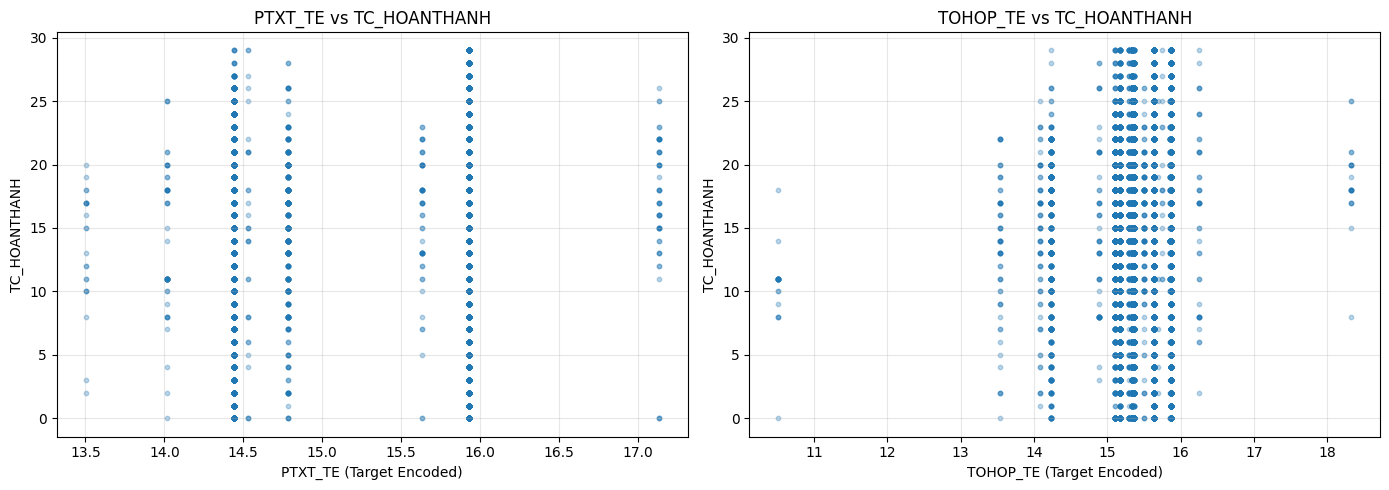

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PTXT_TE
axes[0].scatter(df_train_enc['PTXT_TE'], df_train_enc['TC_HOANTHANH'], 
                alpha=0.3, s=10)
axes[0].set_xlabel('PTXT_TE (Target Encoded)')
axes[0].set_ylabel('TC_HOANTHANH')
axes[0].set_title('PTXT_TE vs TC_HOANTHANH')
axes[0].grid(True, alpha=0.3)

# TOHOP_TE
axes[1].scatter(df_train_enc['TOHOP_TE'], df_train_enc['TC_HOANTHANH'], 
                alpha=0.3, s=10)
axes[1].set_xlabel('TOHOP_TE (Target Encoded)')
axes[1].set_ylabel('TC_HOANTHANH')
axes[1].set_title('TOHOP_TE vs TC_HOANTHANH')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Check correlation
print(f"\nCorrelation with TC_HOANTHANH:")
print(f"  PTXT_TE:  {df_train_enc[['PTXT_TE', 'TC_HOANTHANH']].corr().iloc[0,1]:.4f}")
print(f"  TOHOP_TE: {df_train_enc[['TOHOP_TE', 'TC_HOANTHANH']].corr().iloc[0,1]:.4f}")


Correlation with TC_HOANTHANH:
  PTXT_TE:  0.0863
  TOHOP_TE: 0.0477


## 3.4 Feature Selection

In [ ]:
print("FEATURE SELECTION")

mandatory_features = [
    'TC_DANGKY_current',
    'num_semesters',
    'NAM_TUYENSINH',
    'PTXT_TE',
    'TOHOP_TE',
    'DIEM_TRUNGTUYEN',
    'DIEM_CHUAN',
    'DIEM_LECH',
    'KY_SO',
]

exclude_cols = [
    'MA_SO_SV', 'TC_HOANTHANH', 'HOC_KY', 'HOC_KY_INT', 'HOC_KY_STR',
    'PTXT', 'TOHOP_XT'
]

numeric_cols = [
    c for c in df_train_enc.select_dtypes(include=np.number).columns 
    if c not in exclude_cols
]

FEATURE SELECTION


In [ ]:
# Tính correlation matrix
target_col = 'TC_HOANTHANH'
corr_threshold = 0.05
multicollinearity_threshold = 0.9

corr_matrix = df_train_enc[numeric_cols + [target_col]].corr()
target_corr = abs(corr_matrix[target_col]).sort_values(ascending=False)

In [ ]:
# Bước 1: Lọc theo correlation với target
selected = target_corr[target_corr > corr_threshold].index.tolist()
if target_col in selected:
    selected.remove(target_col)


In [ ]:
# Thêm mandatory features
for feat in mandatory_features:
    if feat in numeric_cols and feat not in selected:
        selected.append(feat)
        print(f"   Added mandatory: {feat} (corr={target_corr.get(feat, 0):.4f})")

print(f"\nAfter correlation filter: {len(selected)} features")


   Added mandatory: num_semesters (corr=0.0255)
   Added mandatory: TOHOP_TE (corr=0.0477)
   Added mandatory: DIEM_LECH (corr=0.0225)
   Added mandatory: KY_SO (corr=0.0255)

After correlation filter: 30 features


In [ ]:
# Tính correlation matrix
target_col = 'TC_HOANTHANH'
corr_threshold = 0.05
multicollinearity_threshold = 0.9

corr_matrix = df_train_enc[numeric_cols + [target_col]].corr()
target_corr = abs(corr_matrix[target_col]).sort_values(ascending=False)

In [ ]:
# Bước 2: Loại bỏ multicollinearity
to_remove = set()

for i in range(len(selected)):
    if selected[i] in to_remove or selected[i] in mandatory_features:
        continue
    
    for j in range(i+1, len(selected)):
        if selected[j] in to_remove:
            continue
        
        corr_val = abs(corr_matrix.loc[selected[i], selected[j]])
        
        if corr_val > multicollinearity_threshold:
            if selected[j] in mandatory_features:
                to_remove.add(selected[i])
            elif selected[i] in mandatory_features:
                to_remove.add(selected[j])
            elif abs(target_corr[selected[i]]) >= abs(target_corr[selected[j]]):
                to_remove.add(selected[j])
            else:
                to_remove.add(selected[i])

selected_features = [f for f in selected if f not in to_remove]

print(f"After multicollinearity removal: {len(selected_features)} features")
print(f"Removed: {len(to_remove)} features")


After multicollinearity removal: 23 features
Removed: 7 features



Plotting Feature vs Target Correlation


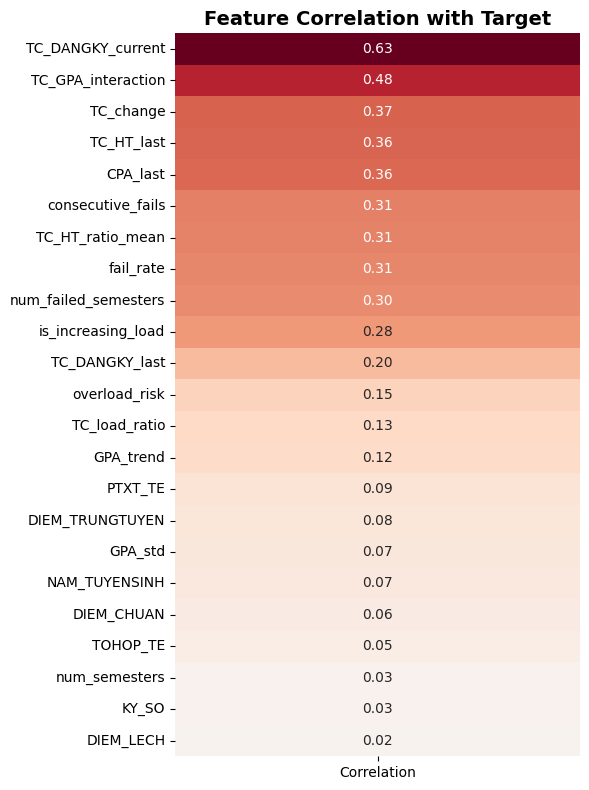

In [ ]:
print("\nPlotting Feature vs Target Correlation")

target_corr_df = (
    target_corr[selected_features]
    .sort_values(ascending=False)
    .to_frame(name='Correlation')
)

plt.figure(figsize=(6, max(8, len(target_corr_df) * 0.3)))
sns.heatmap(
    target_corr_df,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    cbar=False
)
plt.title('Feature Correlation with Target', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



Plotting Feature Correlation Heatmap


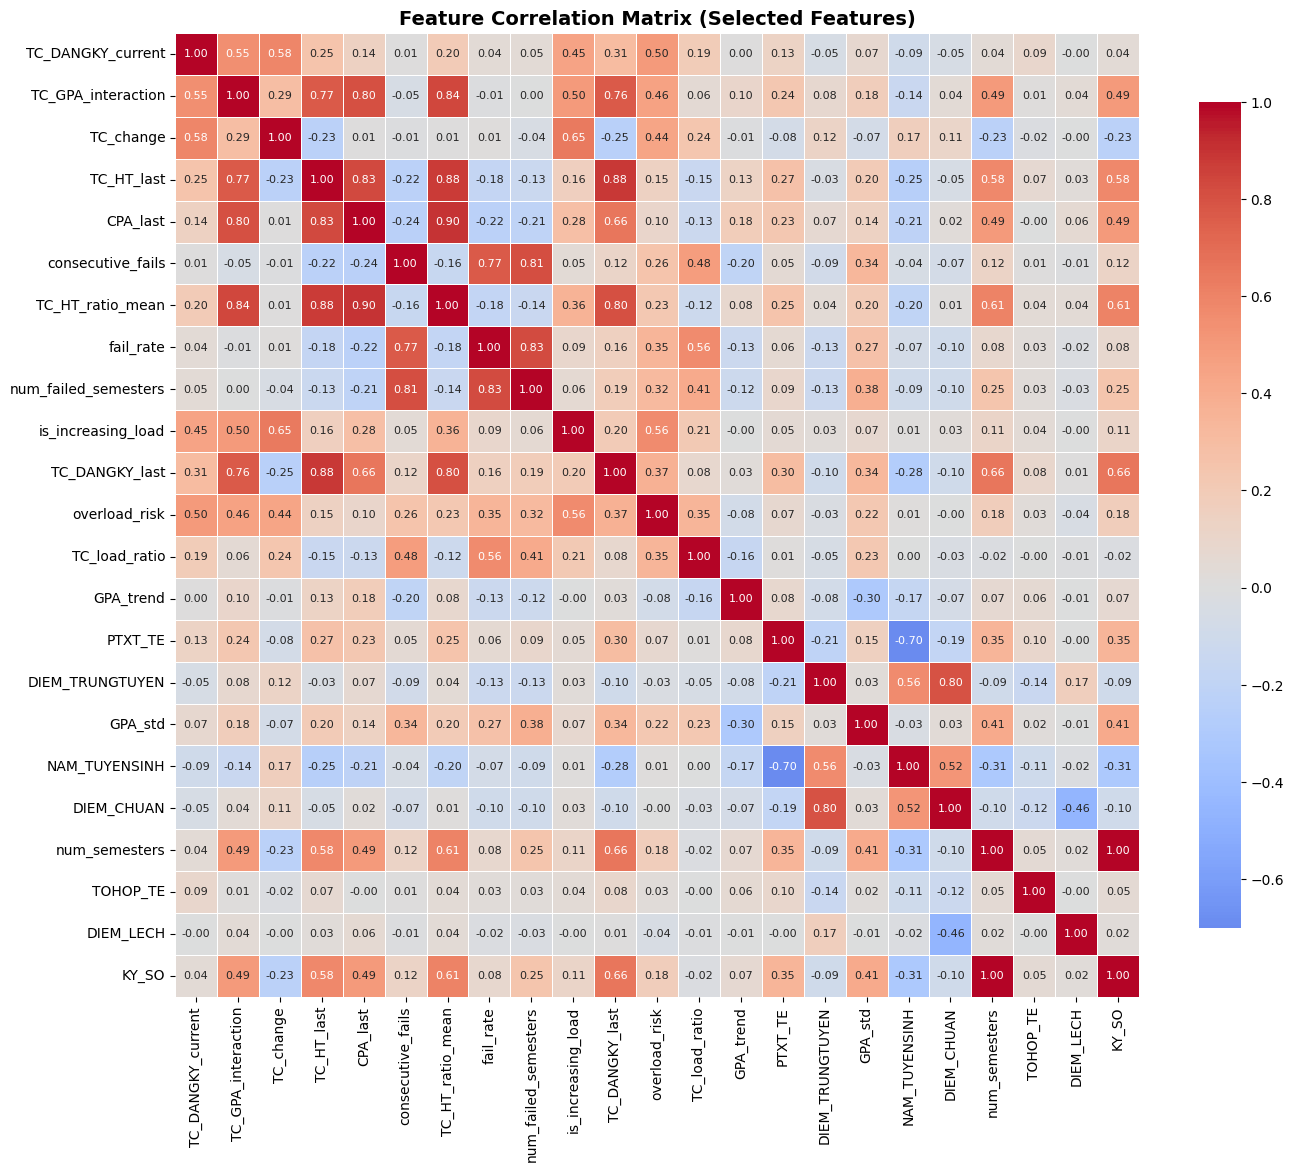

In [ ]:
print("\nPlotting Feature Correlation Heatmap")

corr_selected = df_train_enc[selected_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_selected,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True,
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.8}
)
plt.title('Feature Correlation Matrix (Selected Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.5 Prepare Data for Modeling

In [ ]:
print("PREPARING DATA FOR MODELING")

# Prepare train
X_train = df_train_enc[selected_features].copy()
y_train = df_train_enc['TC_HOANTHANH'].copy()

# Prepare val
X_val = df_val_enc[selected_features].copy()
y_val = df_val_enc['TC_HOANTHANH'].copy()

# Prepare test
X_test = df_test_enc[selected_features].copy()

print(f"\nData prepared:")
print(f"   Train: {X_train.shape}")
print(f"   Val:   {X_val.shape}")
print(f"   Test:  {X_test.shape}")

PREPARING DATA FOR MODELING

Data prepared:
   Train: (90582, 23)
   Val:   (15144, 23)
   Test:  (16502, 23)


In [ ]:
# Fill NaN with 0
train_nan = X_train.isnull().sum().sum()
val_nan = X_val.isnull().sum().sum()
test_nan = X_test.isnull().sum().sum()

if train_nan > 0:
    print(f"\nTrain has {train_nan} NaN - filling with 0")
    X_train = X_train.fillna(0)

if val_nan > 0:
    print(f"Val has {val_nan} NaN - filling with 0")
    X_val = X_val.fillna(0)

if test_nan > 0:
    print(f"Test has {test_nan} NaN - filling with 0")
    X_test = X_test.fillna(0)

# 4. MODEL TUNING & TRAINING

## 4.1 Define Parameter Grid for Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import time

print("=" * 80)
print("HYPERPARAMETER TUNING")
print("=" * 80)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

# Smaller grid for faster tuning (recommended)
param_grid_small = {
    'n_estimators': [150, 200, 250],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

print("\nParameter Grid (Small - Recommended for speed):")
for param, values in param_grid_small.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid_small.values()])
print(f"\n Total combinations to test: {total_combinations}")

HYPERPARAMETER TUNING

Parameter Grid (Small - Recommended for speed):
  n_estimators: [150, 200, 250]
  max_depth: [5, 6, 7]
  learning_rate: [0.03, 0.05, 0.07]
  subsample: [0.8]
  colsample_bytree: [0.8]

 Total combinations to test: 27


## 4.2 Perform Grid Search with Cross-Validation

In [ ]:
print("\n" + "=" * 80)
print("STARTING GRID SEARCH")
print("=" * 80)

# Base model
base_model = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid_small,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Use RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit grid search
start_time = time.time()
print(f"\nStarting training at {time.strftime('%H:%M:%S')}")
print(f"Training on {len(X_train):,} samples with 3-fold CV...")

grid_search.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

elapsed_time = time.time() - start_time
print(f"\nGrid search completed in {elapsed_time/60:.2f} minutes")


STARTING GRID SEARCH

Starting training at 15:39:10
Training on 90,582 samples with 3-fold CV...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/khanhtty/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/khanhtty/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain fea

[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=150, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=150, subsample=0.8; total time=   8.1s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=150, subsample=0.8; total time=   9.0s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=200, subsample=0.8; total time=   9.7s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=200, subsample=0.8; total time=   9.6s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=250, subsample=0.8; total time=   9.0s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=250, subsample=0.8; total time=   8.7s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=5, n_estimators=200, subsample=0.8; total time=  11.0s
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=6, n_estima

## 4.3 Analyze Tuning Results


In [ ]:
print("\n" + "=" * 80)
print("TUNING RESULTS")
print("=" * 80)

# Best parameters
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score (RMSE): {np.sqrt(-grid_search.best_score_):.4f}")

# Create results dataframe
cv_results = pd.DataFrame(grid_search.cv_results_)

# Sort by test score
cv_results_sorted = cv_results.sort_values('rank_test_score')

# Display top 10 configurations
print("\nTop 10 Configurations:")
display_cols = ['rank_test_score', 'mean_test_score', 'std_test_score', 
                'mean_train_score', 'std_train_score', 
                'param_n_estimators', 'param_max_depth', 'param_learning_rate']

top_10 = cv_results_sorted[display_cols].head(10).copy()
top_10['mean_test_rmse'] = np.sqrt(-top_10['mean_test_score'])
top_10['mean_train_rmse'] = np.sqrt(-top_10['mean_train_score'])

print(top_10[['rank_test_score', 'mean_test_rmse', 'mean_train_rmse', 
              'param_n_estimators', 'param_max_depth', 'param_learning_rate']])


TUNING RESULTS

Best Parameters:
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 7
  n_estimators: 250
  subsample: 0.8

Best CV Score (RMSE): 3.6938

Top 10 Configurations:
    rank_test_score  mean_test_rmse  mean_train_rmse param_n_estimators  \
17                1        3.693828         3.228907                250   
8                 2        3.693839         3.369802                250   
25                3        3.694179         3.186935                200   
16                4        3.695322         3.296868                200   
24                5        3.695915         3.278054                150   
26                6        3.696577         3.100706                250   
23                7        3.700133         3.327039                250   
7                 8        3.700820         3.422009                200   
15                9        3.702426         3.374748                150   
22               10        3.702820         3.390060            

## 4.4 Visualize Tuning Results

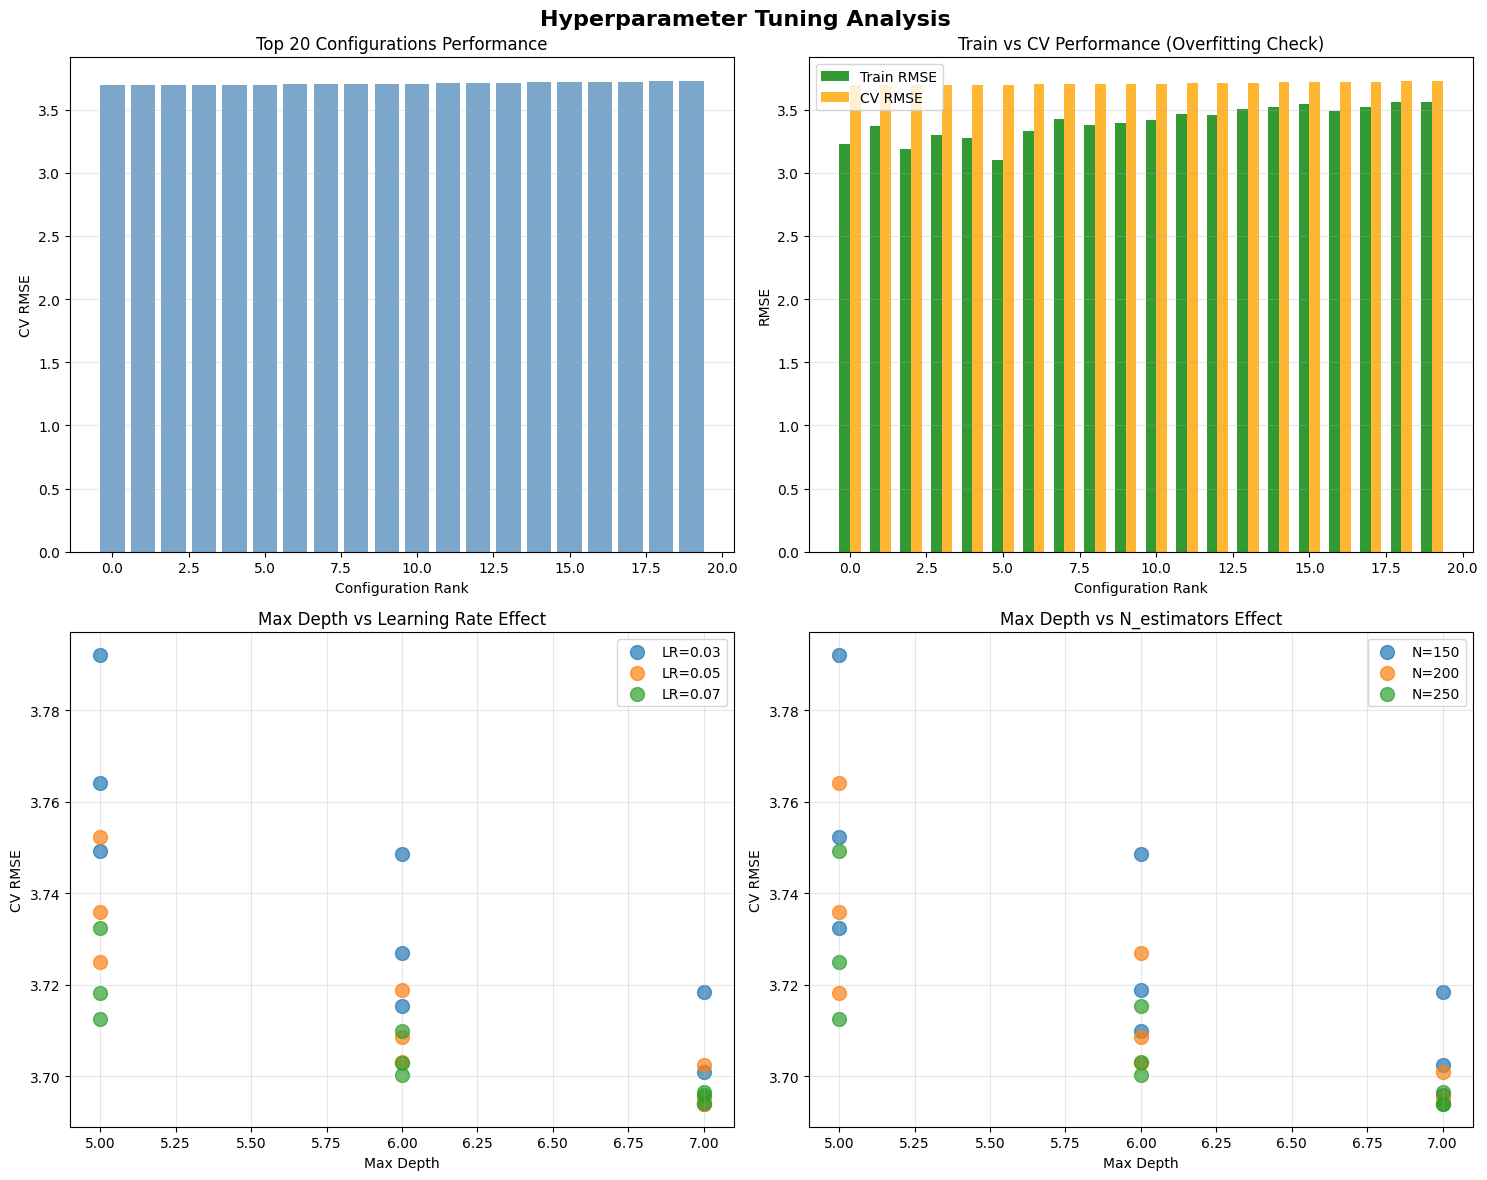

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Hyperparameter Tuning Analysis', fontsize=16, fontweight='bold')

# 1. CV Score vs Parameters
ax1 = axes[0, 0]
top_20 = cv_results_sorted.head(20)
x_pos = np.arange(len(top_20))
ax1.bar(x_pos, np.sqrt(-top_20['mean_test_score']), alpha=0.7, color='steelblue')
ax1.set_xlabel('Configuration Rank')
ax1.set_ylabel('CV RMSE')
ax1.set_title('Top 20 Configurations Performance')
ax1.grid(axis='y', alpha=0.3)

# 2. Train vs Validation Score (Overfitting Check)
ax2 = axes[0, 1]
train_rmse = np.sqrt(-cv_results_sorted.head(20)['mean_train_score'])
test_rmse = np.sqrt(-cv_results_sorted.head(20)['mean_test_score'])
x_pos = np.arange(len(train_rmse))
width = 0.35
ax2.bar(x_pos - width/2, train_rmse, width, label='Train RMSE', alpha=0.8, color='green')
ax2.bar(x_pos + width/2, test_rmse, width, label='CV RMSE', alpha=0.8, color='orange')
ax2.set_xlabel('Configuration Rank')
ax2.set_ylabel('RMSE')
ax2.set_title('Train vs CV Performance (Overfitting Check)')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Learning Rate Effect
ax3 = axes[1, 0]
for lr in cv_results['param_learning_rate'].unique():
    subset = cv_results[cv_results['param_learning_rate'] == lr]
    ax3.scatter(subset['param_max_depth'], 
               np.sqrt(-subset['mean_test_score']), 
               label=f'LR={lr}', s=100, alpha=0.7)
ax3.set_xlabel('Max Depth')
ax3.set_ylabel('CV RMSE')
ax3.set_title('Max Depth vs Learning Rate Effect')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. N_estimators Effect
ax4 = axes[1, 1]
for n_est in cv_results['param_n_estimators'].unique():
    subset = cv_results[cv_results['param_n_estimators'] == n_est]
    ax4.scatter(subset['param_max_depth'], 
               np.sqrt(-subset['mean_test_score']), 
               label=f'N={n_est}', s=100, alpha=0.7)
ax4.set_xlabel('Max Depth')
ax4.set_ylabel('CV RMSE')
ax4.set_title('Max Depth vs N_estimators Effect')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.5 Model Stability Analysis (Cross-Validation)


MODEL STABILITY ANALYSIS

5-Fold Cross-Validation Results:

Test RMSE:  3.6793 ± 0.0211
Train RMSE: 3.2729 ± 0.0088

Test MAE:   2.5413 ± 0.0073
Train MAE:  2.2892 ± 0.0068

Test R²:    0.6610 ± 0.0078
Train R²:   0.7319 ± 0.0018

Stability Check:
Model is STABLE (std=0.0211 < 0.5)

Overfitting Check:
  Train-Test Gap: -0.4064
No significant overfitting


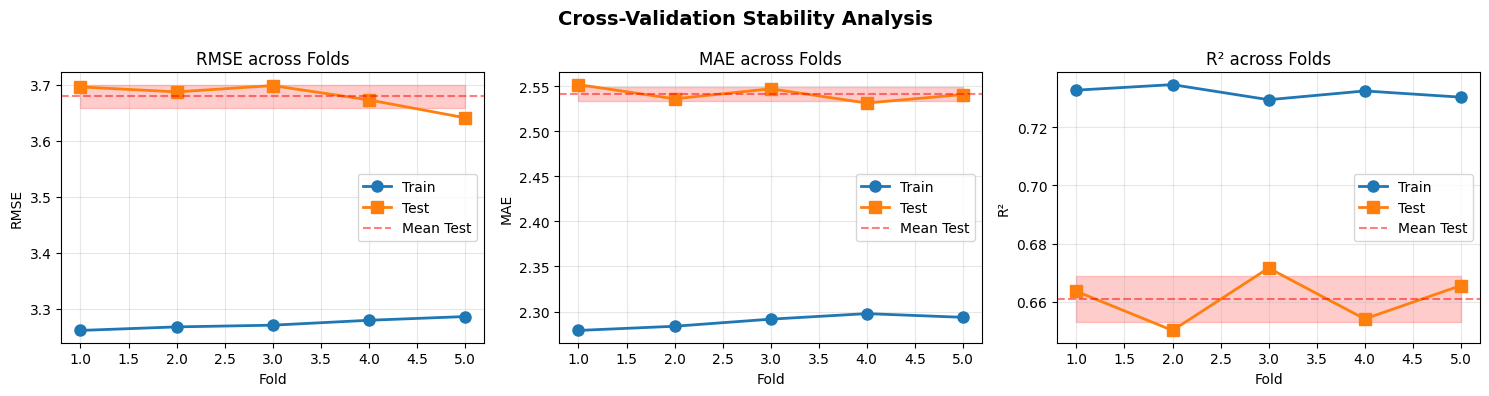

In [ ]:
print("\n" + "=" * 80)
print("MODEL STABILITY ANALYSIS")
print("=" * 80)

# Get best model
best_model = grid_search.best_estimator_

# Perform detailed cross-validation
from sklearn.model_selection import cross_validate

cv_scores = cross_validate(
    best_model,
    X_train,
    y_train,
    cv=5,  # 5-fold CV for stability check
    scoring={
        'neg_mse': 'neg_mean_squared_error',
        'neg_mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    },
    return_train_score=True,
    n_jobs=-1
)
# Calculate RMSE and MAE
cv_test_rmse = np.sqrt(-cv_scores['test_neg_mse'])
cv_train_rmse = np.sqrt(-cv_scores['train_neg_mse'])
cv_test_mae = -cv_scores['test_neg_mae']
cv_train_mae = -cv_scores['train_neg_mae']
cv_test_r2 = cv_scores['test_r2']
cv_train_r2 = cv_scores['train_r2']

print("\n5-Fold Cross-Validation Results:")
print(f"\nTest RMSE:  {cv_test_rmse.mean():.4f} ± {cv_test_rmse.std():.4f}")
print(f"Train RMSE: {cv_train_rmse.mean():.4f} ± {cv_train_rmse.std():.4f}")
print(f"\nTest MAE:   {cv_test_mae.mean():.4f} ± {cv_test_mae.std():.4f}")
print(f"Train MAE:  {cv_train_mae.mean():.4f} ± {cv_train_mae.std():.4f}")
print(f"\nTest R²:    {cv_test_r2.mean():.4f} ± {cv_test_r2.std():.4f}")
print(f"Train R²:   {cv_train_r2.mean():.4f} ± {cv_train_r2.std():.4f}")

# Stability check
print("\nStability Check:")
if cv_test_rmse.std() < 0.5:
    print(f"Model is STABLE (std={cv_test_rmse.std():.4f} < 0.5)")
else:
    print(f"Model has HIGH VARIANCE (std={cv_test_rmse.std():.4f} >= 0.5)")


# Overfitting check
overfit_gap = cv_train_rmse.mean() - cv_test_rmse.mean()
print(f"\nOverfitting Check:")
print(f"  Train-Test Gap: {overfit_gap:.4f}")
if abs(overfit_gap) < 1.0:
    print(f"No significant overfitting")
elif overfit_gap < 0:
    print(f"Test performs better than train (unusual)")
else:
    print(f"Possible overfitting detected")

# Visualize CV scores
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Cross-Validation Stability Analysis', fontsize=14, fontweight='bold')

# RMSE
ax1 = axes[0]
ax1.plot(range(1, 6), cv_train_rmse, 'o-', label='Train', linewidth=2, markersize=8)
ax1.plot(range(1, 6), cv_test_rmse, 's-', label='Test', linewidth=2, markersize=8)
ax1.axhline(cv_test_rmse.mean(), color='red', linestyle='--', alpha=0.5, label='Mean Test')
ax1.fill_between(range(1, 6), 
                 cv_test_rmse.mean() - cv_test_rmse.std(),
                 cv_test_rmse.mean() + cv_test_rmse.std(),
                 alpha=0.2, color='red')
ax1.set_xlabel('Fold')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE across Folds')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE
ax2 = axes[1]
ax2.plot(range(1, 6), cv_train_mae, 'o-', label='Train', linewidth=2, markersize=8)
ax2.plot(range(1, 6), cv_test_mae, 's-', label='Test', linewidth=2, markersize=8)
ax2.axhline(cv_test_mae.mean(), color='red', linestyle='--', alpha=0.5, label='Mean Test')
ax2.fill_between(range(1, 6), 
                 cv_test_mae.mean() - cv_test_mae.std(),
                 cv_test_mae.mean() + cv_test_mae.std(),
                 alpha=0.2, color='red')
ax2.set_xlabel('Fold')
ax2.set_ylabel('MAE')
ax2.set_title('MAE across Folds')
ax2.legend()
ax2.grid(True, alpha=0.3)

# R²
ax3 = axes[2]
ax3.plot(range(1, 6), cv_train_r2, 'o-', label='Train', linewidth=2, markersize=8)
ax3.plot(range(1, 6), cv_test_r2, 's-', label='Test', linewidth=2, markersize=8)
ax3.axhline(cv_test_r2.mean(), color='red', linestyle='--', alpha=0.5, label='Mean Test')
ax3.fill_between(range(1, 6), 
                 cv_test_r2.mean() - cv_test_r2.std(),
                 cv_test_r2.mean() + cv_test_r2.std(),
                 alpha=0.2, color='red')
ax3.set_xlabel('Fold')
ax3.set_ylabel('R²')
ax3.set_title('R² across Folds')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.6 Train Final Model with Best Parameters


In [ ]:
print("\n" + "=" * 80)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("=" * 80)

# Get best parameters
best_params = grid_search.best_params_.copy()
best_params['random_state'] = 42
best_params['n_jobs'] = -1

print(f"\nFinal Parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# Train final model
model = XGBRegressor(**best_params)

print(f"\nTraining on {len(X_train):,} samples...")
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

print("Training completed!")


TRAINING FINAL MODEL WITH BEST PARAMETERS

Final Parameters:
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 7
  n_estimators: 250
  subsample: 0.8
  random_state: 42
  n_jobs: -1

Training on 90,582 samples...


Training completed!


# 5. EVALUATION & SUBMISSION

## 5.1 Evaluate Model

In [ ]:
print("=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

# Predict
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

# Calculate metrics
def calc_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Accuracy within threshold
    acc_1 = np.mean(np.abs(y_true - y_pred) <= 1) * 100
    acc_2 = np.mean(np.abs(y_true - y_pred) <= 2) * 100
    
    print(f"\n{name}:")
    print(f"  MAE:   {mae:.3f}")
    print(f"  RMSE:  {rmse:.3f}")
    print(f"  R²:    {r2:.3f}")
    print(f"  Acc (±1 credit): {acc_1:.1f}%")
    print(f"  Acc (±2 credits): {acc_2:.1f}%")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'acc_1': acc_1,
        'acc_2': acc_2
    }

metrics_train = calc_metrics(y_train, y_pred_train, "TRAIN")
metrics_val = calc_metrics(y_val, y_pred_val, "VALIDATION")

# Check overfitting
print(f"\nOverfitting Check:")
diff = metrics_val['rmse'] - metrics_train['rmse']
print(f"  RMSE difference: {diff:.3f}")
if diff > 2.0:
    print(f"Possible overfitting")
elif diff < 0:
    print(f"Unusual pattern")
else:
    print(f"Model looks good!")

# Compare with CV results
print(f"\nComparison with Cross-Validation:")
print(f"  CV RMSE:         {cv_test_rmse.mean():.3f} ± {cv_test_rmse.std():.3f}")
print(f"  Validation RMSE: {metrics_val['rmse']:.3f}")
if abs(metrics_val['rmse'] - cv_test_rmse.mean()) < cv_test_rmse.std():
    print(f"  Consistent with CV results")
else:
    print(f"  Differs from CV results")



MODEL EVALUATION



TRAIN:
  MAE:   2.318
  RMSE:  3.317
  R²:    0.725
  Acc (±1 credit): 34.0%
  Acc (±2 credits): 58.1%

VALIDATION:
  MAE:   2.649
  RMSE:  3.804
  R²:    0.694
  Acc (±1 credit): 32.6%
  Acc (±2 credits): 53.8%

Overfitting Check:
  RMSE difference: 0.487
Model looks good!

Comparison with Cross-Validation:
  CV RMSE:         3.679 ± 0.021
  Validation RMSE: 3.804
  Differs from CV results


## 5.2 Comprehensive Results

In [ ]:
print("\n" + "="*80)
print("SAVING COMPREHENSIVE RESULTS FOR REPORT")
print("="*80)

# Create output directories
RESULTS_DIR = './outputs'
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(f'{RESULTS_DIR}/plots', exist_ok=True)
os.makedirs(f'{RESULTS_DIR}/metrics', exist_ok=True)
os.makedirs(f'{RESULTS_DIR}/explainability', exist_ok=True)



SAVING COMPREHENSIVE RESULTS FOR REPORT


***SAVE ALL METRICS***

In [ ]:
print("\nSaving Metrics...")

def save_all_metrics(y_true, y_pred, name, folder):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE
    mask = y_true != 0
    mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100 if mask.any() else 0
    
    # Accuracy
    acc_1 = np.mean(np.abs(y_true - y_pred) <= 1) * 100
    acc_2 = np.mean(np.abs(y_true - y_pred) <= 2) * 100
    acc_3 = np.mean(np.abs(y_true - y_pred) <= 3) * 100
    
    metrics = {
        'dataset': name,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'MAE': float(mae),
        'MSE': float(mse),
        'RMSE': float(rmse),
        'R2': float(r2),
        'MAPE': float(mape),
        'Accuracy_within_1': float(acc_1),
        'Accuracy_within_2': float(acc_2),
        'Accuracy_within_3': float(acc_3),
        'n_samples': int(len(y_true)),
    }
    
    # Save JSON & CSV
    with open(f'{folder}/metrics_{name}.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    pd.DataFrame([metrics]).to_csv(f'{RESULTS_DIR}/metrics/metrics_{name}.csv', index=False)
    
    print(f"   Saved metrics_{name}.json and .csv")
    return metrics

# SỬA THÀNH:
metrics_train = save_all_metrics(y_train, y_pred_train, 'train', f'{RESULTS_DIR}/metrics')
metrics_val = save_all_metrics(y_val, y_pred_val, 'validation', f'{RESULTS_DIR}/metrics')


Saving Metrics...
   Saved metrics_train.json and .csv
   Saved metrics_validation.json and .csv


***FEATURE IMPORTANCE (XGBoost built-in)***


 Saving Feature Importance...


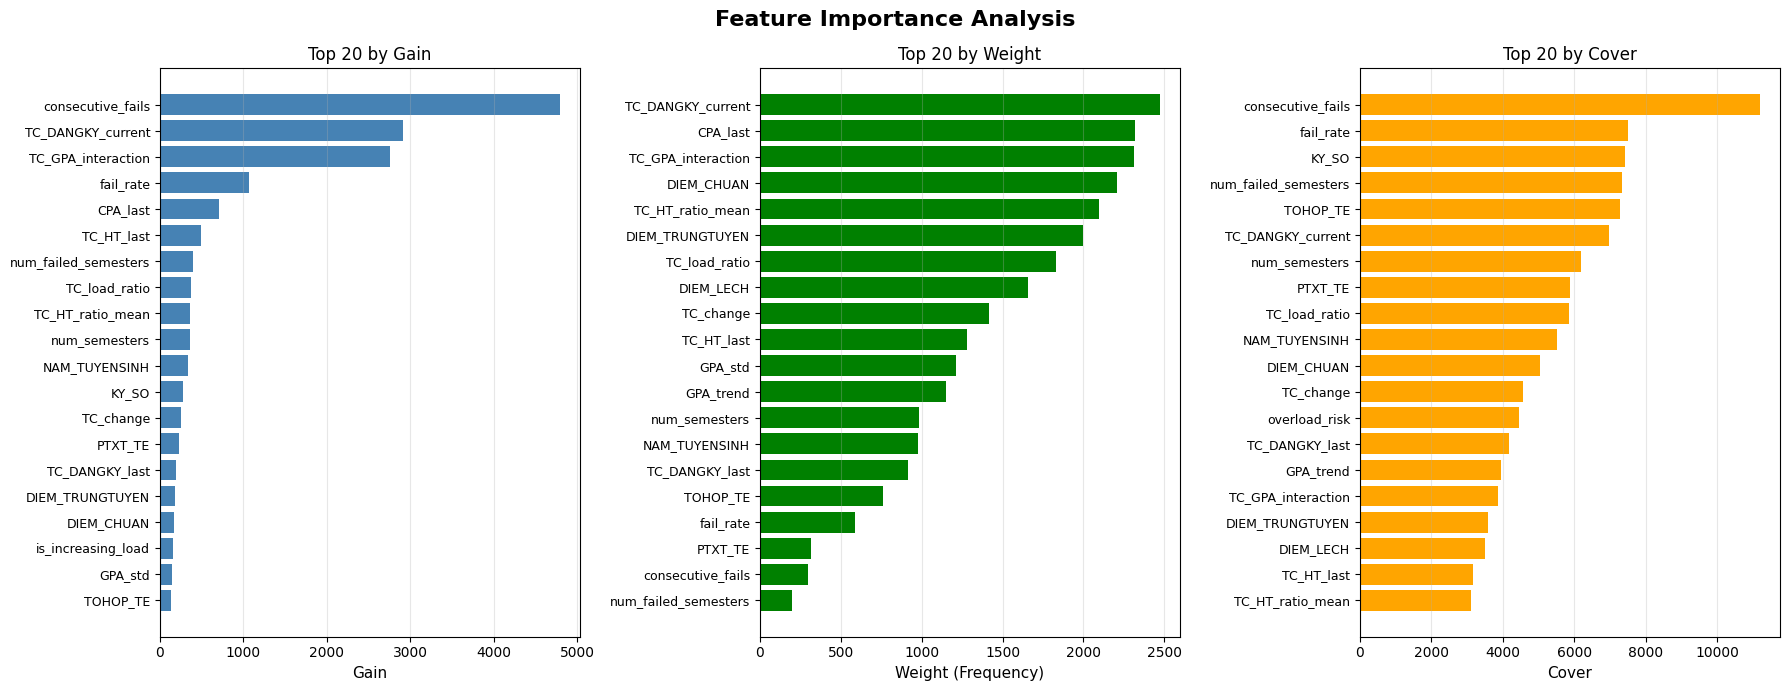

   Saved feature_importance.csv and .png


In [ ]:
print("\n Saving Feature Importance...")

importance_gain = model.get_booster().get_score(importance_type='gain')
importance_weight = model.get_booster().get_score(importance_type='weight')
importance_cover = model.get_booster().get_score(importance_type='cover')

importance_df = pd.DataFrame({
    'feature': list(importance_gain.keys()),
    'gain': list(importance_gain.values()),
    'weight': [importance_weight.get(k, 0) for k in importance_gain.keys()],
    'cover': [importance_cover.get(k, 0) for k in importance_gain.keys()],
}).sort_values('gain', ascending=False)


importance_df.to_csv(f'{RESULTS_DIR}/metrics/feature_importance.csv', index=False)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 7))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

top_n = min(20, len(importance_df))

# Gain
top_gain = importance_df.nlargest(top_n, 'gain')
axes[0].barh(range(top_n), top_gain['gain'].values, color='steelblue')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_gain['feature'].values, fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel('Gain', fontsize=11)
axes[0].set_title('Top 20 by Gain', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Weight
top_weight = importance_df.nlargest(top_n, 'weight')
axes[1].barh(range(top_n), top_weight['weight'].values, color='green')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(top_weight['feature'].values, fontsize=9)
axes[1].invert_yaxis()
axes[1].set_xlabel('Weight (Frequency)', fontsize=11)
axes[1].set_title('Top 20 by Weight', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

# Cover
top_cover = importance_df.nlargest(top_n, 'cover')
axes[2].barh(range(top_n), top_cover['cover'].values, color='orange')
axes[2].set_yticks(range(top_n))
axes[2].set_yticklabels(top_cover['feature'].values, fontsize=9)
axes[2].invert_yaxis()
axes[2].set_xlabel('Cover', fontsize=11)
axes[2].set_title('Top 20 by Cover', fontsize=12)
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/plots/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("   Saved feature_importance.csv and .png")

SHAP VALUES


Calculating SHAP Values (Kernel SHAP)...


  0%|          | 0/200 [00:00<?, ?it/s]

   Saved shap_values.csv


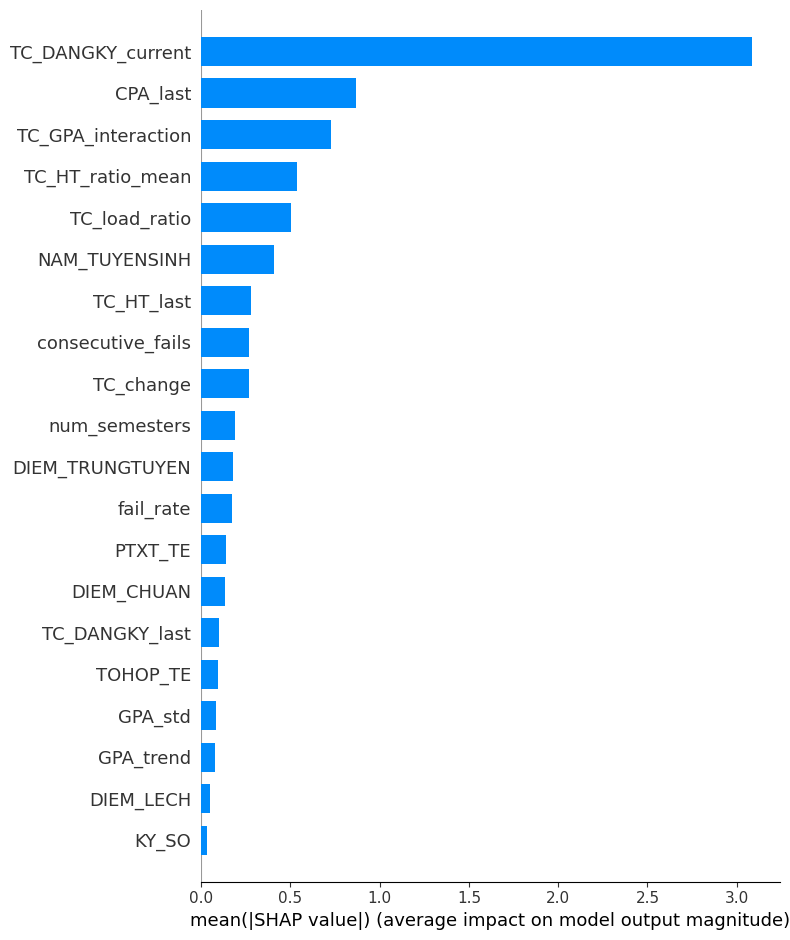

    Saved shap_summary_bar.png


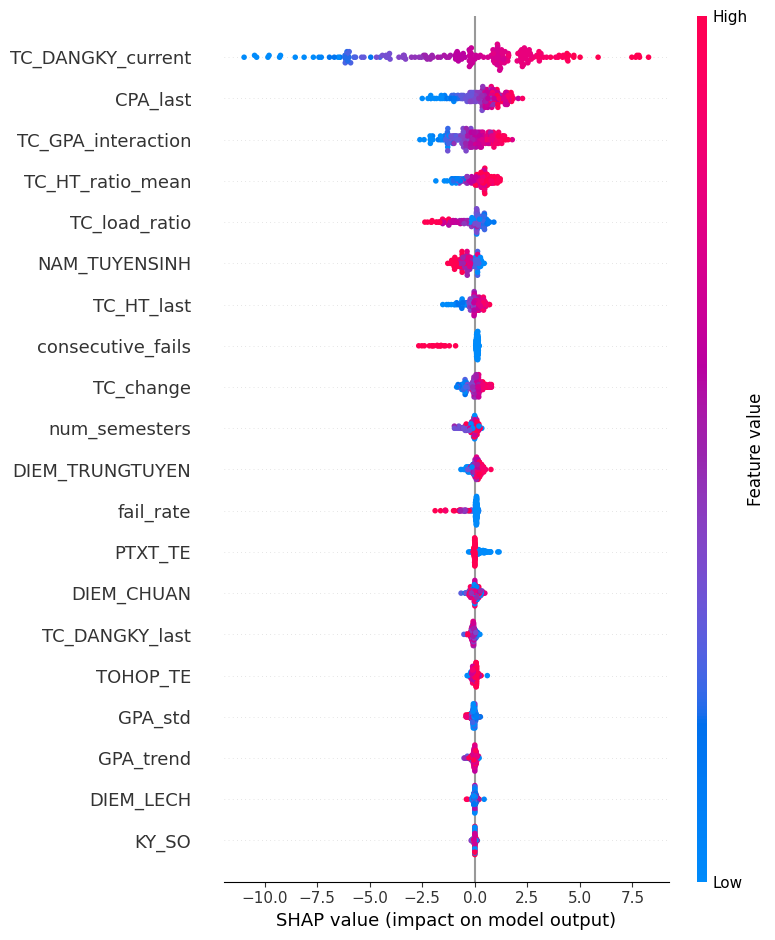

    Saved shap_summary_beeswarm.png


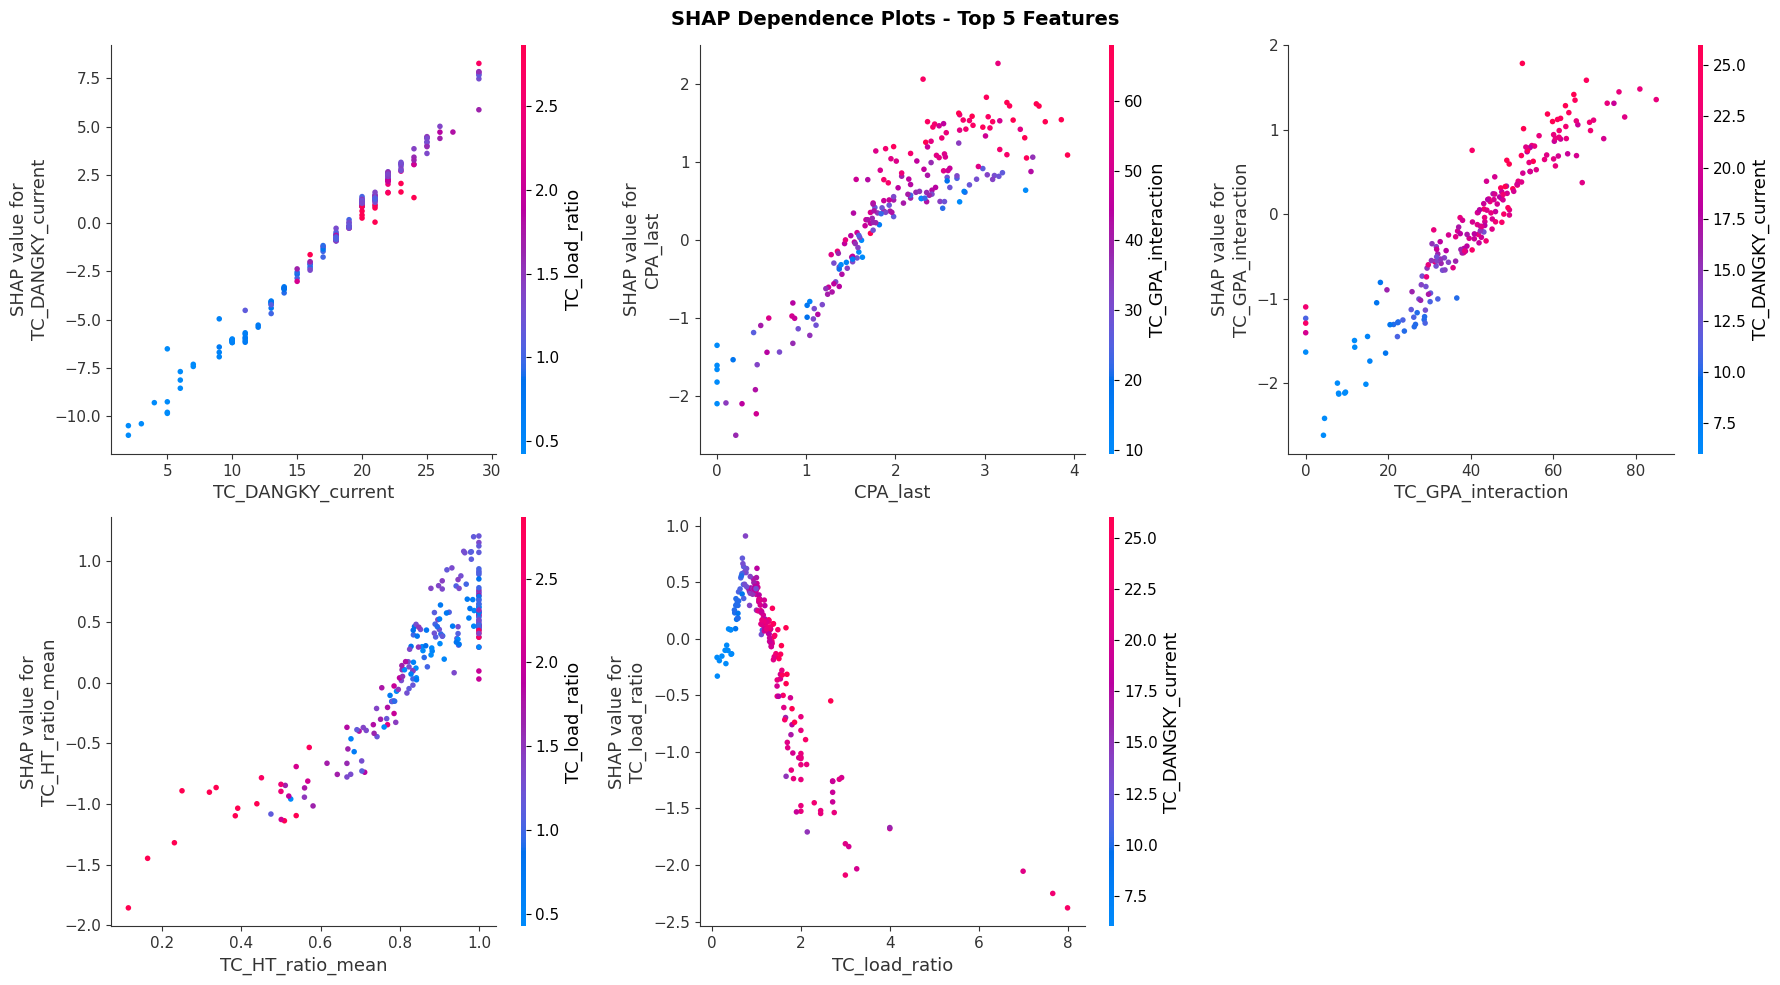

    Saved shap_dependence_plots.png
    Saved shap_feature_importance.csv


In [ ]:
print("\nCalculating SHAP Values (Kernel SHAP)...")

# Wrapper predict (BẮT BUỘC)

def model_predict(X):
    if isinstance(X, pd.DataFrame):
        return model.predict(X)
    else:
        return model.predict(pd.DataFrame(X, columns=selected_features))


# Background & SHAP sample

background = shap.sample(
    X_train,
    min(100, len(X_train)),
    random_state=42
)

shap_sample_size = min(200, len(X_val))
shap_idx = np.random.choice(len(X_val), shap_sample_size, replace=False)
X_shap = X_val.iloc[shap_idx]


# Kernel SHAP
explainer = shap.KernelExplainer(
    model_predict,
    background
)

shap_values = explainer.shap_values(X_shap)

# Regression safeguard
if isinstance(shap_values, list):
    shap_values = shap_values[0]

shap_df = pd.DataFrame(shap_values, columns=selected_features)
shap_df.to_csv(f'{RESULTS_DIR}/explainability/shap_values.csv', index=False)
print("   Saved shap_values.csv")


# SHAP SUMMARY PLOTS


# Bar plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    show=False
)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/plots/shap_summary_bar.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("    Saved shap_summary_bar.png")
# Beeswarm plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_shap,
    show=False
)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/plots/shap_summary_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("    Saved shap_summary_beeswarm.png")


# SHAP DEPENDENCE PLOTS (Top 5)
shap_importance = np.abs(shap_values).mean(axis=0)
top_5_idx = np.argsort(shap_importance)[-5:][::-1]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(
    'SHAP Dependence Plots - Top 5 Features',
    fontsize=14,
    fontweight='bold'
)
for i, idx in enumerate(top_5_idx):
    row, col = i // 3, i % 3
    feature_name = X_shap.columns[idx]

    shap.dependence_plot(
        feature_name,
        shap_values,
        X_shap,
        ax=axes[row, col],
        show=False
    )

axes[1, 2].axis('off')
plt.tight_layout()
plt.show()
plt.savefig(f'{RESULTS_DIR}/plots/shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.close()
print("    Saved shap_dependence_plots.png")


# MEAN SHAP FEATURE IMPORTANCE
mean_shap_df = (
    pd.DataFrame({
        'feature': X_shap.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    })
    .sort_values('mean_abs_shap', ascending=False)
)

mean_shap_df.to_csv(
    f'{RESULTS_DIR}/metrics/shap_feature_importance.csv',
    index=False
)
print("    Saved shap_feature_importance.csv")

***LIME EXPLANATIONS***

In [ ]:
print("\n Generating LIME Explanations...")

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode='regression',
    verbose=False
)

# Select 9 diverse samples
val_preds = model.predict(X_val)
errors = np.abs(val_preds - y_val)

best_idx = np.argsort(errors)[:3] # 3 best 
median_idx = np.argsort(np.abs(errors - np.median(errors)))[:3] # 3 median 
worst_idx = np.argsort(errors)[-3:] # 3 worst 

sample_indices = np.concatenate([best_idx, median_idx, worst_idx])

lime_results = []
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle(' LIME Explanations - Sample Predictions', fontsize=16, fontweight='bold')

for i, idx in enumerate(sample_indices):
    row, col = i // 3, i % 3
    ax = axes[row, col]

    exp = lime_explainer.explain_instance(
        data_row=X_val.iloc[idx].values,
        predict_fn=lambda x: model.predict(x),
        num_features=10
    )

    pred = val_preds[idx]
    actual = y_val.iloc[idx]

    exp_list = exp.as_list()
    lime_results.append({
        'sample_id': int(idx),
        'actual': float(actual),
        'predicted': float(pred),
        'error': float(actual - pred),
        'explanation': exp_list
    })

    features = [f[0] for f in exp_list]
    values = [f[1] for f in exp_list]
    colors = ['green' if v > 0 else 'red' for v in values]

    ax.barh(range(len(features)), values, alpha=0.7)
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features, fontsize=7)
    ax.invert_yaxis()
    ax.set_title(f'Sample {idx} | Actual: {actual:.1f}, Pred: {pred:.1f}', fontsize=9)
    ax.axvline(x=0, color='black', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/plots/lime_explanations.png', dpi=300, bbox_inches='tight')
plt.show()

with open(f'{RESULTS_DIR}/explainability/lime_explanations.json', 'w', encoding='utf-8') as f:
    json.dump(lime_results, f, indent=2, ensure_ascii=False)

print("    Saved lime_explanations.json and .png")


 Generating LIME Explanations...


***PREDICTION ANALYSIS PLOTS***


Creating Prediction Analysis Plots...


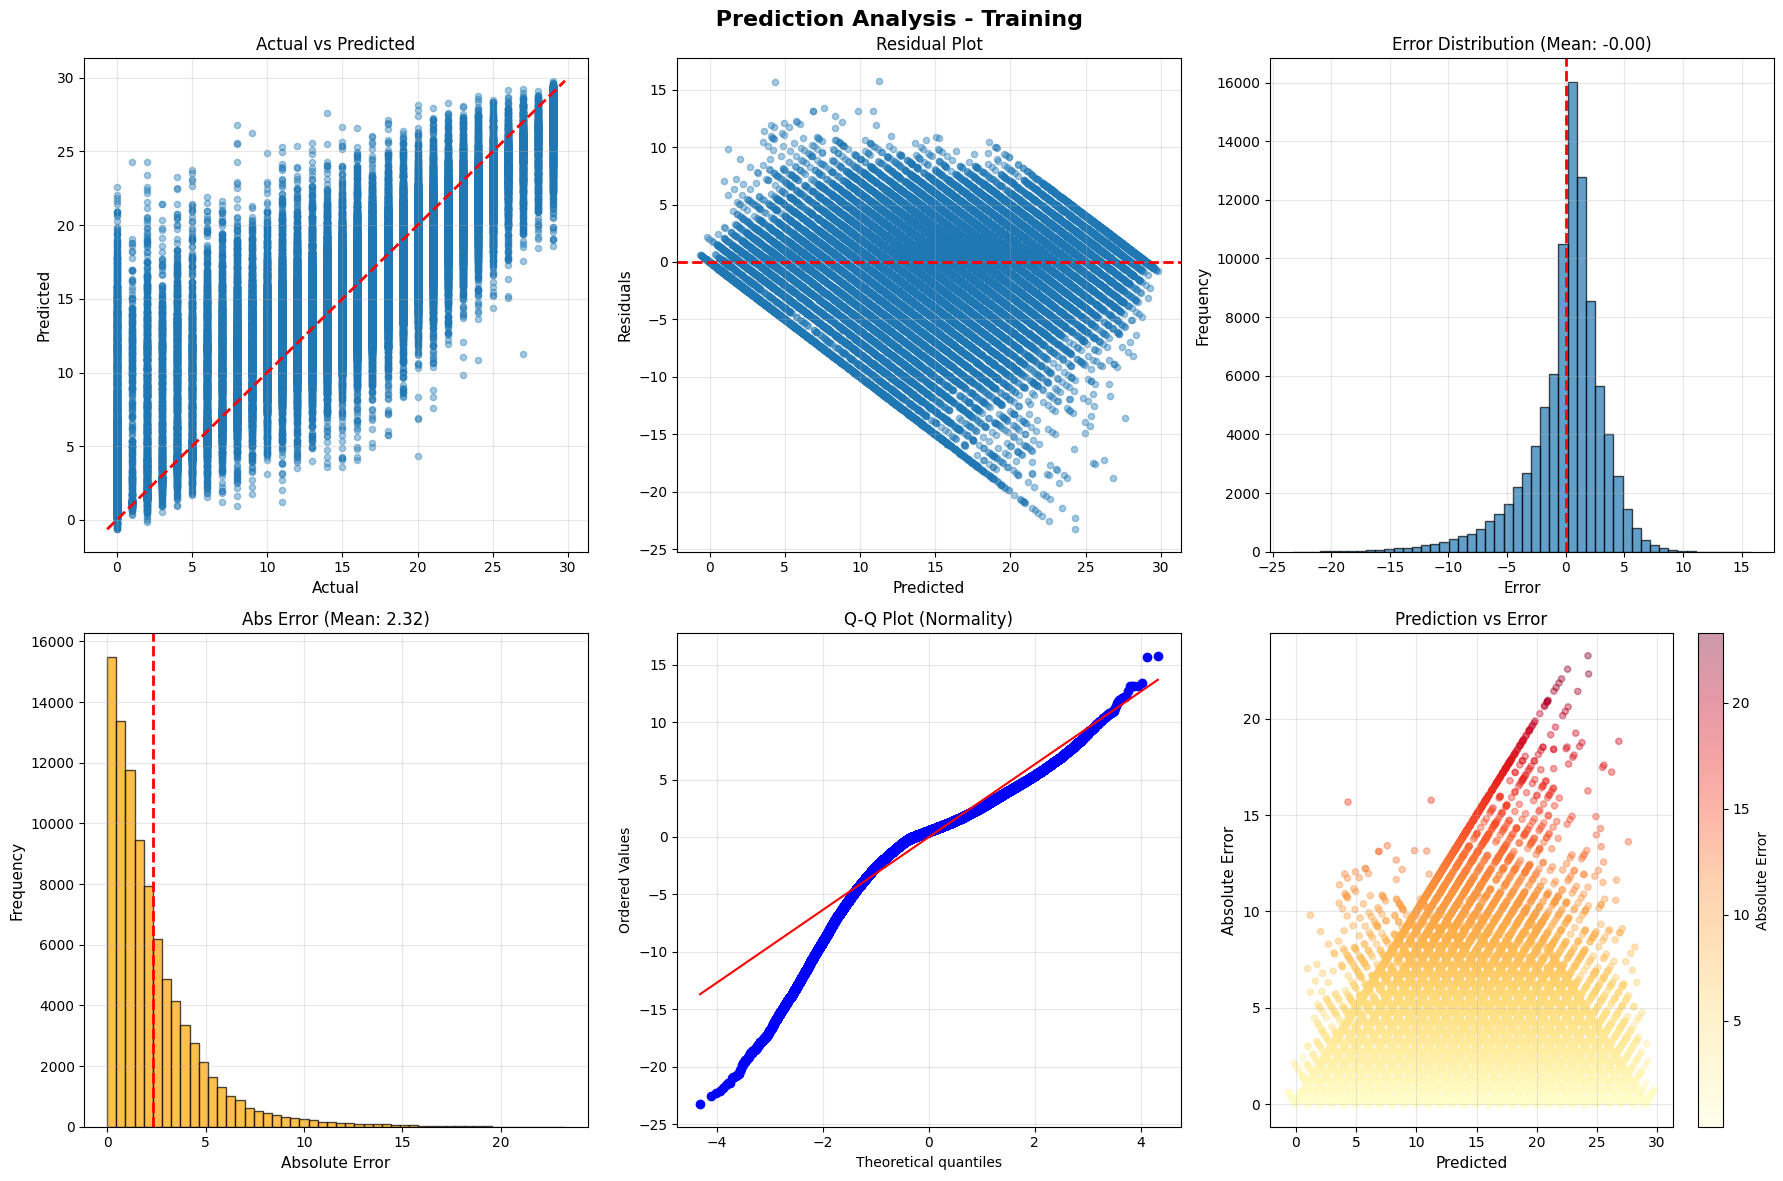

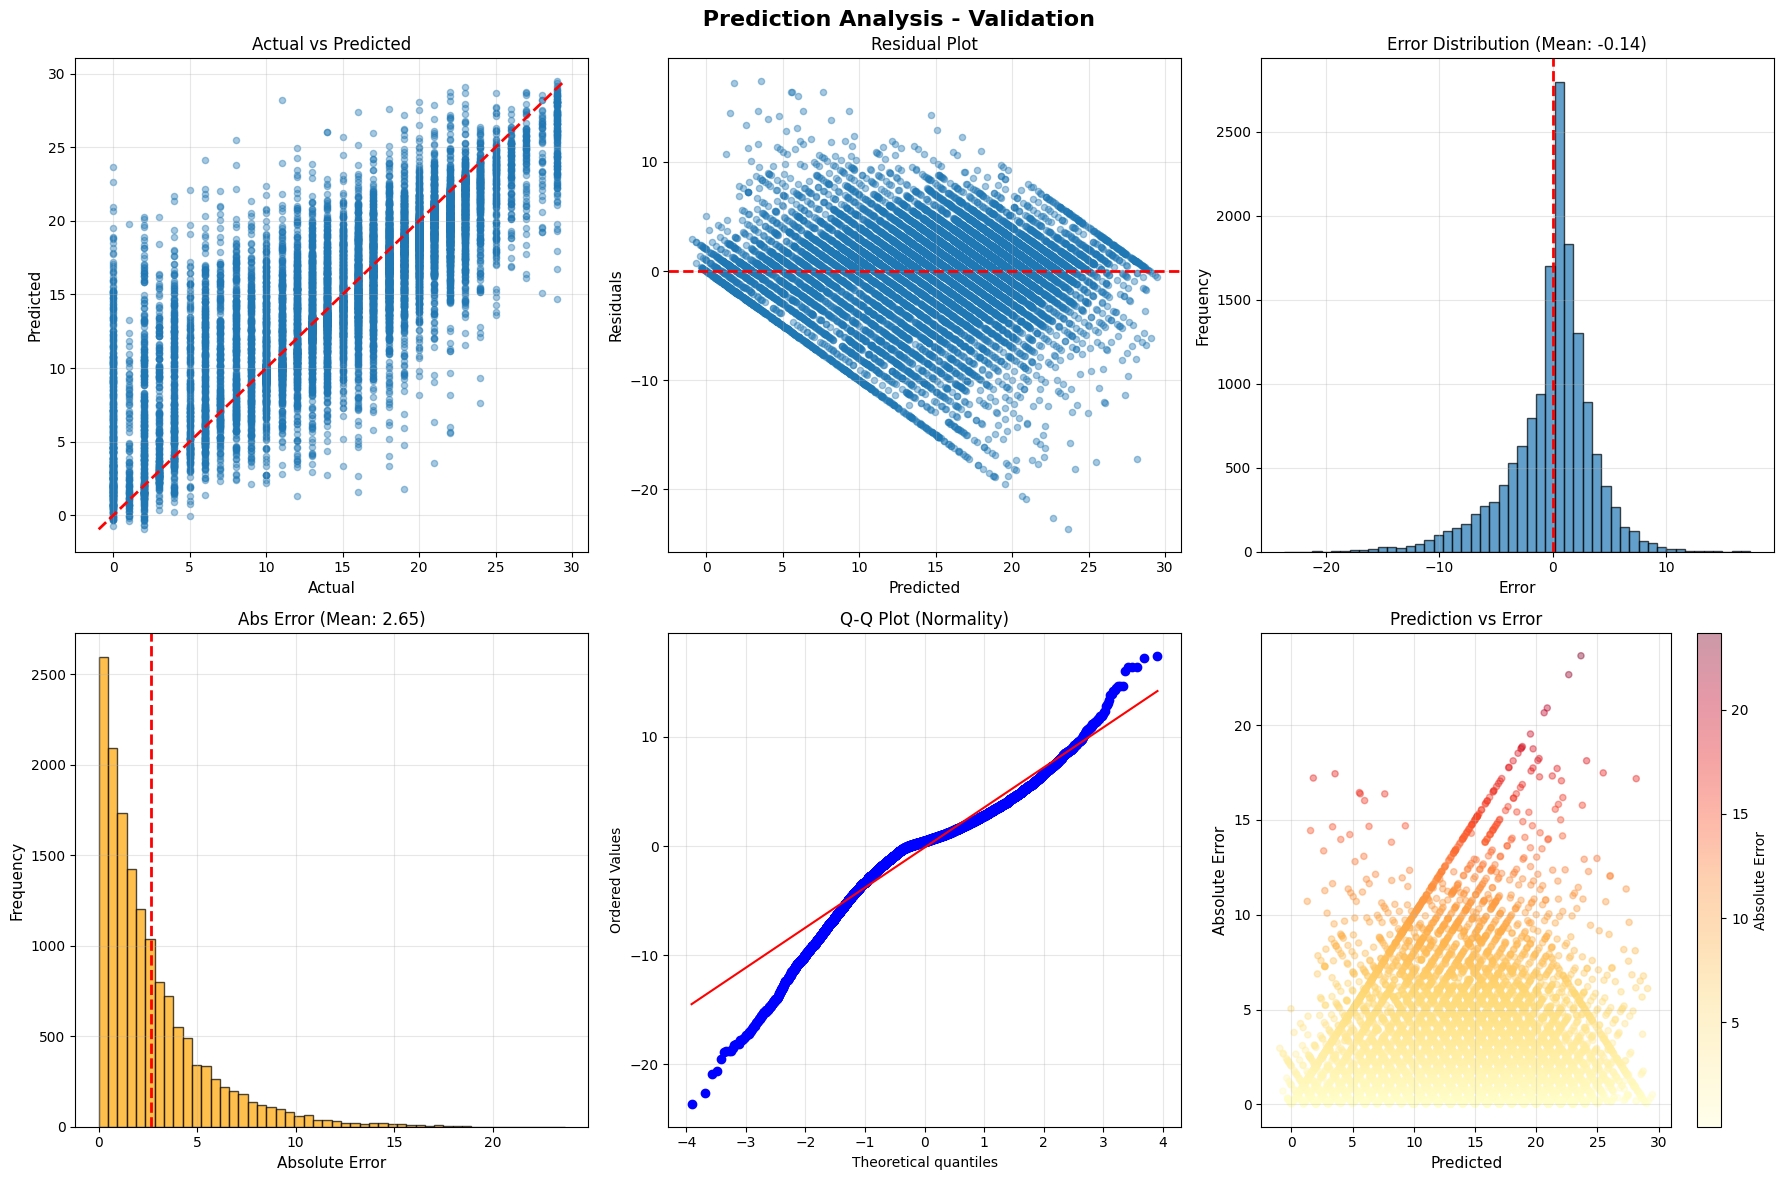

    Saved prediction_analysis plots


In [ ]:
print("\nCreating Prediction Analysis Plots...")

def plot_prediction_analysis(y_true, y_pred, name, save_path):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f' Prediction Analysis - {name}', fontsize=16, fontweight='bold')
    
    # Convert to numpy if needed
    y_true_arr = y_true.values if hasattr(y_true, 'values') else y_true
    y_pred_arr = y_pred if isinstance(y_pred, np.ndarray) else np.array(y_pred)
    
    residuals = y_true_arr - y_pred_arr
    
    # 1. Actual vs Predicted
    axes[0, 0].scatter(y_true_arr, y_pred_arr, alpha=0.4, s=20)
    min_val, max_val = min(y_true_arr.min(), y_pred_arr.min()), max(y_true_arr.max(), y_pred_arr.max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual', fontsize=11)
    axes[0, 0].set_ylabel('Predicted', fontsize=11)
    axes[0, 0].set_title('Actual vs Predicted', fontsize=12)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Residuals
    axes[0, 1].scatter(y_pred_arr, residuals, alpha=0.4, s=20)
    axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0, 1].set_xlabel('Predicted', fontsize=11)
    axes[0, 1].set_ylabel('Residuals', fontsize=11)
    axes[0, 1].set_title('Residual Plot', fontsize=12)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Error Distribution
    axes[0, 2].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 2].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[0, 2].set_xlabel('Error', fontsize=11)
    axes[0, 2].set_ylabel('Frequency', fontsize=11)
    axes[0, 2].set_title(f'Error Distribution (Mean: {residuals.mean():.2f})', fontsize=12)
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Absolute Error
    abs_errors = np.abs(residuals)
    axes[1, 0].hist(abs_errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 0].axvline(x=abs_errors.mean(), color='r', linestyle='--', lw=2)
    axes[1, 0].set_xlabel('Absolute Error', fontsize=11)
    axes[1, 0].set_ylabel('Frequency', fontsize=11)
    axes[1, 0].set_title(f'Abs Error (Mean: {abs_errors.mean():.2f})', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Q-Q Plot
    stats.probplot(residuals.ravel(), dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot (Normality)', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Prediction vs Abs Error
    sc = axes[1, 2].scatter(y_pred_arr, abs_errors, alpha=0.4, s=20, c=abs_errors, cmap='YlOrRd')
    plt.colorbar(sc, ax=axes[1, 2], label='Absolute Error')
    axes[1, 2].set_xlabel('Predicted', fontsize=11)
    axes[1, 2].set_ylabel('Absolute Error', fontsize=11)
    axes[1, 2].set_title('Prediction vs Error', fontsize=12)
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_prediction_analysis(y_train, y_pred_train, 'Training', 
                        f'{RESULTS_DIR}/prediction_analysis_train.png')
plot_prediction_analysis(y_val, y_pred_val, 'Validation',
                        f'{RESULTS_DIR}/prediction_analysis_validation.png')
print("    Saved prediction_analysis plots")

***SAVE CV RESULTS***


 Saving Cross-Validation Results...


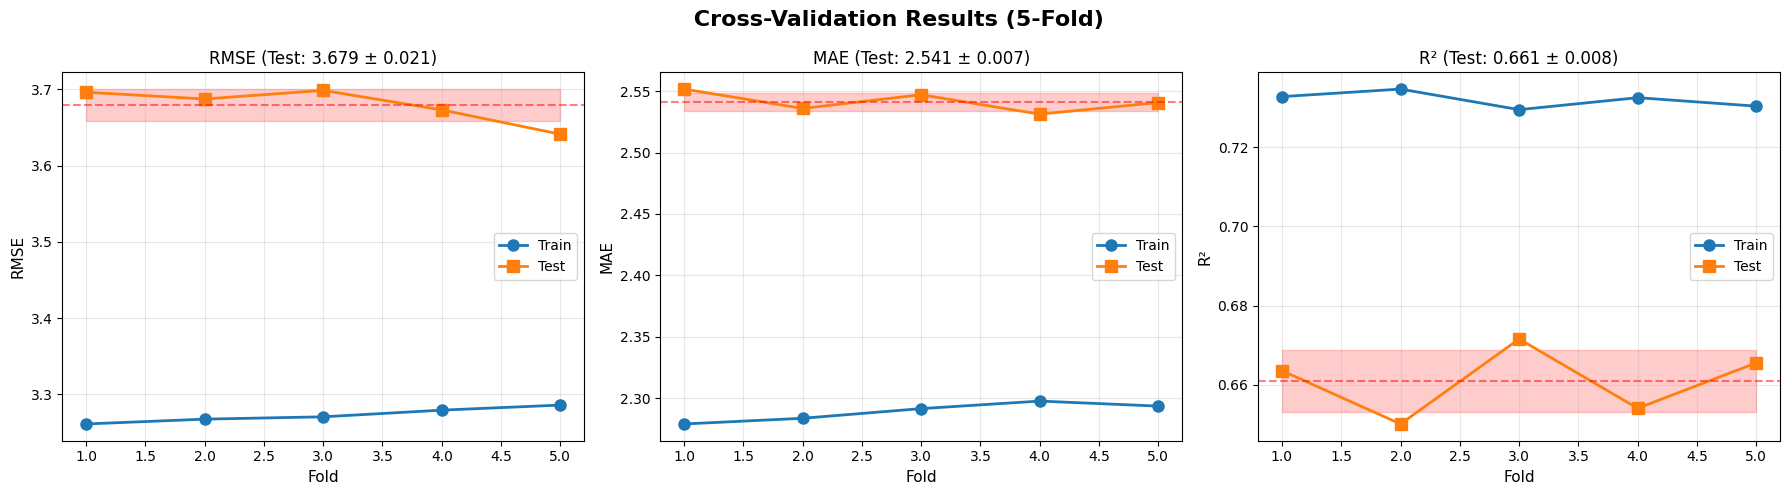

    Saved cv_fold_results.csv, cv_summary.json, and cv_results.png


In [96]:
print("\n Saving Cross-Validation Results...")

cv_test_rmse = np.sqrt(-cv_scores['test_neg_mse'])
cv_train_rmse = np.sqrt(-cv_scores['train_neg_mse'])
cv_test_mae = -cv_scores['test_neg_mae']
cv_train_mae = -cv_scores['train_neg_mae']
cv_test_r2 = cv_scores['test_r2']
cv_train_r2 = cv_scores['train_r2']

cv_df = pd.DataFrame({
    'fold': range(1, 6),
    'test_rmse': cv_test_rmse,
    'train_rmse': cv_train_rmse,
    'test_mae': cv_test_mae,
    'train_mae': cv_train_mae,
    'test_r2': cv_test_r2,
    'train_r2': cv_train_r2,
})
cv_df.to_csv(f'{RESULTS_DIR}/metrics/cv_fold_results.csv', index=False)

cv_summary = {
    'test_rmse_mean': float(cv_test_rmse.mean()),
    'test_rmse_std': float(cv_test_rmse.std()),
    'test_mae_mean': float(cv_test_mae.mean()),
    'test_mae_std': float(cv_test_mae.std()),
    'test_r2_mean': float(cv_test_r2.mean()),
    'test_r2_std': float(cv_test_r2.std()),
}

with open(f'{RESULTS_DIR}/metrics/cv_summary.json', 'w') as f:
    json.dump(cv_summary, f, indent=2)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(' Cross-Validation Results (5-Fold)', fontsize=16, fontweight='bold')

folds = range(1, 6)

for idx, (metric_name, train_vals, test_vals) in enumerate([
    ('RMSE', cv_train_rmse, cv_test_rmse),
    ('MAE', cv_train_mae, cv_test_mae),
    ('R²', cv_train_r2, cv_test_r2)
]):
    ax = axes[idx]
    ax.plot(folds, train_vals, 'o-', label='Train', linewidth=2, markersize=8)
    ax.plot(folds, test_vals, 's-', label='Test', linewidth=2, markersize=8)
    ax.axhline(test_vals.mean(), color='red', linestyle='--', alpha=0.5)
    ax.fill_between(folds, test_vals.mean() - test_vals.std(),
                    test_vals.mean() + test_vals.std(), alpha=0.2, color='red')
    ax.set_xlabel('Fold', fontsize=11)
    ax.set_ylabel(metric_name, fontsize=11)
    ax.set_title(f'{metric_name} (Test: {test_vals.mean():.3f} ± {test_vals.std():.3f})', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/plots/cv_results.png', dpi=300, bbox_inches='tight')
plt.show()
print("    Saved cv_fold_results.csv, cv_summary.json, and cv_results.png")

***GENERATE COMPREHENSIVE REPORT***

In [97]:
print("\n Generating Comprehensive Report...")

report = f"""
{'='*80}
COMPREHENSIVE MODEL EVALUATION REPORT
{'='*80}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

{'='*80}
1. MODEL PERFORMANCE METRICS
{'='*80}

TRAINING SET ({metrics_train['n_samples']:,} samples):
-------------
MAE:   {metrics_train['MAE']:.4f}
MSE:   {metrics_train['MSE']:.4f}
RMSE:  {metrics_train['RMSE']:.4f}
R²:    {metrics_train['R2']:.4f}
MAPE:  {metrics_train['MAPE']:.2f}%
Accuracy (±1 credit):  {metrics_train['Accuracy_within_1']:.1f}%
Accuracy (±2 credits): {metrics_train['Accuracy_within_2']:.1f}%
Accuracy (±3 credits): {metrics_train['Accuracy_within_3']:.1f}%

VALIDATION SET ({metrics_val['n_samples']:,} samples):
---------------
MAE:   {metrics_val['MAE']:.4f}
MSE:   {metrics_val['MSE']:.4f}
RMSE:  {metrics_val['RMSE']:.4f}
R²:    {metrics_val['R2']:.4f}
MAPE:  {metrics_val['MAPE']:.2f}%
Accuracy (±1 credit):  {metrics_val['Accuracy_within_1']:.1f}%
Accuracy (±2 credits): {metrics_val['Accuracy_within_2']:.1f}%
Accuracy (±3 credits): {metrics_val['Accuracy_within_3']:.1f}%

CROSS-VALIDATION (5-Fold):
--------------------------
Test RMSE: {cv_summary['test_rmse_mean']:.4f} ± {cv_summary['test_rmse_std']:.4f}
Test MAE:  {cv_summary['test_mae_mean']:.4f} ± {cv_summary['test_mae_std']:.4f}
Test R²:   {cv_summary['test_r2_mean']:.4f} ± {cv_summary['test_r2_std']:.4f}

Stability: {" STABLE" if cv_summary['test_rmse_std'] < 0.5 else " HIGH VARIANCE"}
Overfitting: {" MINIMAL" if abs(metrics_train['RMSE'] - metrics_val['RMSE']) < 1.0 else " POSSIBLE"}

{'='*80}
2. FEATURE IMPORTANCE - Top 15 by Gain
{'='*80}

"""

for i, row in importance_df.head(15).iterrows():
    report += f"{i+1:2d}. {row['feature']:30s} {row['gain']:10.2f}\n"

report += f"""
{'='*80}
3. SHAP ANALYSIS - Top 15 Most Influential Features
{'='*80}

"""

for i, row in mean_shap_df.head(15).iterrows():
    report += f"{i+1:2d}. {row['feature']:30s} {row['mean_abs_shap']:10.4f}\n"

report += f"""
{'='*80}
4. FILES GENERATED
{'='*80}

Metrics:
   metrics_train.json & .csv
   metrics_validation.json & .csv
   cv_fold_results.csv
   cv_summary.json

Feature Importance:
   feature_importance.csv & .png

SHAP Analysis:
   shap_values.csv
   shap_feature_importance.csv
   shap_summary_bar.png
   shap_summary_beeswarm.png
   shap_dependence_plots.png

LIME Explanations:
   lime_explanations.json & .png

Prediction Analysis:
   prediction_analysis_train.png
   prediction_analysis_validation.png

Cross-Validation:
   cv_results.png

{'='*80}
5. KEY FINDINGS
{'='*80}

 Model achieves R² of {metrics_val['R2']:.3f} on validation set
 {metrics_val['Accuracy_within_1']:.1f}% of predictions within ±1 credit
 RMSE of {metrics_val['RMSE']:.3f} indicates good predictive accuracy
 Cross-validation confirms model stability (std: {cv_summary['test_rmse_std']:.3f})

 All results saved in: {RESULTS_DIR}/
"""

with open(f'{RESULTS_DIR}/COMPREHENSIVE_REPORT.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)


 Generating Comprehensive Report...

COMPREHENSIVE MODEL EVALUATION REPORT
Generated: 2026-02-04 16:17:32

1. MODEL PERFORMANCE METRICS

TRAINING SET (90,582 samples):
-------------
MAE:   2.3178
MSE:   11.0011
RMSE:  3.3168
R²:    0.7247
MAPE:  23.90%
Accuracy (±1 credit):  34.0%
Accuracy (±2 credits): 58.1%
Accuracy (±3 credits): 73.4%

VALIDATION SET (15,144 samples):
---------------
MAE:   2.6493
MSE:   14.4667
RMSE:  3.8035
R²:    0.6941
MAPE:  30.46%
Accuracy (±1 credit):  32.6%
Accuracy (±2 credits): 53.8%
Accuracy (±3 credits): 68.5%

CROSS-VALIDATION (5-Fold):
--------------------------
Test RMSE: 3.6793 ± 0.0211
Test MAE:  2.5413 ± 0.0073
Test R²:   0.6610 ± 0.0078

Stability:  STABLE
Overfitting:  MINIMAL

2. FEATURE IMPORTANCE - Top 15 by Gain

 6. consecutive_fails                 4791.24
 1. TC_DANGKY_current                 2915.55
 2. TC_GPA_interaction                2750.68
 8. fail_rate                         1070.68
 5. CPA_last                           701.16
 4

## 5.3 Analyze Validation Predictions

In [ ]:
y_pred_val_rounded = np.round(y_pred_val).astype(int)

# Create analysis DataFrame
val_analysis = pd.DataFrame({
    'MA_SO_SV': df_val_enc['MA_SO_SV'].values,
    'TC_DANGKY': df_val_enc['TC_DANGKY_current'].values,
    'TC_HOANTHANH_actual': y_val.values,
    'TC_HOANTHANH_pred': y_pred_val_rounded,
    'error': y_val.values - y_pred_val_rounded,
    'abs_error': np.abs(y_val.values - y_pred_val_rounded)
})

print("=" * 80)
print(" VALIDATION PREDICTIONS ANALYSIS")
print("=" * 80)

print("\nError distribution:")
print(val_analysis['error'].describe())

print("\n10 Best predictions (error = 0):")
display(val_analysis[val_analysis['error'] == 0].head(10))

print("\n10 Worst predictions:")
display(val_analysis.nlargest(10, 'abs_error'))

 VALIDATION PREDICTIONS ANALYSIS

Error distribution:
count    15144.000000
mean        -0.146263
std          3.812649
min        -24.000000
25%         -2.000000
50%          0.000000
75%          2.000000
max         17.000000
Name: error, dtype: float64

10 Best predictions (error = 0):


MA_SO_SV  TC_DANGKY  TC_HOANTHANH_actual  TC_HOANTHANH_pred  error  \
0   00003e092652         18                   13                 13      0   
1   000e15519006         22                   19                 19      0   
7   0020346dae01         10                   10                 10      0   
8   0020f96b0fb0         21                   21                 21      0   
10  0029c0f6e072          3                    3                  3      0   
11  002dafe89f63         16                   16                 16      0   
16  003f354f2523         23                   23                 23      0   
19  004a76869c57         12                   10                 10      0   
32  006905d0eae3         18                   16                 16      0   
33  006dfc5f9e87         18                   16                 16      0   

    abs_error  
0           0  
1           0  
7           0  
8           0  
10          0  
11          0  
16          0  
19          0  
32          0  
33          0


10 Worst predictions:


MA_SO_SV  TC_DANGKY  TC_HOANTHANH_actual  TC_HOANTHANH_pred  error  \
5774   61e704fdef68         29                    0                 24    -24   
9609   a24ef7e76398         29                    0                 23    -23   
8901   9703b724fcd7         24                    0                 21    -21   
13864  ea627b6d89dd         28                    0                 21    -21   
8067   88e963c787f7         22                    0                 20    -20   
566    0935e7f56f1a         22                    0                 19    -19   
2313   264b8013ce97         29                    0                 19    -19   
8557   91598af3df88         21                    0                 19    -19   
12502  d3d3f005e92b         29                    0                 19    -19   
14122  ef026c8da7e5         24                    1                 20    -19   

       abs_error  
5774          24  
9609          23  
8901          21  
13864         21  
8067          20  
566           19  
2313          19  
8557          19  
12502         19  
14122         19

## 5.4 Predict on Test Set

In [ ]:
print("=" * 80)
print(" PREDICTING ON TEST SET")
print("=" * 80)

y_pred_test = model.predict(X_test)
y_pred_test_rounded = y_pred_test

# Clip to [0, TC_DANGKY]
tc_dangky_values = df_test_enc['TC_DANGKY_current'].values
y_pred_test_clipped = np.clip(y_pred_test_rounded, 0, tc_dangky_values)

num_clipped_lower = np.sum(y_pred_test_rounded < 0)
num_clipped_upper = np.sum(y_pred_test_rounded > tc_dangky_values)

print(f"\n Clipping applied:")
print(f"   Clipped to 0: {num_clipped_lower}")
print(f"   Clipped to TC_DANGKY: {num_clipped_upper}")

print(f"\n Predictions:")
print(f"   Count: {len(y_pred_test_clipped):,}")
print(f"   Min:   {y_pred_test_clipped.min()}")
print(f"   Max:   {y_pred_test_clipped.max()}")
print(f"   Mean:  {y_pred_test_clipped.mean():.2f}")

 PREDICTING ON TEST SET

 Clipping applied:
   Clipped to 0: 21
   Clipped to TC_DANGKY: 385

 Predictions:
   Count: 16,502
   Min:   0.0
   Max:   29.308452606201172
   Mean:  14.32


## 5.5 Create Submission File

In [ ]:
print("=" * 80)
print(" CREATING SUBMISSION FILE")
print("=" * 80)

submission = pd.DataFrame({
    'MA_SO_SV': df_test_enc['MA_SO_SV'].values,
    'PRED_TC_HOANTHANH': y_pred_test_clipped
})

# Preview
print(f"\n First 10 rows:")
print(submission.head(10))

# Save
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False, encoding='utf-8')
print(f"\nSaved to: {OUTPUT_DIR}/submission.csv")

 CREATING SUBMISSION FILE

 First 10 rows:
       MA_SO_SV  PRED_TC_HOANTHANH
0  481436e2064d           0.000000
1  6c8a97d22131           2.696382
2  e87f62beabbb           7.163036
3  438aff5ef524           0.000000
4  ad172a9b0722          16.150030
5  b87bd14ae979           1.674440
6  16b5b14ab7ea          19.912483
7  d6fd5b4d69b4          19.859964
8  539733e0be28          19.395342
9  9e0d2886bc23          19.798067

Saved to: ./outputs/submission.csv


## 5.6 Submissio Statistics


 SUBMISSION STATISTICS

Total predictions: 16,502

TC_HOANTHANH distribution:
count    16502.000000
mean        14.320339
std          5.403861
min          0.000000
25%         11.686419
50%         15.140898
75%         17.773702
max         29.308453
Name: PRED_TC_HOANTHANH, dtype: float64

Value counts (top 10):
PRED_TC_HOANTHANH
22.0    89
20.0    67
1.0     39
18.0    38
17.0    36
19.0    22
0.0     21
24.0    19
2.0     13
3.0     13
Name: count, dtype: int64


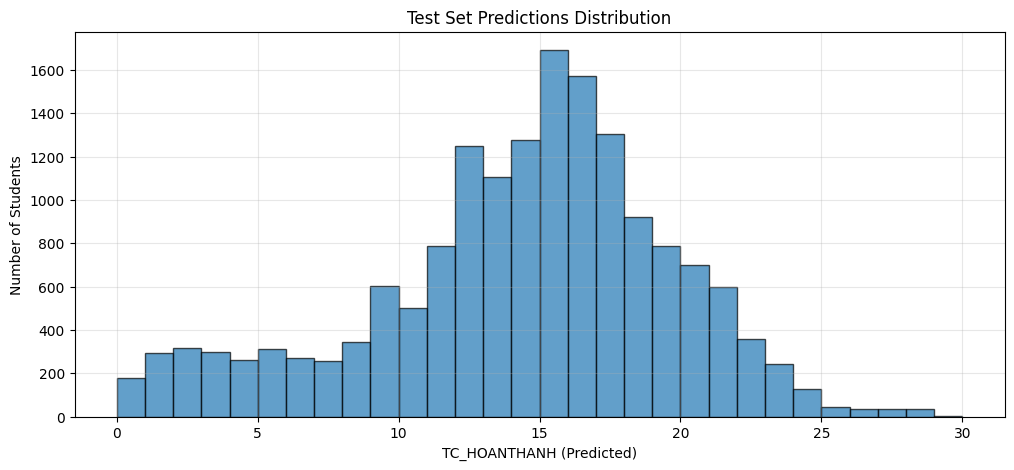

In [ ]:
print("=" * 80)
print(" SUBMISSION STATISTICS")
print("=" * 80)

print(f"\nTotal predictions: {len(submission):,}")
print(f"\nTC_HOANTHANH distribution:")
print(submission['PRED_TC_HOANTHANH'].describe())

print(f"\nValue counts (top 10):")
print(submission['PRED_TC_HOANTHANH'].value_counts().head(10))

# Plot
plt.figure(figsize=(12, 5))
plt.hist(submission['PRED_TC_HOANTHANH'], bins=np.arange(0, 31), 
         edgecolor='black', alpha=0.7)
plt.xlabel('TC_HOANTHANH (Predicted)')
plt.ylabel('Number of Students')
plt.title('Test Set Predictions Distribution')
plt.grid(True, alpha=0.3)
plt.show()

## 5.7 Save Additional Files

In [ ]:
# Save feature engineered data
df_train_enc.to_csv(f'{OUTPUT_DIR}/train_features.csv', index=False)
df_val_enc.to_csv(f'{OUTPUT_DIR}/val_features.csv', index=False)
df_test_enc.to_csv(f'{OUTPUT_DIR}/test_features.csv', index=False)

# Save validation analysis
val_analysis.to_csv(f'{OUTPUT_DIR}/validation_analysis.csv', index=False)


Creating Prediction Analysis Plots...


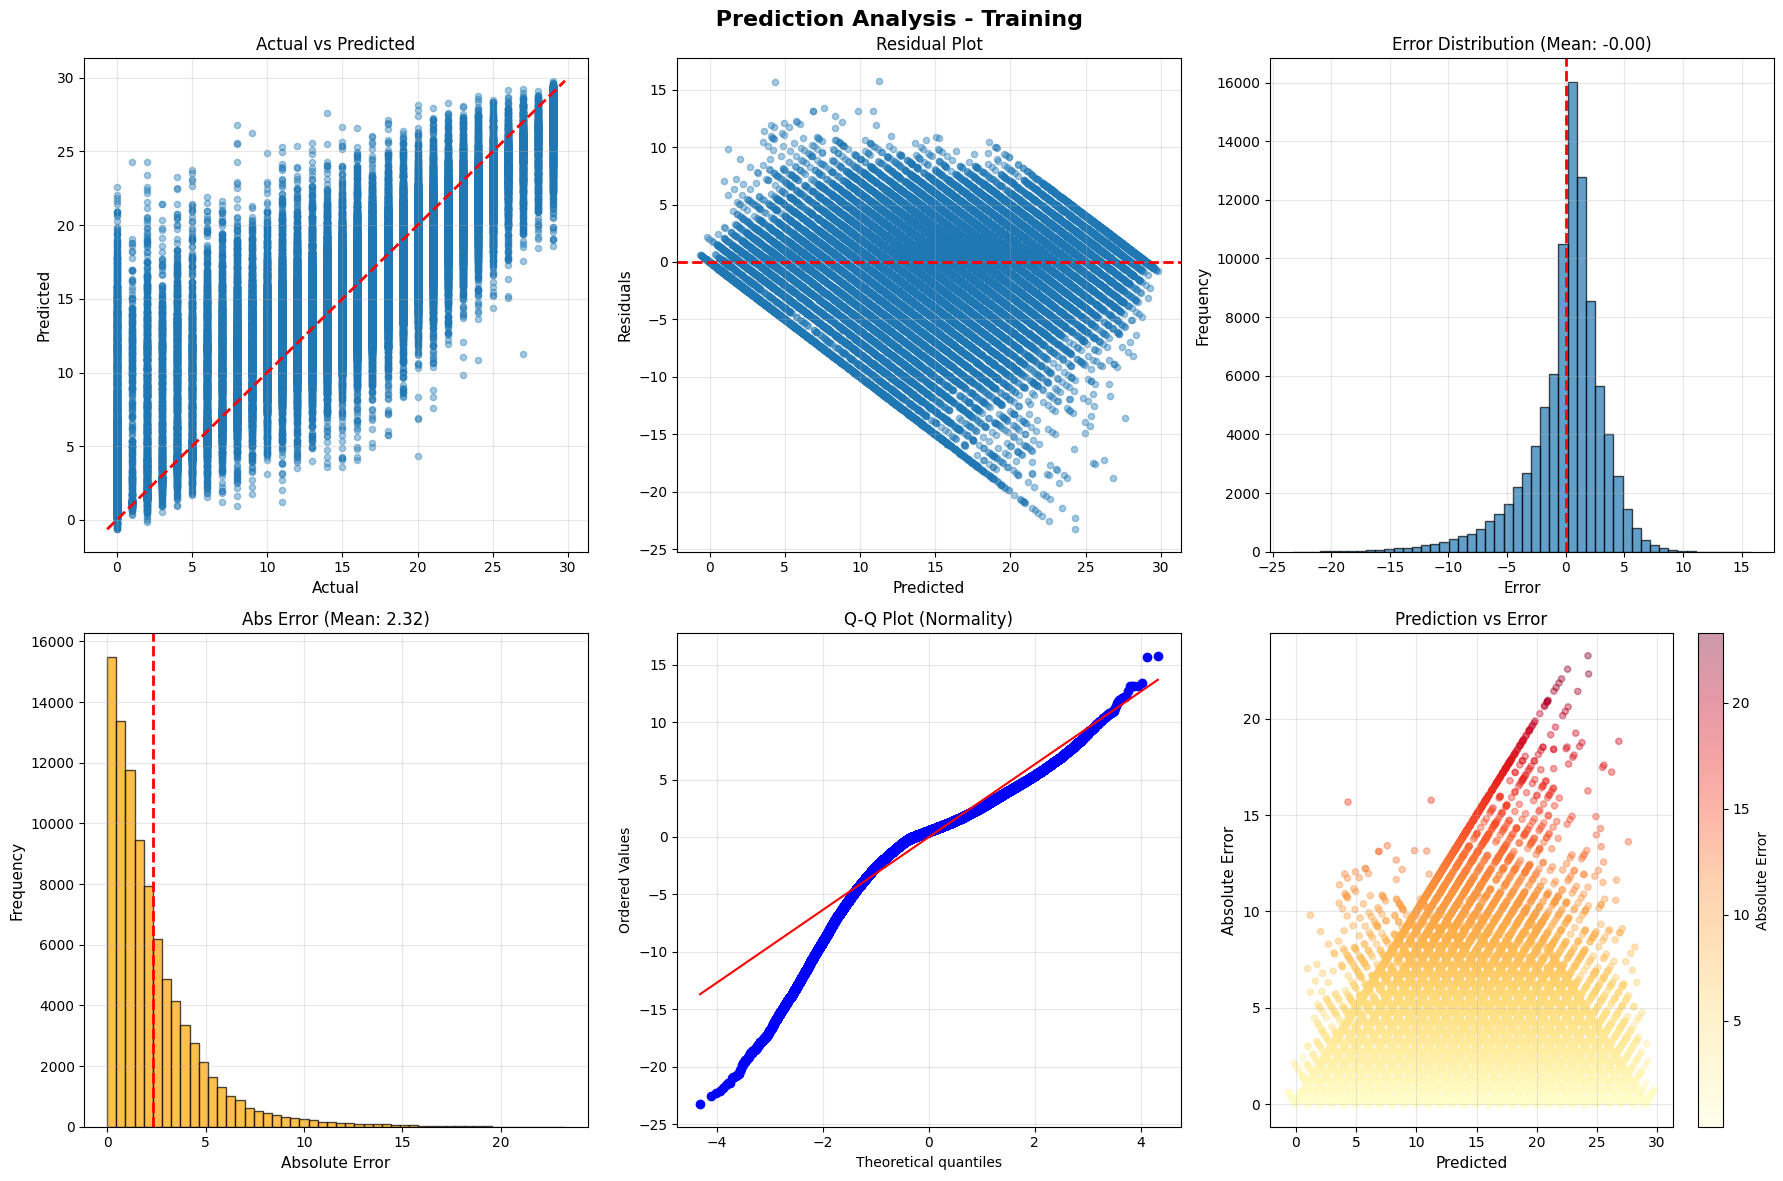

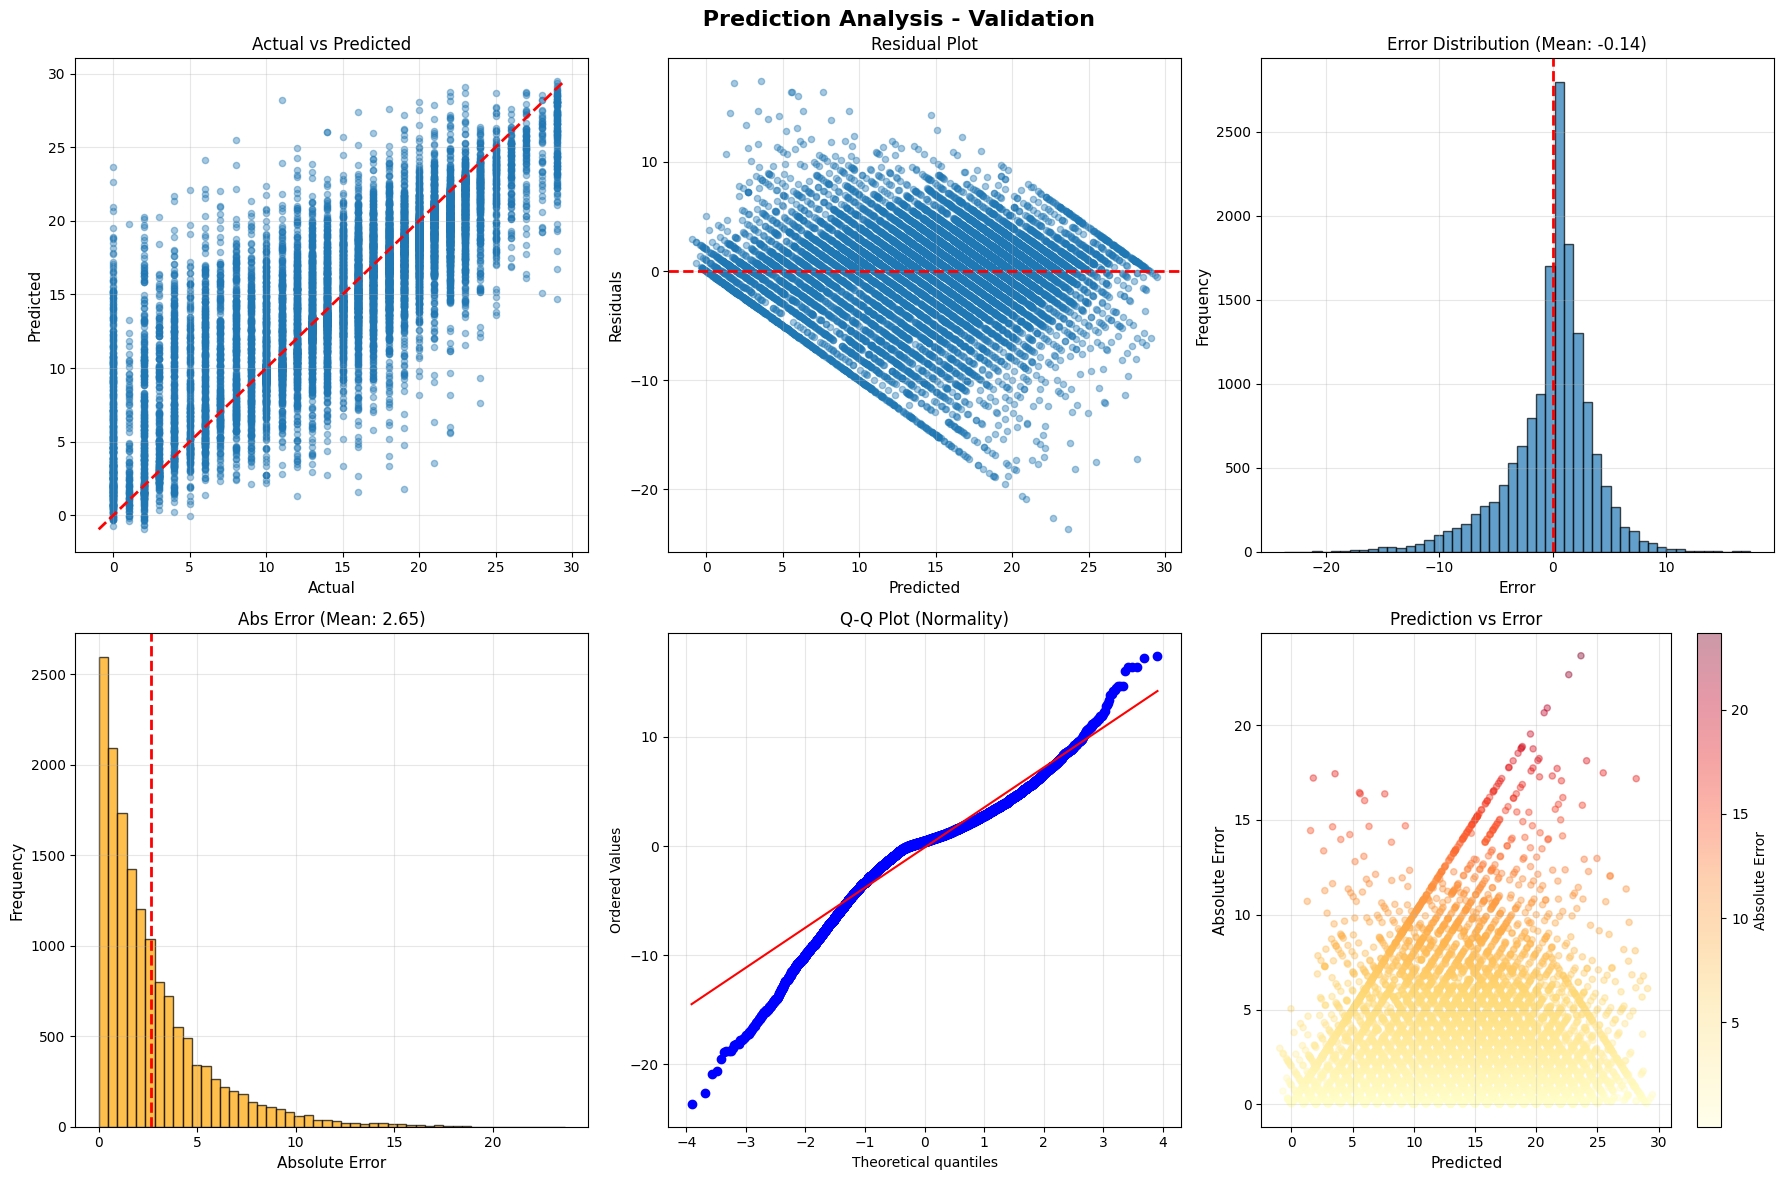

    Saved prediction_analysis plots


In [95]:
print("\nCreating Prediction Analysis Plots...")

def plot_prediction_analysis(y_true, y_pred, name, save_path):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f' Prediction Analysis - {name}', fontsize=16, fontweight='bold')
    
    # Convert to numpy if needed
    y_true_arr = y_true.values if hasattr(y_true, 'values') else y_true
    y_pred_arr = y_pred if isinstance(y_pred, np.ndarray) else np.array(y_pred)
    
    residuals = y_true_arr - y_pred_arr
    
    # 1. Actual vs Predicted
    axes[0, 0].scatter(y_true_arr, y_pred_arr, alpha=0.4, s=20)
    min_val, max_val = min(y_true_arr.min(), y_pred_arr.min()), max(y_true_arr.max(), y_pred_arr.max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual', fontsize=11)
    axes[0, 0].set_ylabel('Predicted', fontsize=11)
    axes[0, 0].set_title('Actual vs Predicted', fontsize=12)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Residuals
    axes[0, 1].scatter(y_pred_arr, residuals, alpha=0.4, s=20)
    axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0, 1].set_xlabel('Predicted', fontsize=11)
    axes[0, 1].set_ylabel('Residuals', fontsize=11)
    axes[0, 1].set_title('Residual Plot', fontsize=12)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Error Distribution
    axes[0, 2].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 2].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[0, 2].set_xlabel('Error', fontsize=11)
    axes[0, 2].set_ylabel('Frequency', fontsize=11)
    axes[0, 2].set_title(f'Error Distribution (Mean: {residuals.mean():.2f})', fontsize=12)
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Absolute Error
    abs_errors = np.abs(residuals)
    axes[1, 0].hist(abs_errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 0].axvline(x=abs_errors.mean(), color='r', linestyle='--', lw=2)
    axes[1, 0].set_xlabel('Absolute Error', fontsize=11)
    axes[1, 0].set_ylabel('Frequency', fontsize=11)
    axes[1, 0].set_title(f'Abs Error (Mean: {abs_errors.mean():.2f})', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Q-Q Plot
    stats.probplot(residuals.ravel(), dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot (Normality)', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Prediction vs Abs Error
    sc = axes[1, 2].scatter(y_pred_arr, abs_errors, alpha=0.4, s=20, c=abs_errors, cmap='YlOrRd')
    plt.colorbar(sc, ax=axes[1, 2], label='Absolute Error')
    axes[1, 2].set_xlabel('Predicted', fontsize=11)
    axes[1, 2].set_ylabel('Absolute Error', fontsize=11)
    axes[1, 2].set_title('Prediction vs Error', fontsize=12)
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_prediction_analysis(y_train, y_pred_train, 'Training', 
                        f'{RESULTS_DIR}/plots/prediction_analysis_train.png')
plot_prediction_analysis(y_val, y_pred_val, 'Validation',
                        f'{RESULTS_DIR}/plots/prediction_analysis_validation.png')
print("    Saved prediction_analysis plots")

***SAVE CV RESULTS***


 Saving Cross-Validation Results...


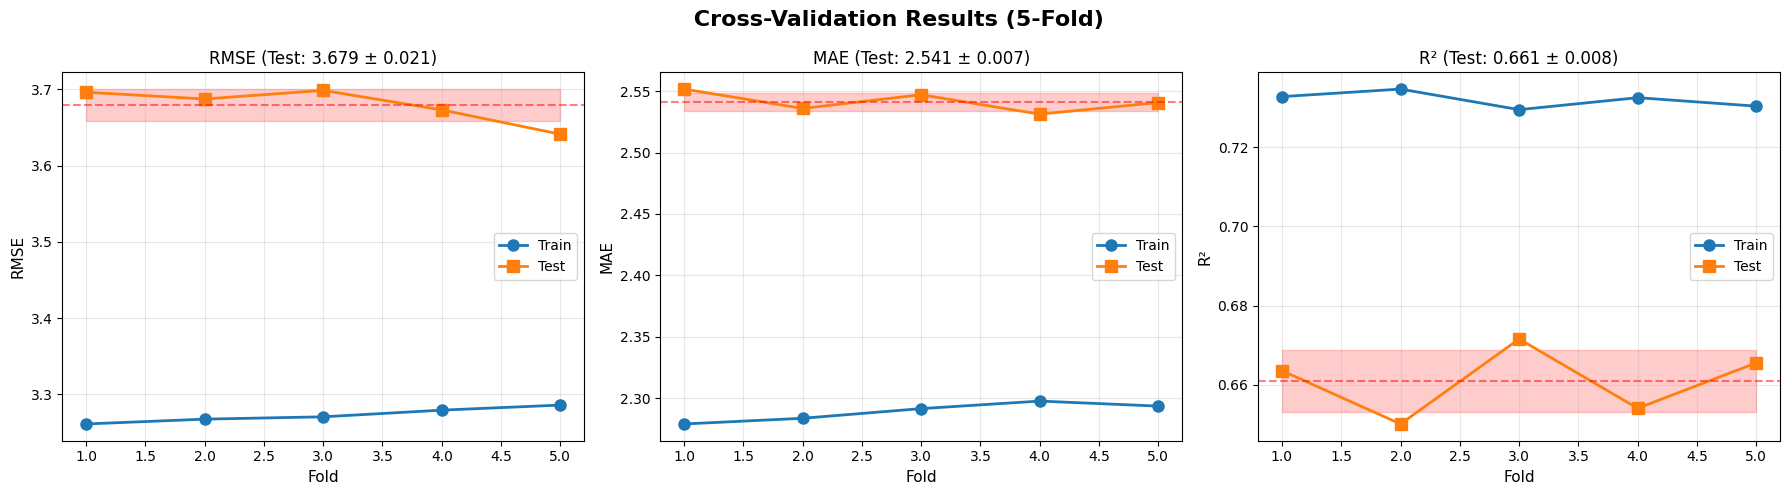

    Saved cv_fold_results.csv, cv_summary.json, and cv_results.png


In [75]:
print("\n Saving Cross-Validation Results...")

cv_test_rmse = np.sqrt(-cv_scores['test_neg_mse'])
cv_train_rmse = np.sqrt(-cv_scores['train_neg_mse'])
cv_test_mae = -cv_scores['test_neg_mae']
cv_train_mae = -cv_scores['train_neg_mae']
cv_test_r2 = cv_scores['test_r2']
cv_train_r2 = cv_scores['train_r2']

cv_df = pd.DataFrame({
    'fold': range(1, 6),
    'test_rmse': cv_test_rmse,
    'train_rmse': cv_train_rmse,
    'test_mae': cv_test_mae,
    'train_mae': cv_train_mae,
    'test_r2': cv_test_r2,
    'train_r2': cv_train_r2,
})
cv_df.to_csv(f'{RESULTS_DIR}/cv_fold_results.csv', index=False)

cv_summary = {
    'test_rmse_mean': float(cv_test_rmse.mean()),
    'test_rmse_std': float(cv_test_rmse.std()),
    'test_mae_mean': float(cv_test_mae.mean()),
    'test_mae_std': float(cv_test_mae.std()),
    'test_r2_mean': float(cv_test_r2.mean()),
    'test_r2_std': float(cv_test_r2.std()),
}

with open(f'{RESULTS_DIR}/cv_summary.json', 'w') as f:
    json.dump(cv_summary, f, indent=2)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(' Cross-Validation Results (5-Fold)', fontsize=16, fontweight='bold')

folds = range(1, 6)

for idx, (metric_name, train_vals, test_vals) in enumerate([
    ('RMSE', cv_train_rmse, cv_test_rmse),
    ('MAE', cv_train_mae, cv_test_mae),
    ('R²', cv_train_r2, cv_test_r2)
]):
    ax = axes[idx]
    ax.plot(folds, train_vals, 'o-', label='Train', linewidth=2, markersize=8)
    ax.plot(folds, test_vals, 's-', label='Test', linewidth=2, markersize=8)
    ax.axhline(test_vals.mean(), color='red', linestyle='--', alpha=0.5)
    ax.fill_between(folds, test_vals.mean() - test_vals.std(),
                    test_vals.mean() + test_vals.std(), alpha=0.2, color='red')
    ax.set_xlabel('Fold', fontsize=11)
    ax.set_ylabel(metric_name, fontsize=11)
    ax.set_title(f'{metric_name} (Test: {test_vals.mean():.3f} ± {test_vals.std():.3f})', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/cv_results.png', dpi=300, bbox_inches='tight')
plt.show()
print("    Saved cv_fold_results.csv, cv_summary.json, and cv_results.png")

***GENERATE COMPREHENSIVE REPORT***

In [76]:
print("\n Generating Comprehensive Report...")

report = f"""
{'='*80}
COMPREHENSIVE MODEL EVALUATION REPORT
{'='*80}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

{'='*80}
1. MODEL PERFORMANCE METRICS
{'='*80}

TRAINING SET ({metrics_train['n_samples']:,} samples):
-------------
MAE:   {metrics_train['MAE']:.4f}
MSE:   {metrics_train['MSE']:.4f}
RMSE:  {metrics_train['RMSE']:.4f}
R²:    {metrics_train['R2']:.4f}
MAPE:  {metrics_train['MAPE']:.2f}%
Accuracy (±1 credit):  {metrics_train['Accuracy_within_1']:.1f}%
Accuracy (±2 credits): {metrics_train['Accuracy_within_2']:.1f}%
Accuracy (±3 credits): {metrics_train['Accuracy_within_3']:.1f}%

VALIDATION SET ({metrics_val['n_samples']:,} samples):
---------------
MAE:   {metrics_val['MAE']:.4f}
MSE:   {metrics_val['MSE']:.4f}
RMSE:  {metrics_val['RMSE']:.4f}
R²:    {metrics_val['R2']:.4f}
MAPE:  {metrics_val['MAPE']:.2f}%
Accuracy (±1 credit):  {metrics_val['Accuracy_within_1']:.1f}%
Accuracy (±2 credits): {metrics_val['Accuracy_within_2']:.1f}%
Accuracy (±3 credits): {metrics_val['Accuracy_within_3']:.1f}%

CROSS-VALIDATION (5-Fold):
--------------------------
Test RMSE: {cv_summary['test_rmse_mean']:.4f} ± {cv_summary['test_rmse_std']:.4f}
Test MAE:  {cv_summary['test_mae_mean']:.4f} ± {cv_summary['test_mae_std']:.4f}
Test R²:   {cv_summary['test_r2_mean']:.4f} ± {cv_summary['test_r2_std']:.4f}

Stability: {" STABLE" if cv_summary['test_rmse_std'] < 0.5 else " HIGH VARIANCE"}
Overfitting: {" MINIMAL" if abs(metrics_train['RMSE'] - metrics_val['RMSE']) < 1.0 else " POSSIBLE"}

{'='*80}
2. FEATURE IMPORTANCE - Top 15 by Gain
{'='*80}

"""

for i, row in importance_df.head(15).iterrows():
    report += f"{i+1:2d}. {row['feature']:30s} {row['gain']:10.2f}\n"

report += f"""
{'='*80}
3. SHAP ANALYSIS - Top 15 Most Influential Features
{'='*80}

"""

for i, row in mean_shap_df.head(15).iterrows():
    report += f"{i+1:2d}. {row['feature']:30s} {row['mean_abs_shap']:10.4f}\n"

report += f"""
{'='*80}
4. FILES GENERATED
{'='*80}

Metrics:
   metrics_train.json & .csv
   metrics_validation.json & .csv
   cv_fold_results.csv
   cv_summary.json

Feature Importance:
   feature_importance.csv & .png

SHAP Analysis:
   shap_values.csv
   shap_feature_importance.csv
   shap_summary_bar.png
   shap_summary_beeswarm.png
   shap_dependence_plots.png

LIME Explanations:
   lime_explanations.json & .png

Prediction Analysis:
   prediction_analysis_train.png
   prediction_analysis_validation.png

Cross-Validation:
   cv_results.png

{'='*80}
5. KEY FINDINGS
{'='*80}

 Model achieves R² of {metrics_val['R2']:.3f} on validation set
 {metrics_val['Accuracy_within_1']:.1f}% of predictions within ±1 credit
 RMSE of {metrics_val['RMSE']:.3f} indicates good predictive accuracy
 Cross-validation confirms model stability (std: {cv_summary['test_rmse_std']:.3f})

 All results saved in: {RESULTS_DIR}/
"""

with open(f'{RESULTS_DIR}/COMPREHENSIVE_REPORT.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)


 Generating Comprehensive Report...

COMPREHENSIVE MODEL EVALUATION REPORT
Generated: 2026-02-04 15:53:56

1. MODEL PERFORMANCE METRICS

TRAINING SET (90,582 samples):
-------------
MAE:   2.3178
MSE:   11.0011
RMSE:  3.3168
R²:    0.7247
MAPE:  23.90%
Accuracy (±1 credit):  34.0%
Accuracy (±2 credits): 58.1%
Accuracy (±3 credits): 73.4%

VALIDATION SET (15,144 samples):
---------------
MAE:   2.6493
MSE:   14.4667
RMSE:  3.8035
R²:    0.6941
MAPE:  30.46%
Accuracy (±1 credit):  32.6%
Accuracy (±2 credits): 53.8%
Accuracy (±3 credits): 68.5%

CROSS-VALIDATION (5-Fold):
--------------------------
Test RMSE: 3.6793 ± 0.0211
Test MAE:  2.5413 ± 0.0073
Test R²:   0.6610 ± 0.0078

Stability:  STABLE
Overfitting:  MINIMAL

2. FEATURE IMPORTANCE - Top 15 by Gain

 6. consecutive_fails                 4791.24
 1. TC_DANGKY_current                 2915.55
 2. TC_GPA_interaction                2750.68
 8. fail_rate                         1070.68
 5. CPA_last                           701.16
 4

## 5.3 Analyze Validation Predictions

In [77]:
y_pred_val_rounded = np.round(y_pred_val).astype(int)

# Create analysis DataFrame
val_analysis = pd.DataFrame({
    'MA_SO_SV': df_val_enc['MA_SO_SV'].values,
    'TC_DANGKY': df_val_enc['TC_DANGKY_current'].values,
    'TC_HOANTHANH_actual': y_val.values,
    'TC_HOANTHANH_pred': y_pred_val_rounded,
    'error': y_val.values - y_pred_val_rounded,
    'abs_error': np.abs(y_val.values - y_pred_val_rounded)
})

print("=" * 80)
print(" VALIDATION PREDICTIONS ANALYSIS")
print("=" * 80)

print("\nError distribution:")
print(val_analysis['error'].describe())

print("\n10 Best predictions (error = 0):")
display(val_analysis[val_analysis['error'] == 0].head(10))

print("\n10 Worst predictions:")
display(val_analysis.nlargest(10, 'abs_error'))

 VALIDATION PREDICTIONS ANALYSIS

Error distribution:
count    15144.000000
mean        -0.146263
std          3.812649
min        -24.000000
25%         -2.000000
50%          0.000000
75%          2.000000
max         17.000000
Name: error, dtype: float64

10 Best predictions (error = 0):


MA_SO_SV  TC_DANGKY  TC_HOANTHANH_actual  TC_HOANTHANH_pred  error  \
0   00003e092652         18                   13                 13      0   
1   000e15519006         22                   19                 19      0   
7   0020346dae01         10                   10                 10      0   
8   0020f96b0fb0         21                   21                 21      0   
10  0029c0f6e072          3                    3                  3      0   
11  002dafe89f63         16                   16                 16      0   
16  003f354f2523         23                   23                 23      0   
19  004a76869c57         12                   10                 10      0   
32  006905d0eae3         18                   16                 16      0   
33  006dfc5f9e87         18                   16                 16      0   

    abs_error  
0           0  
1           0  
7           0  
8           0  
10          0  
11          0  
16          0  
19          0  
32          0  
33          0


10 Worst predictions:


MA_SO_SV  TC_DANGKY  TC_HOANTHANH_actual  TC_HOANTHANH_pred  error  \
5774   61e704fdef68         29                    0                 24    -24   
9609   a24ef7e76398         29                    0                 23    -23   
8901   9703b724fcd7         24                    0                 21    -21   
13864  ea627b6d89dd         28                    0                 21    -21   
8067   88e963c787f7         22                    0                 20    -20   
566    0935e7f56f1a         22                    0                 19    -19   
2313   264b8013ce97         29                    0                 19    -19   
8557   91598af3df88         21                    0                 19    -19   
12502  d3d3f005e92b         29                    0                 19    -19   
14122  ef026c8da7e5         24                    1                 20    -19   

       abs_error  
5774          24  
9609          23  
8901          21  
13864         21  
8067          20  
566           19  
2313          19  
8557          19  
12502         19  
14122         19

## 5.4 Predict on Test Set

In [78]:
print("=" * 80)
print(" PREDICTING ON TEST SET")
print("=" * 80)

y_pred_test = model.predict(X_test)
y_pred_test_rounded = y_pred_test

# Clip to [0, TC_DANGKY]
tc_dangky_values = df_test_enc['TC_DANGKY_current'].values
y_pred_test_clipped = np.clip(y_pred_test_rounded, 0, tc_dangky_values)

num_clipped_lower = np.sum(y_pred_test_rounded < 0)
num_clipped_upper = np.sum(y_pred_test_rounded > tc_dangky_values)

print(f"\n Clipping applied:")
print(f"   Clipped to 0: {num_clipped_lower}")
print(f"   Clipped to TC_DANGKY: {num_clipped_upper}")

print(f"\n Predictions:")
print(f"   Count: {len(y_pred_test_clipped):,}")
print(f"   Min:   {y_pred_test_clipped.min()}")
print(f"   Max:   {y_pred_test_clipped.max()}")
print(f"   Mean:  {y_pred_test_clipped.mean():.2f}")

 PREDICTING ON TEST SET

 Clipping applied:
   Clipped to 0: 21
   Clipped to TC_DANGKY: 385

 Predictions:
   Count: 16,502
   Min:   0.0
   Max:   29.308452606201172
   Mean:  14.32


## 5.5 Create Submission File

In [84]:
print("=" * 80)
print(" CREATING SUBMISSION FILE")
print("=" * 80)

submission = pd.DataFrame({
    'MA_SO_SV': df_test_enc['MA_SO_SV'].values,
    'PRED_TC_HOANTHANH': y_pred_test_clipped
})

# Preview
print(f"\n First 10 rows:")
print(submission.head(10))

# Save
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False, encoding='utf-8')
print(f"\nSaved to: {OUTPUT_DIR}/submission.csv")

 CREATING SUBMISSION FILE

 First 10 rows:
       MA_SO_SV  PRED_TC_HOANTHANH
0  481436e2064d           0.000000
1  6c8a97d22131           2.696382
2  e87f62beabbb           7.163036
3  438aff5ef524           0.000000
4  ad172a9b0722          16.150030
5  b87bd14ae979           1.674440
6  16b5b14ab7ea          19.912483
7  d6fd5b4d69b4          19.859964
8  539733e0be28          19.395342
9  9e0d2886bc23          19.798067

Saved to: ./outputs/submission.csv


## 5.6 Submissio Statistics


 SUBMISSION STATISTICS

Total predictions: 16,502

TC_HOANTHANH distribution:
count    16502.000000
mean        14.320339
std          5.403861
min          0.000000
25%         11.686419
50%         15.140898
75%         17.773702
max         29.308453
Name: PRED_TC_HOANTHANH, dtype: float64

Value counts (top 10):
PRED_TC_HOANTHANH
22.0    89
20.0    67
1.0     39
18.0    38
17.0    36
19.0    22
0.0     21
24.0    19
2.0     13
3.0     13
Name: count, dtype: int64


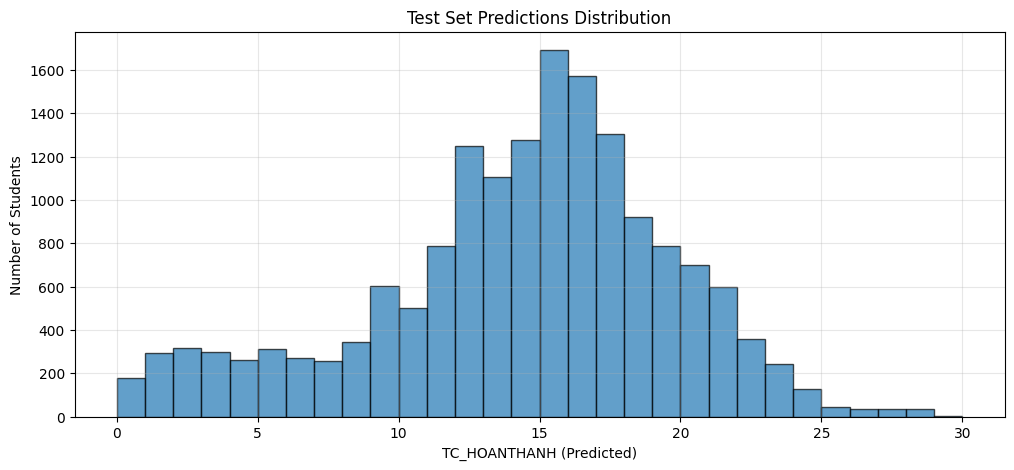

In [80]:
print("=" * 80)
print(" SUBMISSION STATISTICS")
print("=" * 80)

print(f"\nTotal predictions: {len(submission):,}")
print(f"\nTC_HOANTHANH distribution:")
print(submission['PRED_TC_HOANTHANH'].describe())

print(f"\nValue counts (top 10):")
print(submission['PRED_TC_HOANTHANH'].value_counts().head(10))

# Plot
plt.figure(figsize=(12, 5))
plt.hist(submission['PRED_TC_HOANTHANH'], bins=np.arange(0, 31), 
         edgecolor='black', alpha=0.7)
plt.xlabel('TC_HOANTHANH (Predicted)')
plt.ylabel('Number of Students')
plt.title('Test Set Predictions Distribution')
plt.grid(True, alpha=0.3)
plt.show()

## 5.7 Save Additional Files

In [85]:
# Save feature engineered data
df_train_enc.to_csv(f'{OUTPUT_DIR}/train_features.csv', index=False)
df_val_enc.to_csv(f'{OUTPUT_DIR}/val_features.csv', index=False)
df_test_enc.to_csv(f'{OUTPUT_DIR}/test_features.csv', index=False)

# Save validation analysis
val_analysis.to_csv(f'{OUTPUT_DIR}/validation_analysis.csv', index=False)